# T/NK Cell Figures
## Sid Gurajala
## Last Updated: 03/21/2024

In [14]:
library(Seurat)
library(dplyr) 
library(tidyr)
library(viridis)
library(stringr)
library(pheatmap)
library(presto)
library(pals)
library(parallel)
library(harmony)
library(cowplot)
library(singlecellmethods)
library(ggplot2)
library(lisi) 
source("/data/srlab/anathan/scripts/scseq_utils.R")
library(parallel)
library('lme4', lib.loc = "/PHShome/ssg34/.conda/envs/jupy/lib/R/library")
library(glmmTMB, lib.loc ="/PHShome/ssg34/.conda/envs/jupy/lib/R/library")
.libPaths("/PHShome/ssg34/.conda/envs/plswork/lib/R/library")


pivot_wilcox_expr <- function(wilcox_obj) {
    df <- wilcox_obj %>% select(group, feature, avgExpr) %>% 
                    pivot_wider(names_from = 'feature', values_from = 'avgExpr') %>% data.frame()
    rownames(df) <- df$group
    df <- df %>% select(-group) %>% as.matrix()
    return(df)
}

pivot_wilcox_logFC <- function(wilcox_obj) {
    df <- wilcox_obj %>% select(group, feature, logFC) %>% 
                    pivot_wider(names_from = 'feature', values_from = 'logFC') %>% data.frame()
    rownames(df) <- df$group
    df <- df %>% select(-group) %>% as.matrix()
    return(df)
}

plot_shuffled_features <- function(input_df, input_norm, feature, pct, pt_size) {
    
max.cutoff = quantile(input_norm[feature, input_df$cell], pct)
min.cutoff = quantile(input_norm[feature, input_df$cell], 1-pct)

plot_df <- input_df 
    
plot_df$norm_expression <- input_norm[feature, input_df$cell]
    
plot_df <- plot_df %>% 
                mutate(norm_expression = ifelse(norm_expression < min.cutoff, min.cutoff, norm_expression)) %>%
                mutate(norm_expression = ifelse(norm_expression > max.cutoff, max.cutoff, norm_expression)) 

p <- ggplot() +
        geom_point(
            data = plot_df[sample(nrow(plot_df)), ] %>% 
                      select(hUMAP1, hUMAP2, norm_expression), 
            aes(x = hUMAP1, y = hUMAP2, color = norm_expression),
            size = pt_size, stroke = 0.0001, shape = 20) +
      scale_color_viridis(name = "Expression") +
      labs(x="", y="", title = feature)+
      theme_classic(base_size = 20)+
      #facet_wrap(~dataset)+
      theme(
        legend.text = element_text(size = 10), 
        legend.title = element_text(size = 12),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=25, face="bold.italic", hjust = 0.5),
        strip.text.x = element_text(size = 18),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          axis.line = element_blank()) 
return(p)
}

vargenes_vst <- function(object, groups, topn, loess.span = 0.3) {
    clip.max <- sqrt(ncol(object))

    N <- ncol(object)
    if (missing(groups)) {
        groups <- rep('A', N)
    }
    
    res <- split(seq_len(N), groups) %>% lapply(function(idx) {
        object_group <- object[, idx]
        ## row means
        hvf.info <- data.frame(
          symbol = rownames(object_group), 
          mean = Matrix::rowMeans(object_group)
        )

        ## row vars
        hvf.info$variance <- rowVars(object_group, hvf.info$mean)

        ## initialize
        hvf.info$variance.expected <- 0
        hvf.info$variance.standardized <- 0

        not.const <- hvf.info$variance > 0

        ## loess curve fit 
        suppressWarnings({
            fit <- loess(formula = log10(variance) ~ log10(mean), 
                data = hvf.info[not.const, ], span = loess.span)            
        })

        ## extract fitted variance 
        hvf.info$variance.expected[not.const] <- 10^fit$fitted

        ## get row standard deviations after clipping
        hvf.info$variance.standardized <- rowVarsStd(
            object_group, 
            hvf.info$mean, 
            sqrt(hvf.info$variance.expected), 
            clip.max
        )

        hvf.info <- hvf.info %>% 
#             tibble::rownames_to_column('symbol') %>% 
            arrange(-variance.standardized) %>% 
            tibble::rowid_to_column('rank') %>% 
            transform(group = unique(groups[idx]))

        return(hvf.info)        
    })
    
    
    if (missing(topn)) {
        ## MODE 1: return table 
        res <- Reduce(rbind, res) %>% 
            dplyr::select(group, symbol, rank, everything())

        if (length(unique(res$group)) == 1) {
            res$group <- NULL
        }
    } else {
        ## MODE 2: return genes
        res <- lapply(res, function(x) head(x, topn)$symbol)
    }
    return(res)
}
                      
MASC.me <- function(dataset, cluster, contrast, random_effects = NULL, fixed_effects = NULL,
                 verbose = FALSE, save_models = FALSE, save_model_dir = NULL, weights = NULL) {
  # Generate design matrix from cluster assignments
  cluster <- as.character(cluster)
  designmat <- model.matrix(~ cluster + 0, data.frame(cluster = cluster))
  dataset <- cbind(designmat, dataset)

  # Convert cluster assignments to string
  cluster <- as.character(cluster)
  # Prepend design matrix generated from cluster assignments
  designmat <- model.matrix(~ cluster + 0, data.frame(cluster = cluster))
  dataset <- cbind(designmat, dataset)
  # Create output list to hold results
  res <- vector(mode = "list", length = length(unique(cluster)))
  names(res) <- attributes(designmat)$dimnames[[2]]

  # Create model formulas
  if (!is.null(fixed_effects) && !is.null(random_effects)) {
    model_rhs <- paste0(c(paste0(fixed_effects, collapse = " + "),
                          paste0("(1|", random_effects, ")", collapse = " + ")),
                        collapse = " + ")
    if (verbose == TRUE) {
      message(paste("Using null model:", "cluster ~", model_rhs))
    }
  } else if (!is.null(fixed_effects) && is.null(random_effects)) {
    model_rhs <- paste0(fixed_effects, collapse = " + ")
    if (verbose == TRUE) {
      message(paste("Using null model:", "cluster ~", model_rhs))
      # For now, do not allow models without mixed effects terms
      stop("No random effects specified")
    }
  } else if (is.null(fixed_effects) && !is.null(random_effects)) {
    model_rhs <- paste0("(1|", random_effects, ")", collapse = " + ")
    if (verbose == TRUE) {
      message(paste("Using null model:", "cluster ~", model_rhs))
    }
  } else {
    model_rhs <- "1" # only includes intercept
    if (verbose == TRUE) {
      message(paste("Using null model:", "cluster ~", model_rhs))
      stop("No random or fixed effects specified")
    }
  }

  # Initialize list to store model objects for each cluster
  cluster_models <- vector(mode = "list",
                           length = length(attributes(designmat)$dimnames[[2]]))
  names(cluster_models) <- attributes(designmat)$dimnames[[2]]

  # Run nested mixed-effects models for each cluster
  for (i in seq_along(attributes(designmat)$dimnames[[2]])) {
    test_cluster <- attributes(designmat)$dimnames[[2]][i]
    if (verbose == TRUE) {
      message(paste("Creating logistic mixed models for", test_cluster))
    }
    null_fm <- as.formula(paste0(c(paste0(test_cluster, " ~ 1 + "),
                                   model_rhs), collapse = ""))
    full_fm <- as.formula(paste0(c(paste0(test_cluster, " ~ ", contrast, " + "),
                                   model_rhs), collapse = ""))
    # Run null and full mixed-effects models
    null_model <- lme4::glmer(formula = null_fm, data = dataset,
                              family = binomial, nAGQ = 1, verbose = 0,
                              control = glmerControl(optimizer = "bobyqa"), weights = weights)
 #   print(summary(null_model))
    full_model <- lme4::glmer(formula = full_fm, data = dataset,
                              family = binomial, nAGQ = 1, verbose = 0,
                              control = glmerControl(optimizer = "bobyqa"), weights = weights)
 #   print(summary(full_model))
    flush.console()
    model_lrt <- anova(null_model, full_model)
    # calculate confidence intervals for contrast term beta
    contrast_lvl2 <- paste0(contrast, levels(dataset[[contrast]])[2])
    contrast_ci <- confint.merMod(full_model, method = "Wald",
                                  parm = contrast_lvl2)
    # Save model objects to list
    cluster_models[[i]]$null_model <- null_model
    cluster_models[[i]]$full_model <- full_model
    cluster_models[[i]]$model_lrt <- model_lrt
    cluster_models[[i]]$confint <- contrast_ci
  }

  # Organize results into output dataframe
  output <- data.frame(cluster = attributes(designmat)$dimnames[[2]],
                       size = colSums(designmat))
  output$model.pvalue <- sapply(cluster_models, function(x) x$model_lrt[["Pr(>Chisq)"]][2])
  output[[paste(contrast_lvl2, "OR", sep = ".")]] <- sapply(cluster_models, function(x) exp(fixef(x$full)[[contrast_lvl2]]))
  output[[paste(contrast_lvl2, "OR", "95pct.ci.lower", sep = ".")]] <- sapply(cluster_models, function(x) exp(x$confint[contrast_lvl2, "2.5 %"]))
  output[[paste(contrast_lvl2, "OR", "95pct.ci.upper", sep = ".")]] <- sapply(cluster_models, function(x) exp(x$confint[contrast_lvl2, "97.5 %"]))

  # Return MASC results and save models if specified
  if (save_models == TRUE) {
    saveModelObj(cluster_models, save_dir = save_model_dir)
    return(output)
  } else {
    return(output)
  }
}

pseudobulk <- function(individual, meta, norm) {
    cells <- meta %>% filter(sample == individual) %>% pull(cell)
    if (length(cells) > 2) {
        pb <- rowMeans(norm[, cells])
        pb <- c(pb, individual)
        names(pb) <- c(rownames(norm), 'sample')
        return(pb)
    }
}



de <- function(feature, df) {
    model_df <- df %>% select(feature, sample, Type, avg_count, avg_mt) %>% rename(Exp = feature)
    if (sum(model_df$Exp > 0) > 0.10 * nrow(model_df)) { 
        m_0 <- lm(Exp ~ log(avg_count) + avg_mt, data = model_df)
        m_1 <- lm(Exp ~ log(avg_count) + avg_mt + Type, data = model_df)
        ANNO <- anova(m_0, m_1)
        LRP <- ANNO[2,6]
        F <- ANNO[2,5]
        Beta <- summary(m_1)$coefficients['TypeLN', 'Estimate']
        SE <- summary(m_1)$coefficients['TypeLN', 'Std. Error']
        res <- c(gene = feature, LRP = LRP, F = F, Beta = Beta, SE = SE)
    }
    else {
        res <- c(gene = feature, LRP = NA, F = NA, Beta = NA, SE = NA)
    }
    return(res)
}  
                                                                              

cna_cor <- function(gene, meta, norm) {
    if (sum(norm[gene, meta$cell]) > 0.1 * nrow(meta)) {
        cor_test <- cor.test(meta$ncorr, norm[gene, meta$cell])
        res <- c(gene, cor_test$estimate, cor_test$p.value)
    }
    else {
        res <- c(gene, NA, NA)
    }
    return(res)
}

In [ ]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/Myeloid_clusterQCd_meta_harmonizedPCUMAPCellStateClusters_10042022.rds')
prop_table <- qcd_meta %>% filter(dataset == "scRNAseq") %>% 
                group_by(new_cluster_number) %>% 
                select(sample, new_cluster_number) %>% 
                table() %>% prop.table(margin = 1) %>% data.frame()
prop_table <- prop_table %>% 
                mutate(individual = str_split(sample, '_')) %>% 
                rowwise() %>% 
                mutate(individual = unlist(individual)[3])

In [ ]:
colnames(clinical_LN) <- str_remove_all(str_remove_all(colnames(clinical_LN), "\\["), "\\]")
prop_table <- prop_table %>% 
                left_join(clinical_LN %>% 
                            select(individual, Final_ISN), by = 'individual') %>% 
                na.omit()

[1] FALSE
[1] FALSE


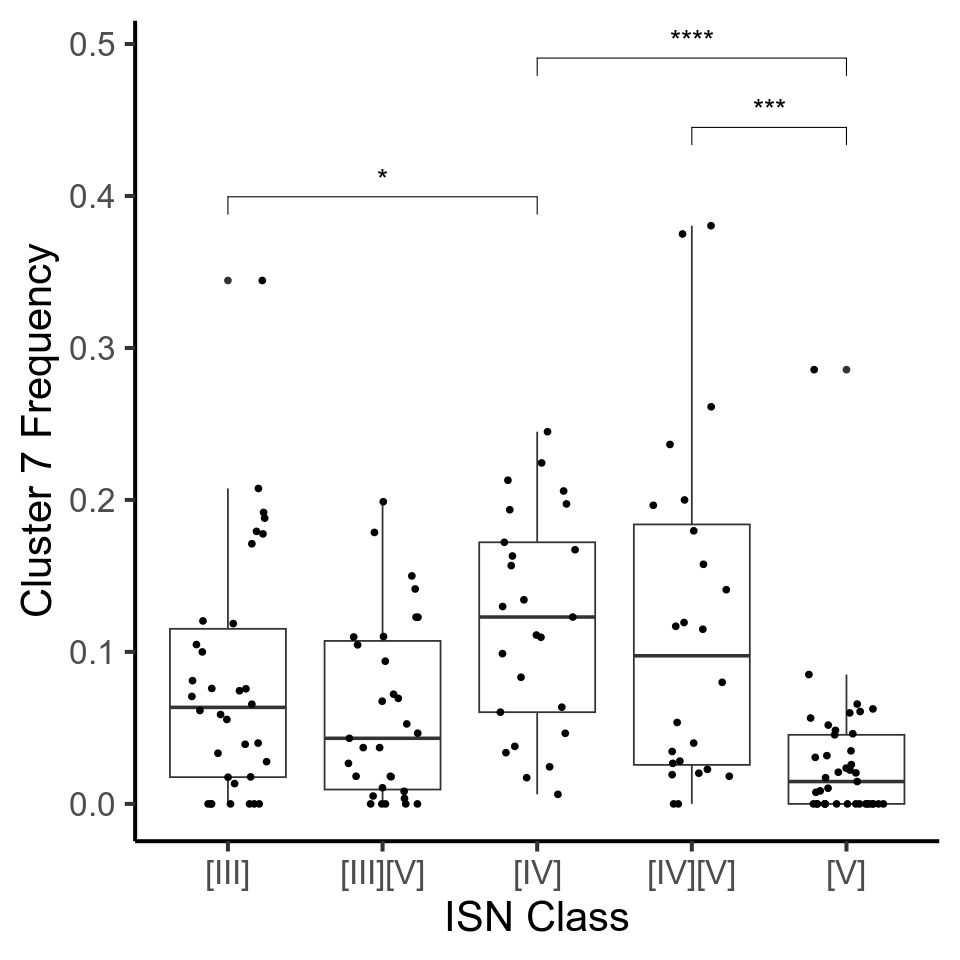

[1] FALSE


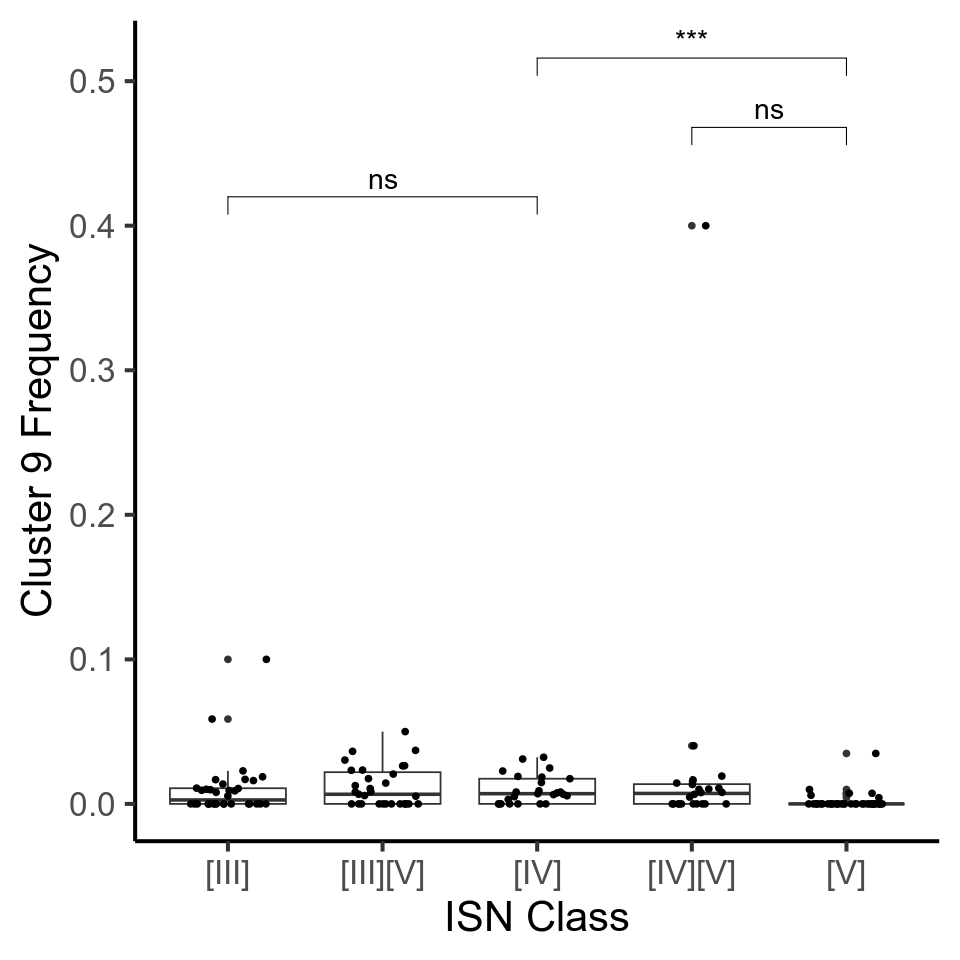

[1] FALSE


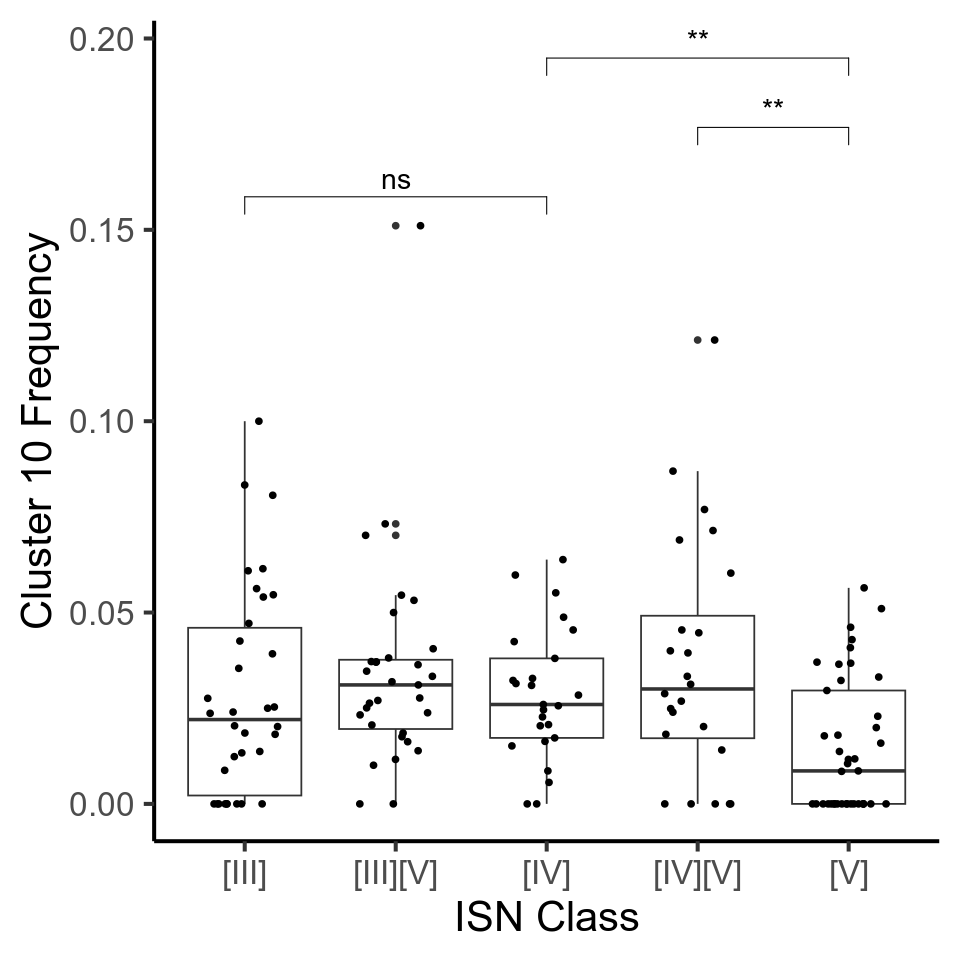

[1] FALSE


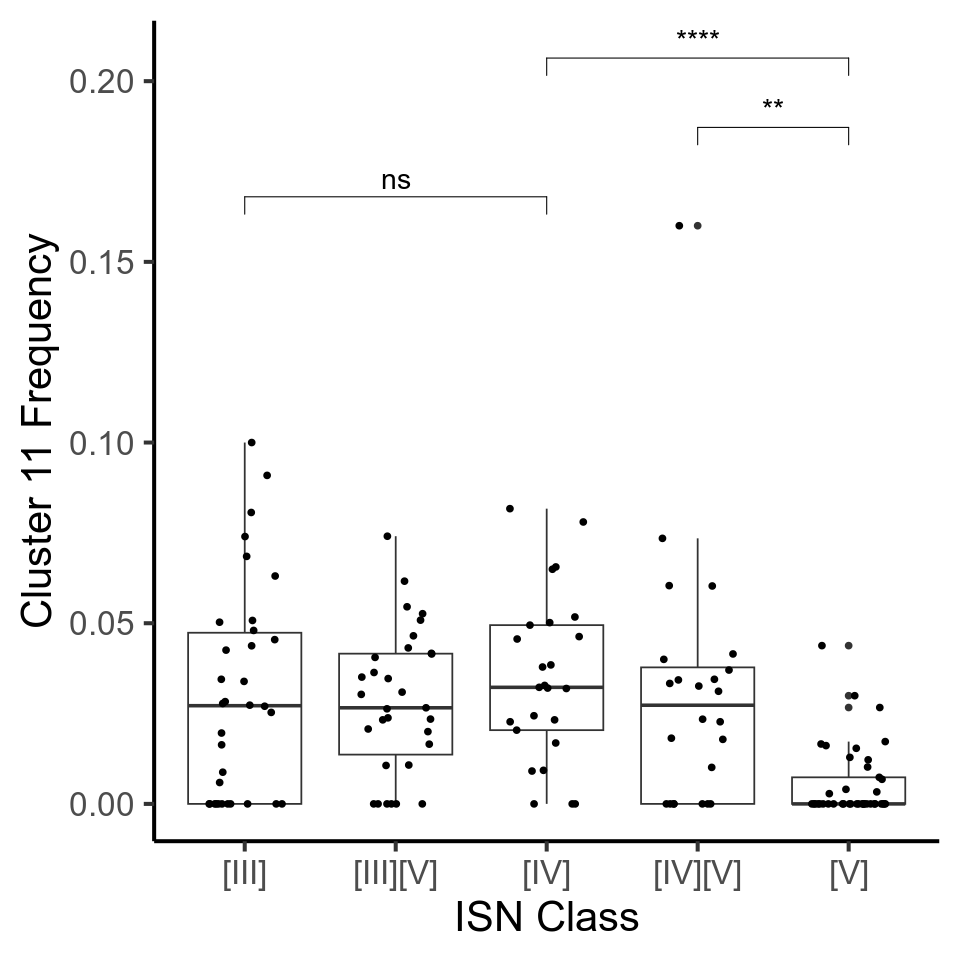

[1] FALSE


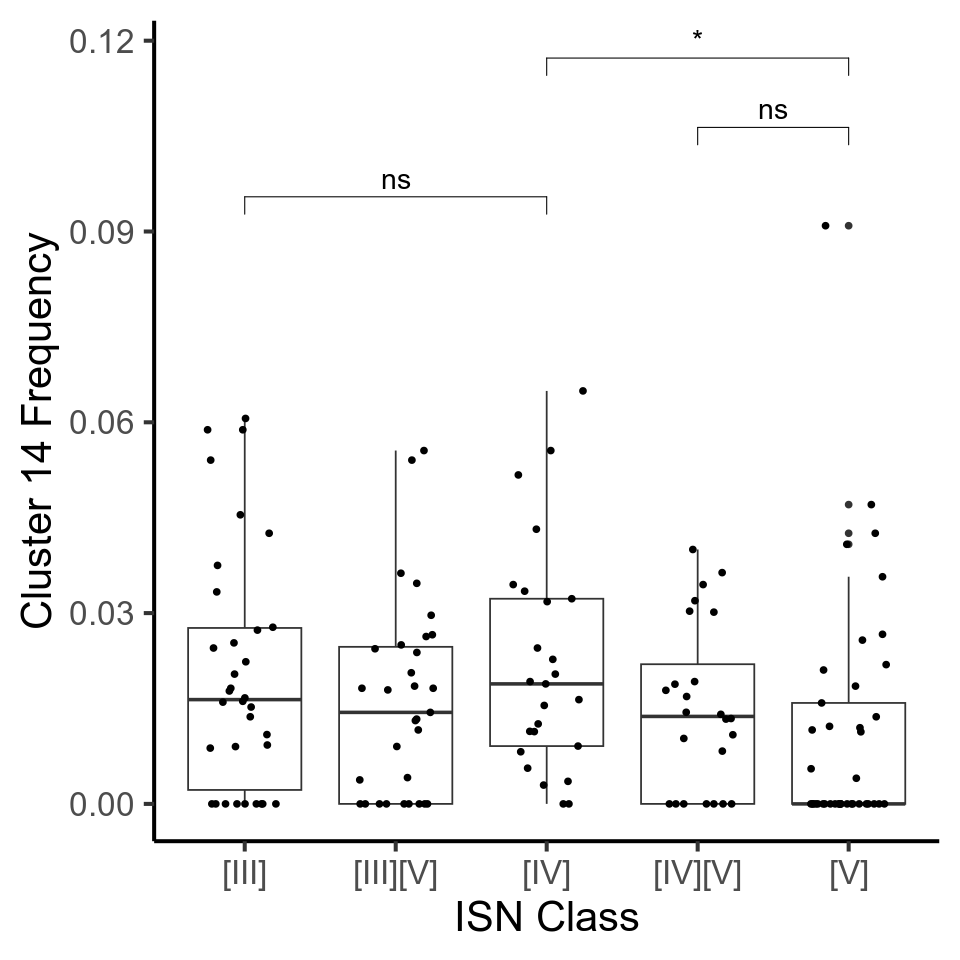

[1] FALSE


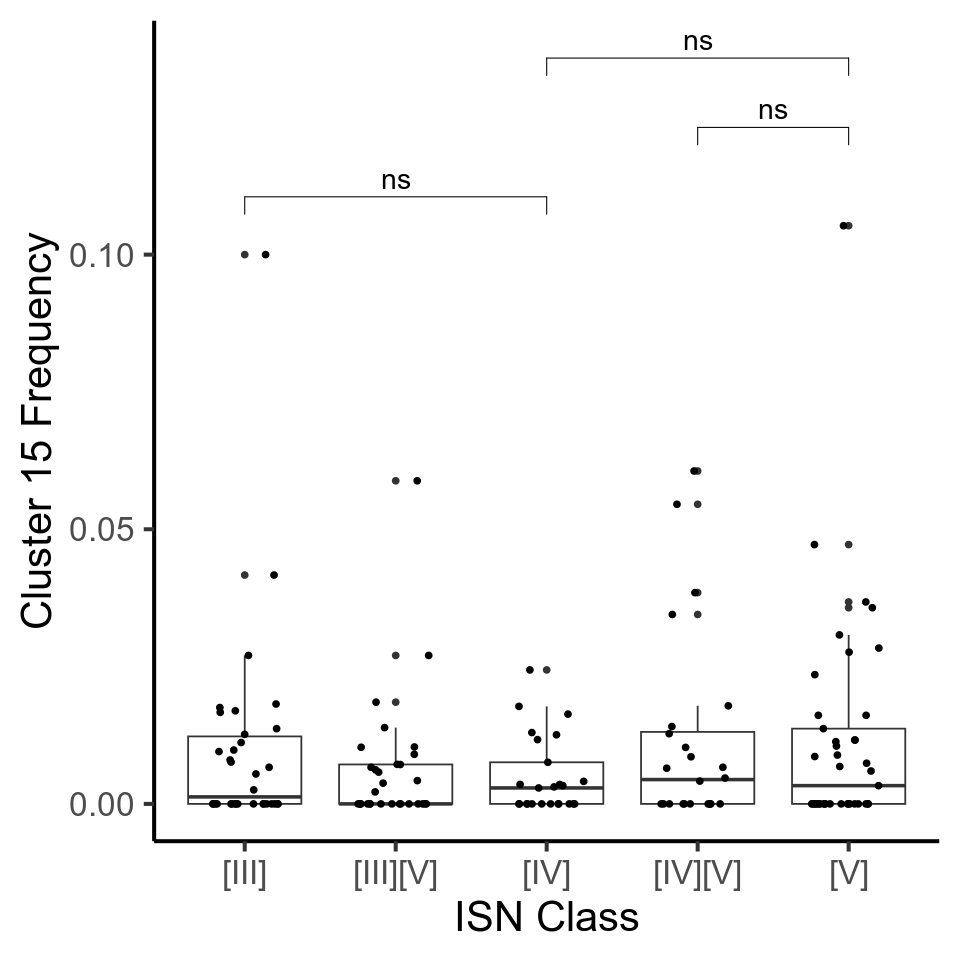

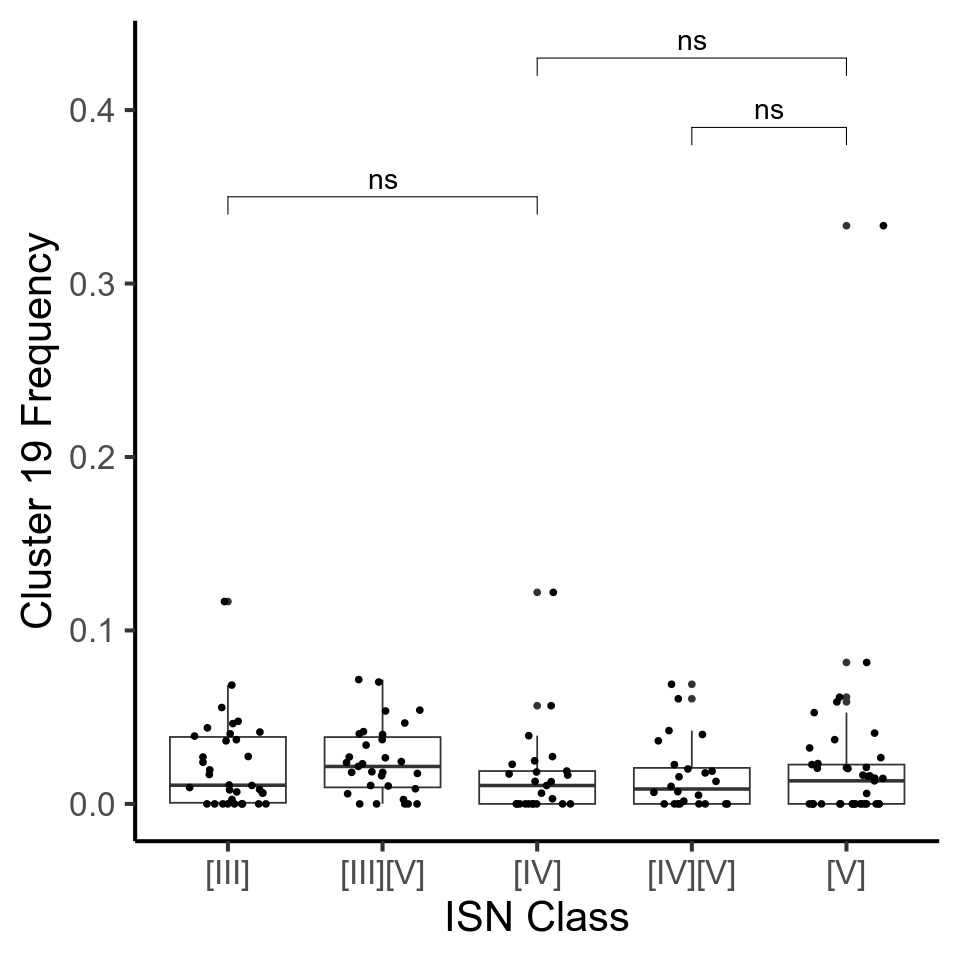

In [ ]:
fig.size(8, 8)

my_comparisons <- list(c("[III]", "[IV]"),
                       c("[IV][V]", "[V]"),
                       c("[IV]", "[V]"))
ggplot(prop_table %>% 
        filter(new_cluster_number == 7), aes(x = factor(Final_ISN), y = Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 7 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

ggplot(prop_table %>% 
        filter(new_cluster_number == 9), aes(x = factor(Final_ISN), y = Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 9 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

ggplot(prop_table %>% 
        filter(new_cluster_number == 10), aes(x = factor(Final_ISN), y = Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 10 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

ggplot(prop_table %>% 
        filter(new_cluster_number == 11), aes(x = factor(Final_ISN), y = Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 11 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

ggplot(prop_table %>% 
        filter(new_cluster_number == 14), aes(x = factor(Final_ISN), y = Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 14 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

ggplot(prop_table %>% 
        filter(new_cluster_number == 15), aes(x = factor(Final_ISN), y = Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 15 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

ggplot(prop_table %>% 
        filter(new_cluster_number == 19), aes(x = factor(Final_ISN), y = Freq)) + 
    geom_boxplot() +
    geom_jitter(width = 0.25, height = 0) + 
    theme_classic(base_size = 25) + 
    labs(x = "ISN Class", y = "Cluster 19 Frequency") + 
    ggpubr::stat_compare_means(label = "p.signif", method = "t.test", 
                               comparisons = my_comparisons, size = 6)

# T_NK

In [2]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_NK_clusterQCd_meta_harmonizedPCUMAPclusters_annotations02062024.rds')
qcd_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_NK_clusterQCd_norm_09092022.rds')
wilcox <- wilcoxauc(qcd_norm, qcd_meta$new_cluster_number)

In [22]:
sn_control <- qcd_meta %>% filter(dataset == "snRNAseq", Type == "Control") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sn_control = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sn_control)
sn_LN <- qcd_meta %>% filter(dataset == "snRNAseq", Type == "LN") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sn_LN = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sn_LN)
sc_control <- qcd_meta %>% filter(dataset == "scRNAseq", Type == "Control") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sc_control = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sc_control)
sc_LN <- qcd_meta %>% filter(dataset == "scRNAseq", Type == "LN") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sc_LN = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sc_LN)
merged <- sc_LN %>% left_join(sc_control) %>% left_join(sn_LN) %>% left_join(sn_control)
merged[is.na(merged)] <- "0 (0)"

In [26]:
merged <- sc_LN %>% left_join(sc_control) %>% left_join(sn_LN) %>% left_join(sn_control)
merged[is.na(merged)] <- "0 (0)"

Joining, by = "new_cluster_number"
Joining, by = "new_cluster_number"
Joining, by = "new_cluster_number"


In [30]:
write.csv(merged, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/tnk_summary_04152024.csv', quote = FALSE, row.names = FALSE)

## Fine Grain Cell Types Figure 

### Single Cell UMAP, Single Nuclear UMAP

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


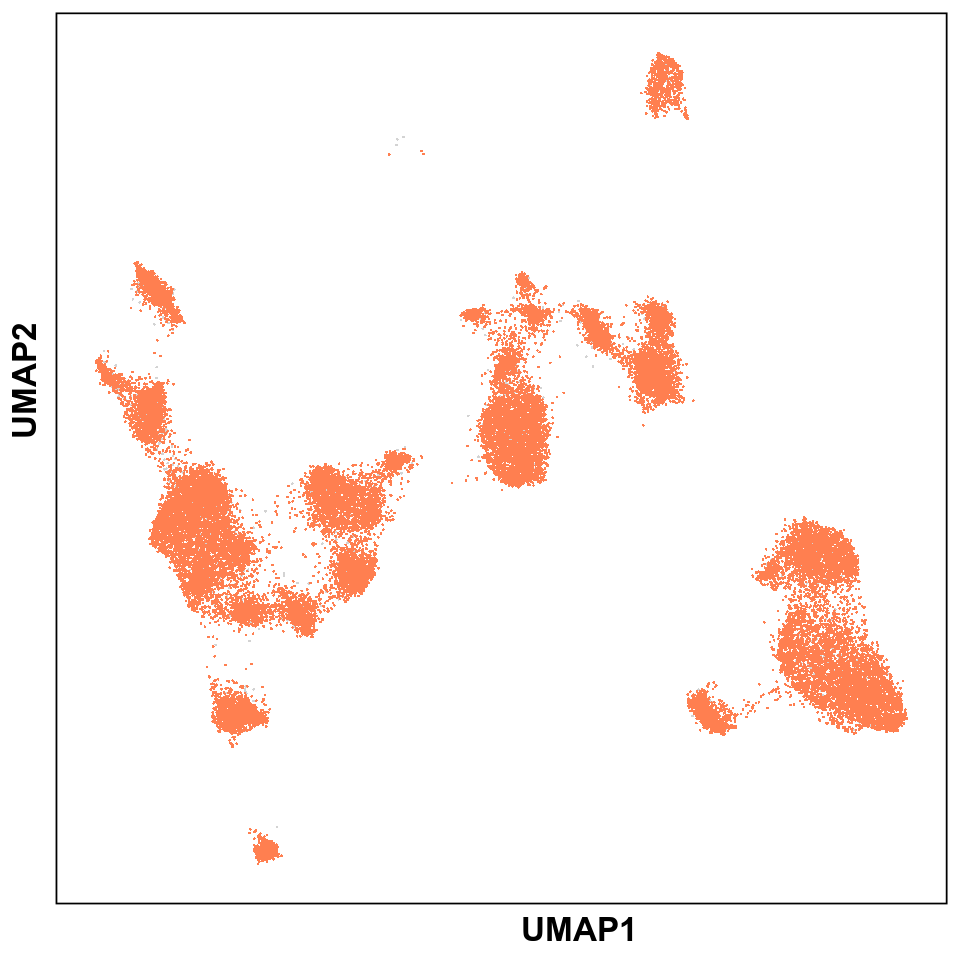

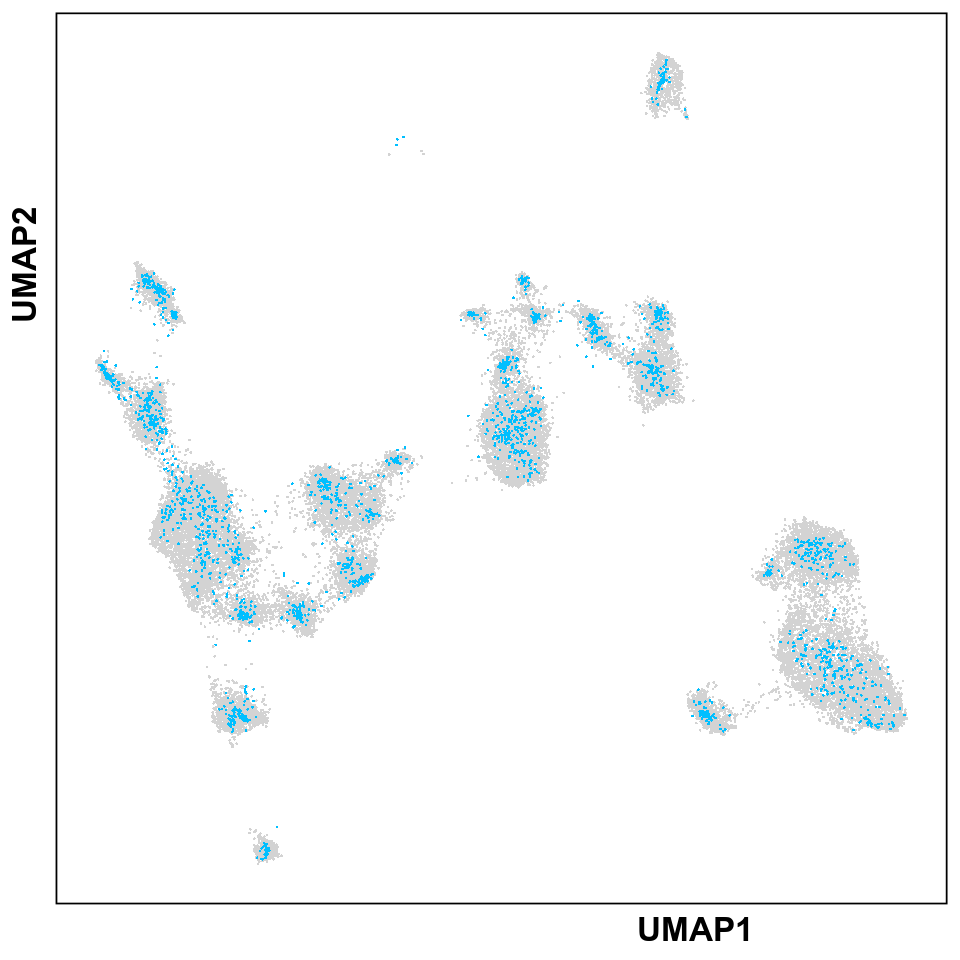

In [3]:
options(repr.plot.height = 8, repr.plot.width = 8)
ggplot() +
  geom_point(
    data=select(qcd_meta, c(hUMAP1, hUMAP2, dataset)),
    aes(x = hUMAP1, y = hUMAP2),
    size = 0.75, stroke = 0.0001, color = "lightgrey"
  ) + 
  geom_point(
    data=qcd_meta %>% filter(dataset == "scRNAseq") %>% select(hUMAP1, hUMAP2),
    aes(x = hUMAP1, y = hUMAP2),
    size = 0.75, stroke = 0.0001, color = "coral"
  ) +
theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
        #  plot.title = element_text(hjust = 0.5, 
        #                            size = 18, 
        #                            face = "bold"),
          axis.title = element_text(hjust = 0.6, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +     labs(x = "UMAP1", y = "UMAP2") 


ggplot() +
  geom_point(
    data=select(qcd_meta, c(hUMAP1, hUMAP2, dataset)),
    aes(x = hUMAP1, y = hUMAP2),
    size = 0.75, stroke = 0.0001, color = "lightgrey"
  ) + 
  geom_point(
    data=qcd_meta %>% filter(dataset == "snRNAseq") %>% select(hUMAP1, hUMAP2),
    aes(x = hUMAP1, y = hUMAP2),
    size = 0.75, stroke = 0.0001, color = "deepskyblue"
  ) +
theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
        #  plot.title = element_text(hjust = 0.5, 
        #                            size = 18, 
        #                            face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +     labs(x = "UMAP1", y = "UMAP2") 

### Cluster UMAPs

In [18]:
qcd_meta <- qcd_meta %>% filter(new_cluster_number != 12)

In [19]:
qcd_meta <- qcd_meta %>% mutate(new_cluster_number = ifelse(new_cluster_number > 12, new_cluster_number - 1, new_cluster_number))

In [30]:
saveRDS(qcd_meta, '/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_NK_clusterQCd_meta_harmonizedPCUMAPclusters_annotations02062024.rds')

In [20]:
cluster_center <- qcd_meta %>%
                  group_by(new_cluster_number) %>%
                  summarise_at(vars(hUMAP1, hUMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


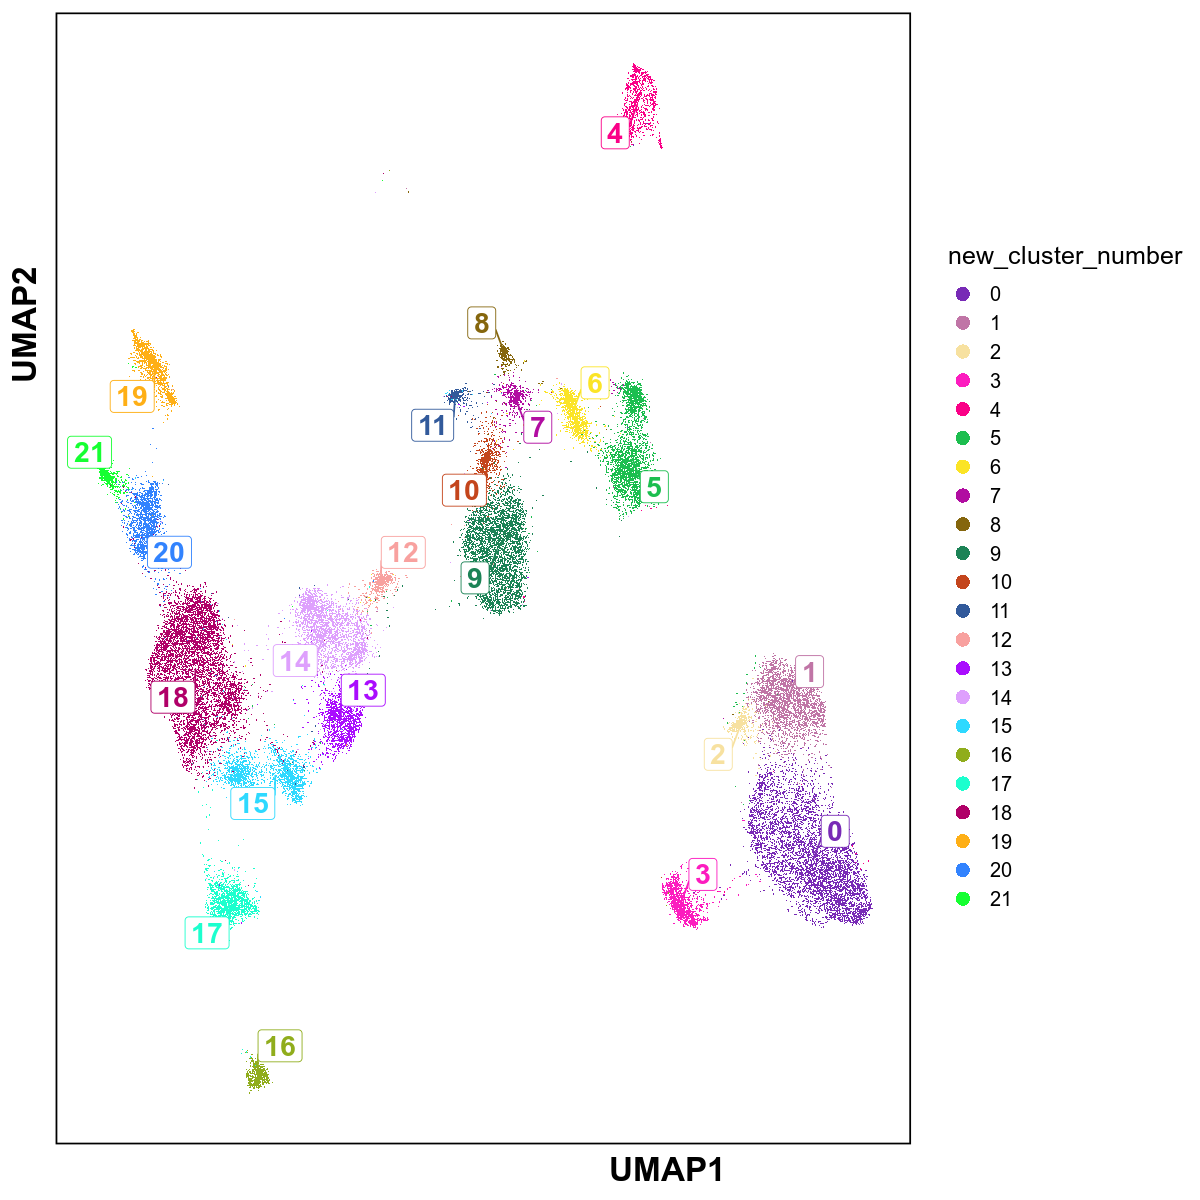

In [28]:
options(repr.plot.height = 8, repr.plot.width = 8)



options(repr.plot.height = 10, repr.plot.width = 10)

ggplot() +
  geom_point(
    data = qcd_meta[sample(nrow(qcd_meta)), ] %>% 
      select(hUMAP1, hUMAP2, new_cluster_number) %>% 
              mutate(new_cluster_number = as.factor(new_cluster_number)),
    aes(x = hUMAP1, y = hUMAP2, color = new_cluster_number),
      size = 0.6, shape = 20, stroke = 0.0001) +
  ggrepel::geom_label_repel(
    data = cluster_center,
    aes(x = hUMAP1, y = hUMAP2, 
        label = new_cluster_number, color = as.factor(new_cluster_number)),
    size = 6,  fontface = "bold",
    box.padding = unit(0.5, "lines"),
    point.padding = unit(0.01, "lines"),
    show.legend = FALSE
  ) +
    scale_color_manual(values =as.vector(rev(polychrome(26)))) +
theme_classic(base_size = 15) +
  theme(
   # legend.position = "none",
        #  plot.title = element_text(hjust = 0.5, 
        #                            size = 18, 
        #                            face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x = "UMAP1", y = "UMAP2") +
    guides(color = guide_legend(ncol = 1, override.aes = list(size = 6)))

### Marker Gene UMAPs

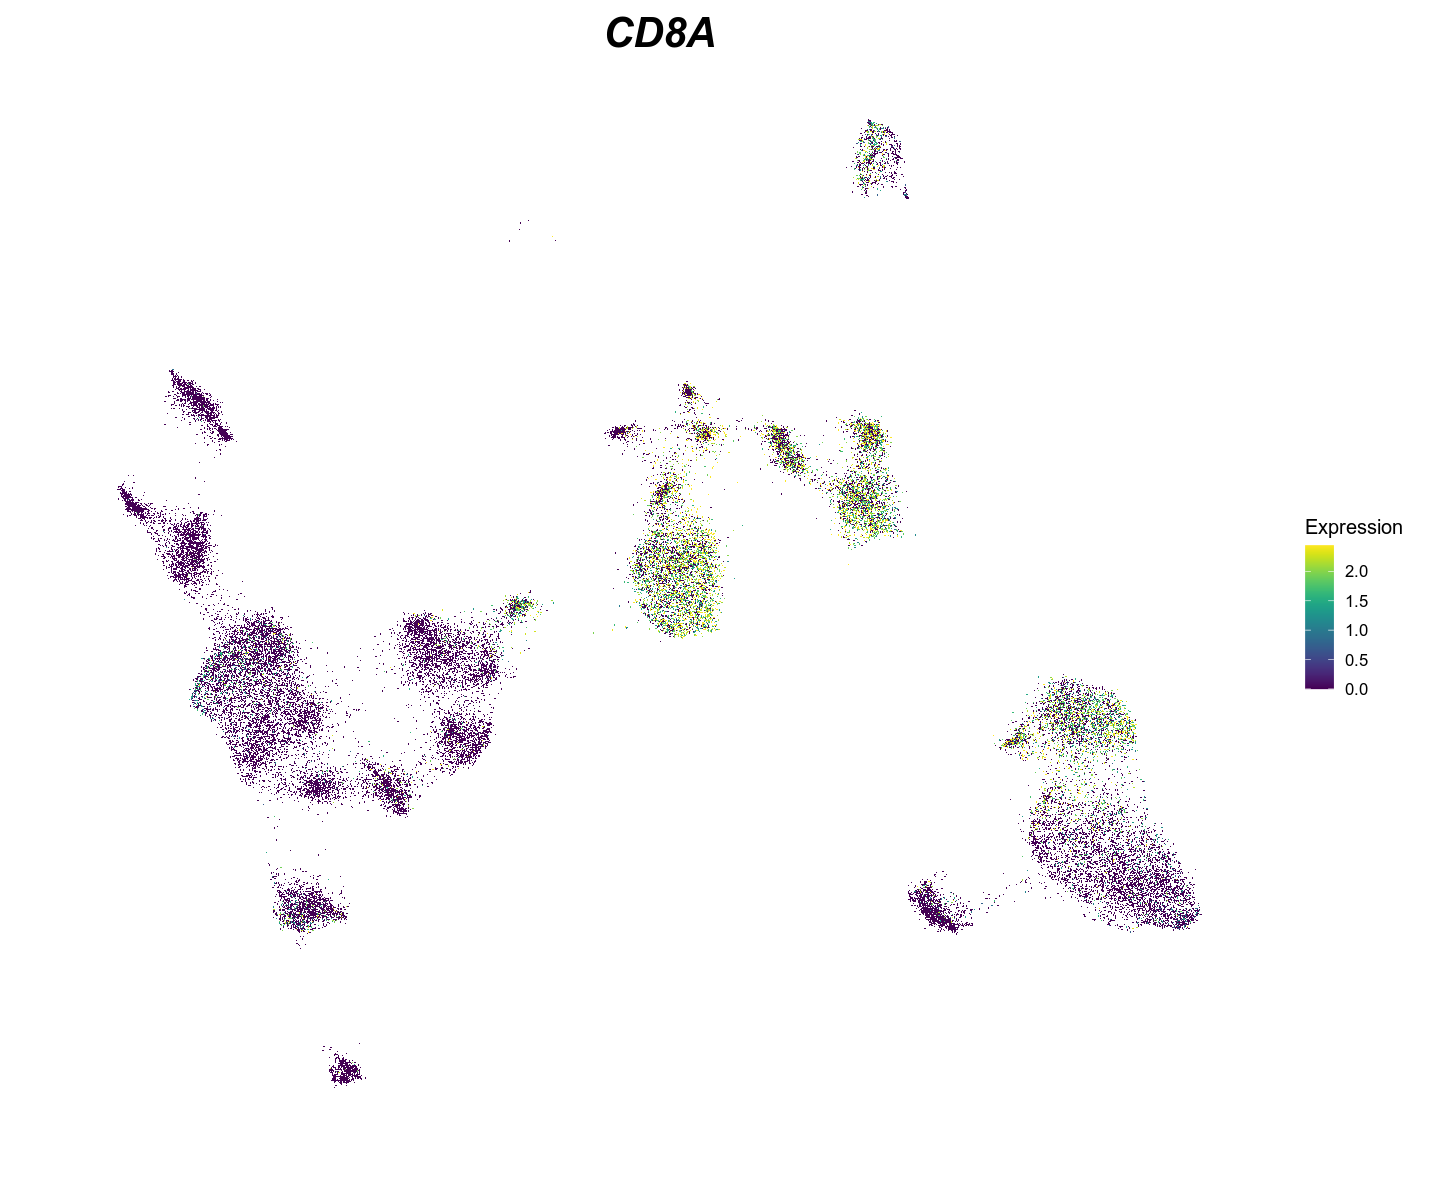

In [7]:
fig.size(10, 12)
plot_shuffled_features(qcd_meta, 
                       qcd_norm, "CD8A", pct = 0.95, pt_size = 0.6)

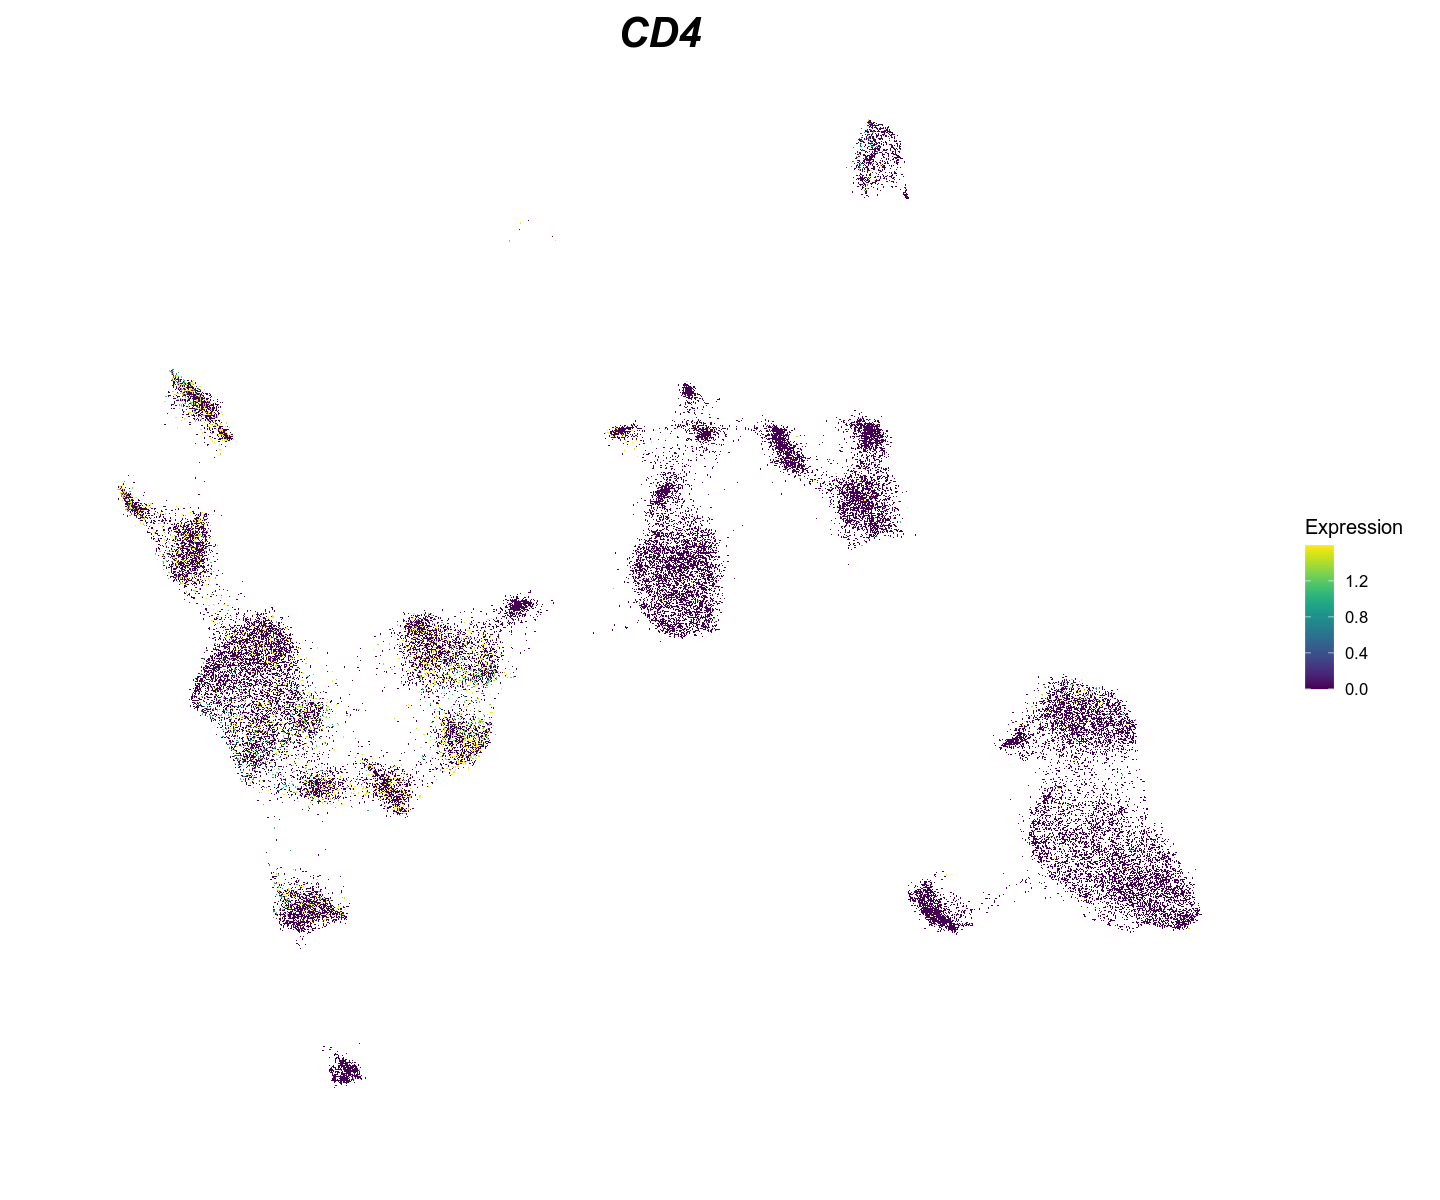

In [6]:
fig.size(10, 12)
plot_shuffled_features(qcd_meta, 
                       qcd_norm, "CD4", pct = 0.95, pt_size = 0.6)

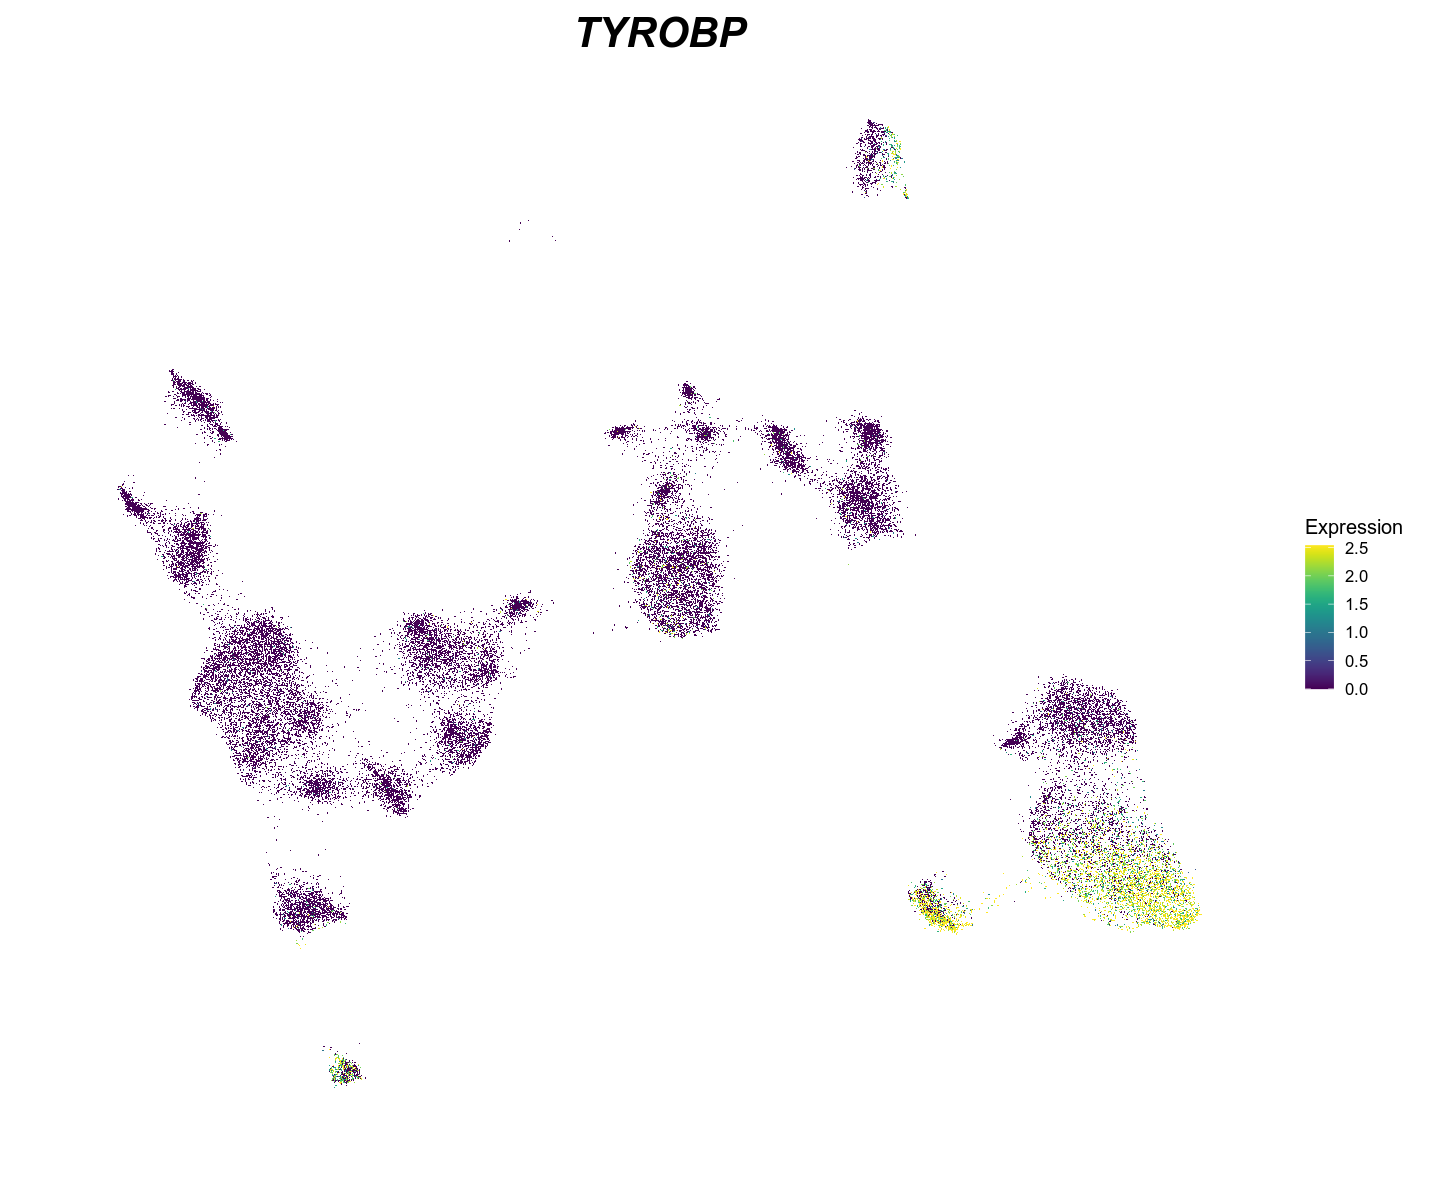

In [10]:
plot_shuffled_features(qcd_meta, 
                       qcd_norm, "TYROBP", pct = 0.95, pt_size = 0.6)

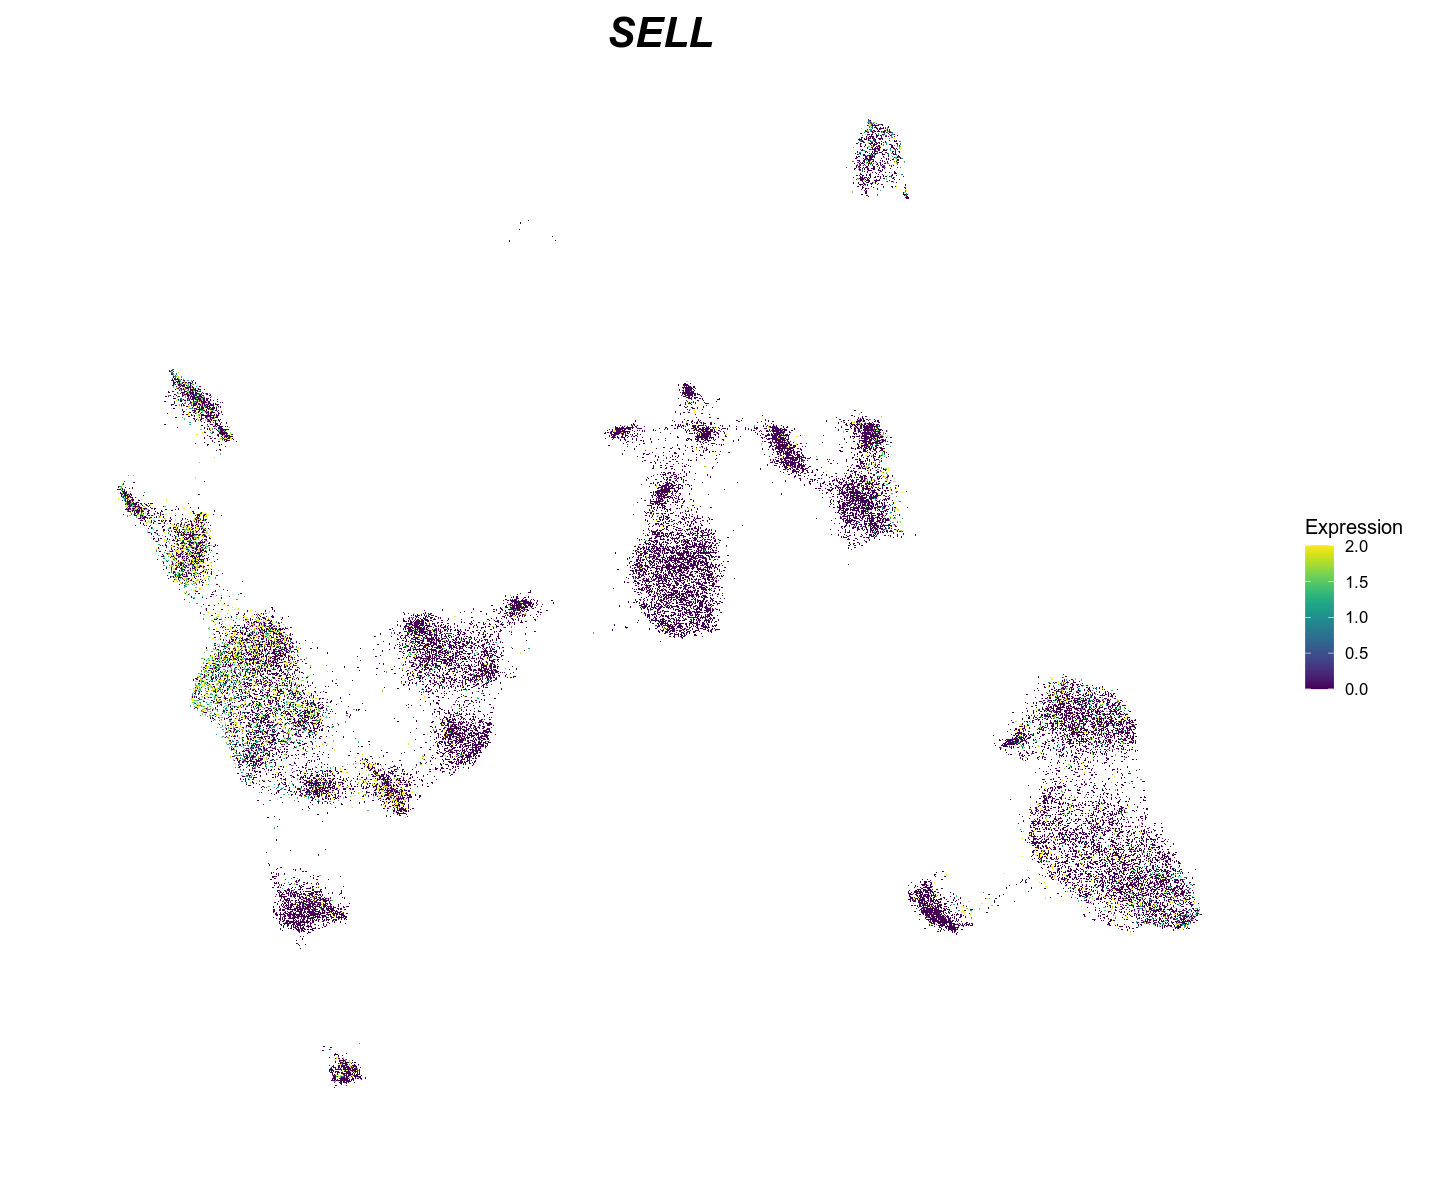

In [11]:
plot_shuffled_features(qcd_meta, 
                       qcd_norm, "SELL", pct = 0.95, pt_size = 0.6)

### sc vs sn heatmaps

In [3]:
final_annotation = data.frame(new_cluster_number = seq(0, 21), 
                                           final_annotation = c("NK0. CD56dim NK",
                                                                 "T1. CD8+ GZMB+ CTL",
                                                                 "T2. CD8+ GZMB+ SYNE2bright CTL",
                                                                 "NK3. CD56bright NK",
                                                                 "T4. CENPF+ MKI67+ Proliferating",
                                                                 "T5. GZMK+ CD8+ NKG7high",
                                                                 "T6. GZMK+ CD8+ NKG7low",
                                                                 "T7. GZMK+ CD8+ Effector Memory",
                                                                 "T8. GZMK+ CD8+ NEAT1+",
                                                                 "T9. GZMK+ CD8+ Resident Memory",
                                                                 "T10. GZMK+ CD8+ ITGAE",
                                                                 "T11. CD4+ Effector Memory",
                                                                 "T12. CD8+ GMZK+ CD69+",
                                                                 "T13. CD4+ JUNlow Resident Memory",
                                                                 "T14. CD4+ JUNhigh Resident Memory",
                                                                 "T15. CD4+ S1PR1+ Central memory/Naive",
                                                                 "T16. KLRB1+ KIT+ ILC",
                                                                 "T17. CD4+ RORC+ CCR6+ Th17",
                                                                 "T18. CD4+ Central Memory/Naive",
                                                                 "T19. CD4+ IL2RA++ FOXP3++ Treg",
                                                                 "T20. CD4+ FOXP3+ Central Memory/Naive",
                                                                 "T21. CD4+ PDCD1+ CXCR5+ TFH/TPH"))

qcd_meta <- qcd_meta %>% left_join(final_annotation)

Joining, by = "new_cluster_number"


In [4]:
marker_genes <- c("NCAM1", "TYROBP", "PRF1", "GZMK", "GZMB", "SYNE2", "CD3D", "CD4", "CD8A", "CENPF", "MKI67", "NKG7", 
                 "CD28", "CCR7", "SELL", "ITGAE", "NEAT1", "S1PR1", "CD69", "JUN", "KLRB1", "KIT", "IL1R1", "IL7R",
                  "RORC", "CCR6", "IL2RA", "FOXP3", "PDCD1", "CXCR5")

In [5]:
wilcox_sn <- wilcoxauc(qcd_norm[, qcd_meta %>% filter(dataset == 'snRNAseq') %>% pull(cell)], 
                       qcd_meta %>% filter(dataset == 'snRNAseq') %>% pull(final_annotation))
wilcox_sc <- wilcoxauc(qcd_norm[, qcd_meta %>% filter(dataset == 'scRNAseq') %>% pull(cell)], 
                       qcd_meta %>% filter(dataset == 'scRNAseq') %>% pull(final_annotation))

In [6]:
sc_plot_df <- wilcox_sc %>%  filter(feature %in% marker_genes) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 
sn_plot_df <- wilcox_sn %>%  filter(feature %in% marker_genes) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 

In [29]:
range(sc_plot_df$logFC)
range(sn_plot_df$logFC)

[1] -1.746726  2.794455

[1] -1.001819  1.484500

In [11]:
sc_plot_df %>% filter(feature == "MKI67")

group                                 feature logFC       avgExpr    
1  NK0. CD56dim NK                       MKI67   -0.03793257 0.012915585
2  NK3. CD56bright NK                    MKI67   -0.03217692 0.014485585
3  T1. CD8+ GZMB+ CTL                    MKI67   -0.03468732 0.013307044
4  T10. GZMK+ CD8+ ITGAE                 MKI67   -0.03020049 0.015950310
5  T11. CD4+ Effector Memory             MKI67   -0.02471195 0.021170105
6  T12. CD8+ GMZK+ CD69+                 MKI67   -0.03824951 0.007940770
7  T13. CD4+ JUNlow Resident Memory      MKI67   -0.03868093 0.008350024
8  T14. CD4+ JUNhigh Resident Memory     MKI67   -0.04501983 0.003744229
9  T15. CD4+ S1PR1+ Central memory/Naive MKI67   -0.04239981 0.005291201
10 T16. KLRB1+ KIT+ ILC                  MKI67   -0.04635194 0.000000000
11 T17. CD4+ RORC+ CCR6+ Th17            MKI67   -0.04754468 0.000000000
12 T18. CD4+ Central Memory/Naive        MKI67   -0.05034273 0.003380700
13 T19. CD4+ IL2RA++ FOXP3++ Treg        MKI67   -0.04208536 0.004992742
14 T2. CD8+ GZMB+ SYNE2bright CTL        MKI67   -0.01682656 0.029009181
15 T20. CD4+ FOXP3+ Central Memory/Naive MKI67   -0.04474484 0.002809341
16 T21. CD4+ PDCD1+ CXCR5+ TFH/TPH       MKI67   -0.02745596 0.018606465
17 T4. CENPF+ MKI67+ Proliferating       MKI67    1.42192092 1.432925812
18 T5. GZMK+ CD8+ NKG7high               MKI67   -0.01503324 0.031766630
19 T6. GZMK+ CD8+ NKG7low                MKI67   -0.03461370 0.012011085
20 T7. GZMK+ CD8+ Effector Memory        MKI67   -0.02034929 0.025576030
21 T8. GZMK+ CD8+ NEAT1+                 MKI67   -0.01130033 0.034445252
22 T9. GZMK+ CD8+ Resident Memory        MKI67   -0.03565185 0.013665041
   pct_in     avgExpr_scaled
1   0.8310825 -0.2143709    
2   1.0869565 -0.2091865    
3   0.9692373 -0.2130782    
4   0.8605852 -0.2043497    
5   0.9146341 -0.1871130    
6   0.4040404 -0.2307985    
7   0.6384677 -0.2294471    
8   0.2470152 -0.2446562    
9   0.2366864 -0.2395479    
10  0.0000000 -0.2570203    
11  0.0000000 -0.2570203    
12  0.2662879 -0.2458567    
13  0.5037783 -0.2405334    
14  1.5584416 -0.1612271    
15  0.2008032 -0.2477434    
16  1.3307985 -0.1955786    
17 74.4158879  4.4747431    
18  2.1236960 -0.1521215    
19  0.8097166 -0.2173577    
20  1.2684989 -0.1725639    
21  1.3651877 -0.1432763    
22  0.9136213 -0.2118960

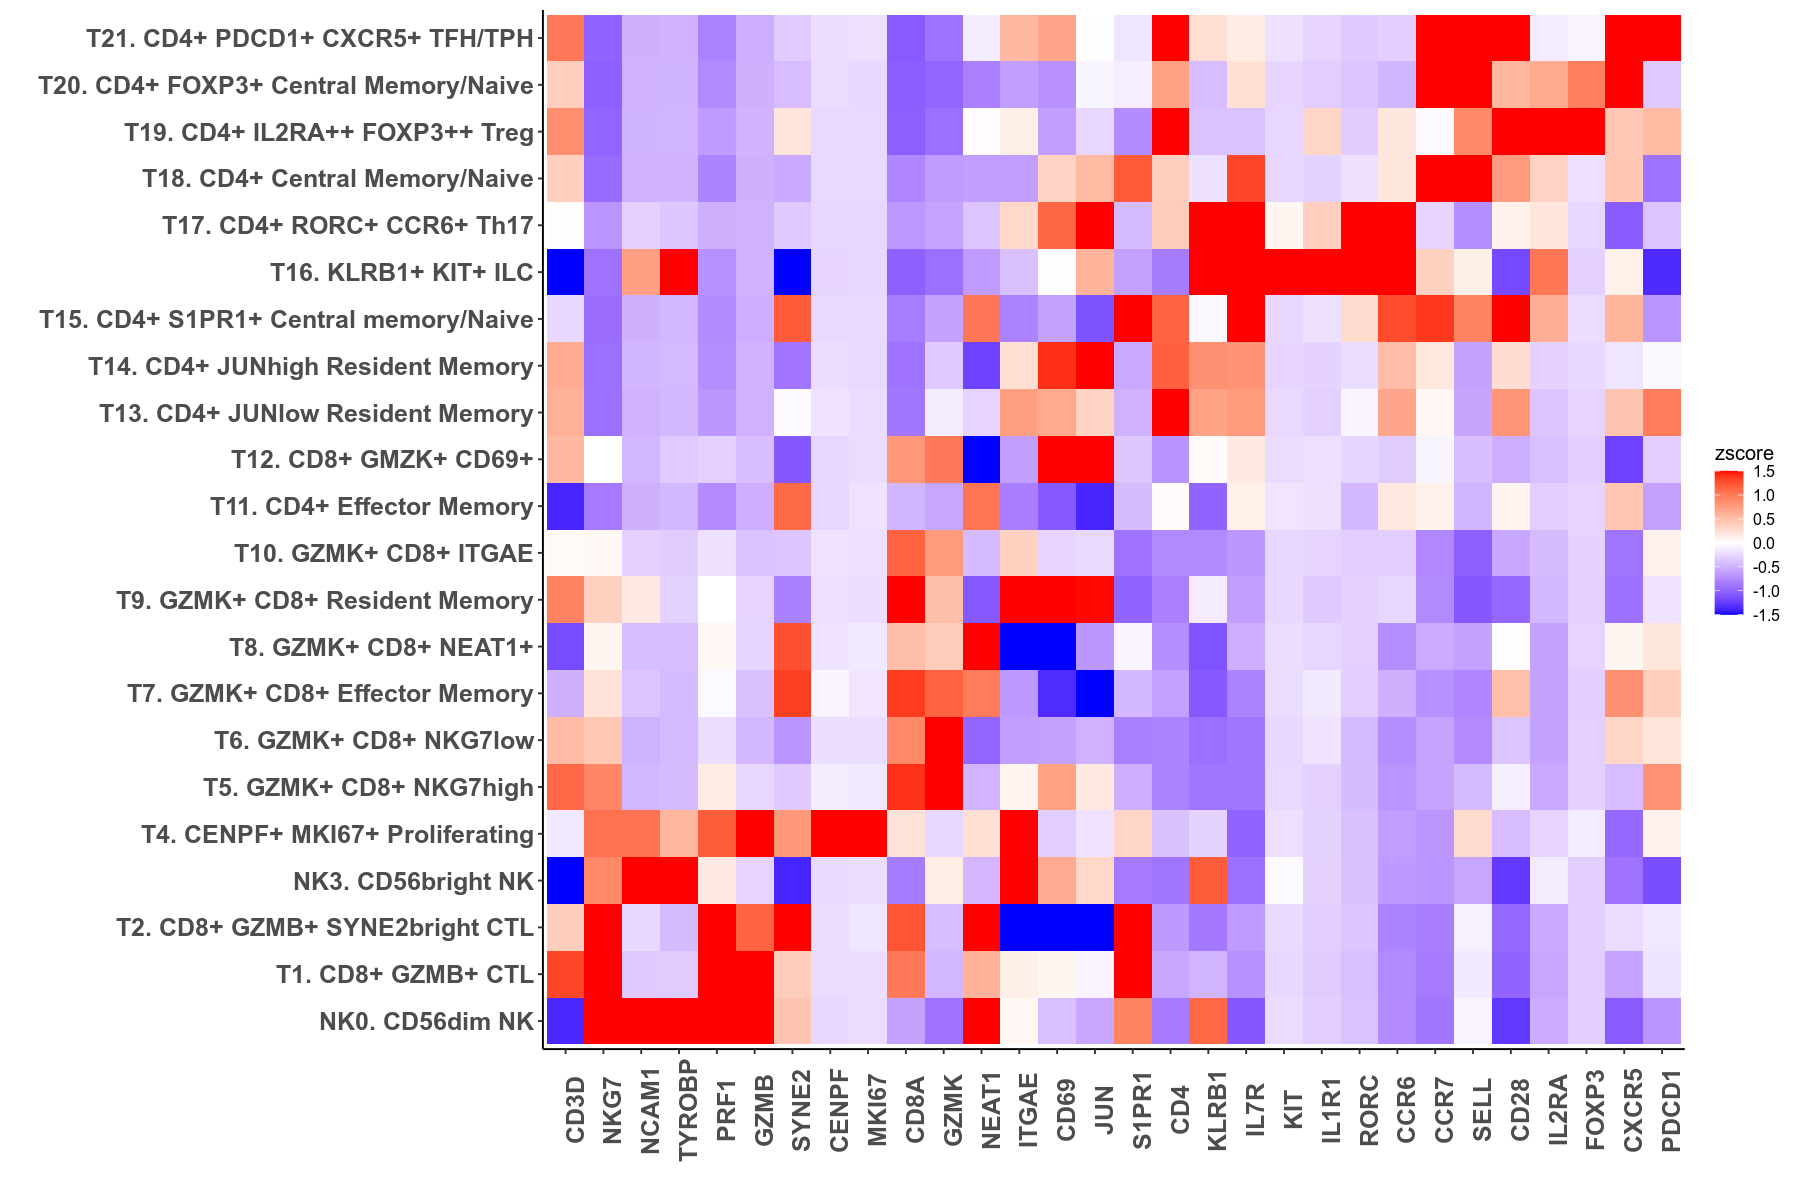

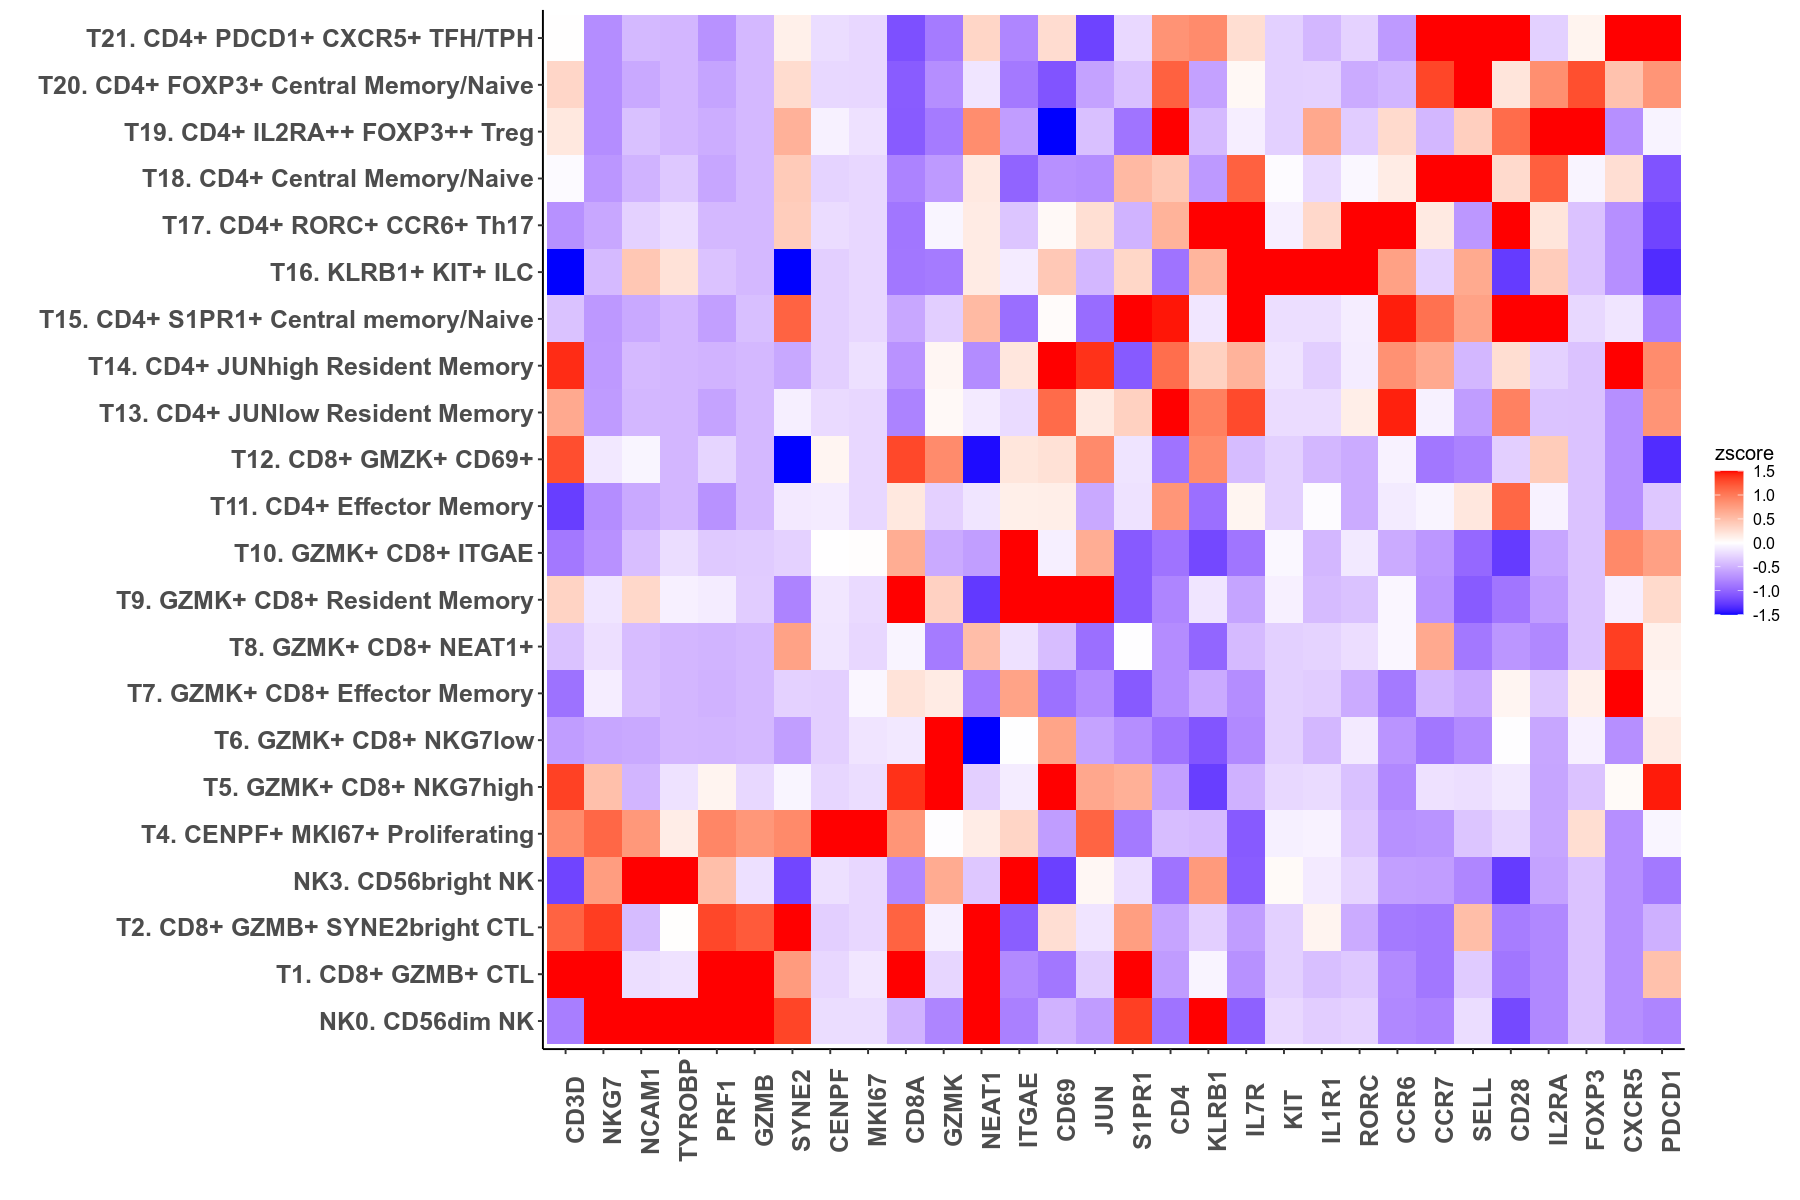

In [35]:
fig.size(10, 15)
ggplot(sc_plot_df %>% rename(percent = pct_in,
                             zscore = avgExpr_scaled), 
               aes(x = feature, y = group, 
                   fill = zscore)) + 
    geom_tile() + 
    theme_classic(base_size = 12) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(-1.5, 1.5), 
                         oob = scales::squish) + 
    scale_x_discrete(limits = marker_genes) + 
    scale_y_discrete(limits = final_annotation$final_annotation) + 
    theme(axis.text.x = element_text(angle = 90),
          axis.text = element_text(face = "bold", size = 15),
          axis.title = element_text(size = 15)) + 
    labs(x = "", y = "")
fig.size(10, 15)
ggplot(sn_plot_df %>% rename(percent = pct_in,
                             zscore = avgExpr_scaled), 
               aes(x = feature, y = group, 
                   fill = zscore)) + 
    geom_tile() + 
    theme_classic(base_size = 12) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(-1.5, 1.5), 
                         oob = scales::squish) + 
    scale_x_discrete(limits = marker_genes) + 
    scale_y_discrete(limits = final_annotation$final_annotation) + 
    theme(axis.text.x = element_text(angle = 90),
          axis.text = element_text(face = "bold", size = 15),
          axis.title = element_text(size = 15)) + 
    labs(x = "", y = "")

### Cluster Proportions in Matched Patients

In [123]:
qcd_meta <- qcd_meta  %>% 
                mutate(individual = str_split(sample, '_')) %>% 
                rowwise() %>% 
                mutate(individual = unlist(individual)[3]) 

In [124]:
sample_freq <- qcd_meta %>% select(dataset, individual, new_cluster_number) %>% 
                    table() %>% data.frame() %>% 
                    pivot_wider(names_from = "new_cluster_number", values_from = Freq) 

In [125]:
ind_list <- qcd_meta %>% select(dataset, individual) %>% 
                table() %>% data.frame() %>% 
                pivot_wider(names_from = 'dataset', values_from = "Freq") %>% filter(scRNAseq > 40 & snRNAseq > 40) %>% 
                pull(individual)

In [126]:
sample_freq_sc <- sample_freq %>% 
                    filter(individual %in% ind_list) %>% 
                    select(- individual) %>% 
                    filter(dataset == "scRNAseq") %>% 
                    select(-dataset) %>% colSums()

sample_freq_sn <- sample_freq %>% 
                    filter(individual %in% ind_list) %>% 
                    select(- individual) %>% 
                    filter(dataset == "snRNAseq") %>% 
                    select(-dataset) %>% colSums()

In [127]:
sample_freq <- data.frame(rep("a", 22))
sample_freq$sc_freq <- sample_freq_sc / sum(sample_freq_sc)
sample_freq$sc_se <- sqrt((sample_freq$sc_freq * (1 - sample_freq$sc_freq)) / sample_freq_sc)
sample_freq$sn_freq <- sample_freq_sn / sum(sample_freq_sn)
sample_freq$sn_se <- sqrt((sample_freq$sn_freq * (1 - sample_freq$sn_freq)) / sample_freq_sn)
sample_freq <- sample_freq[,- 1]
sample_freq$new_cluster_number <- as.character(seq(0, 21))

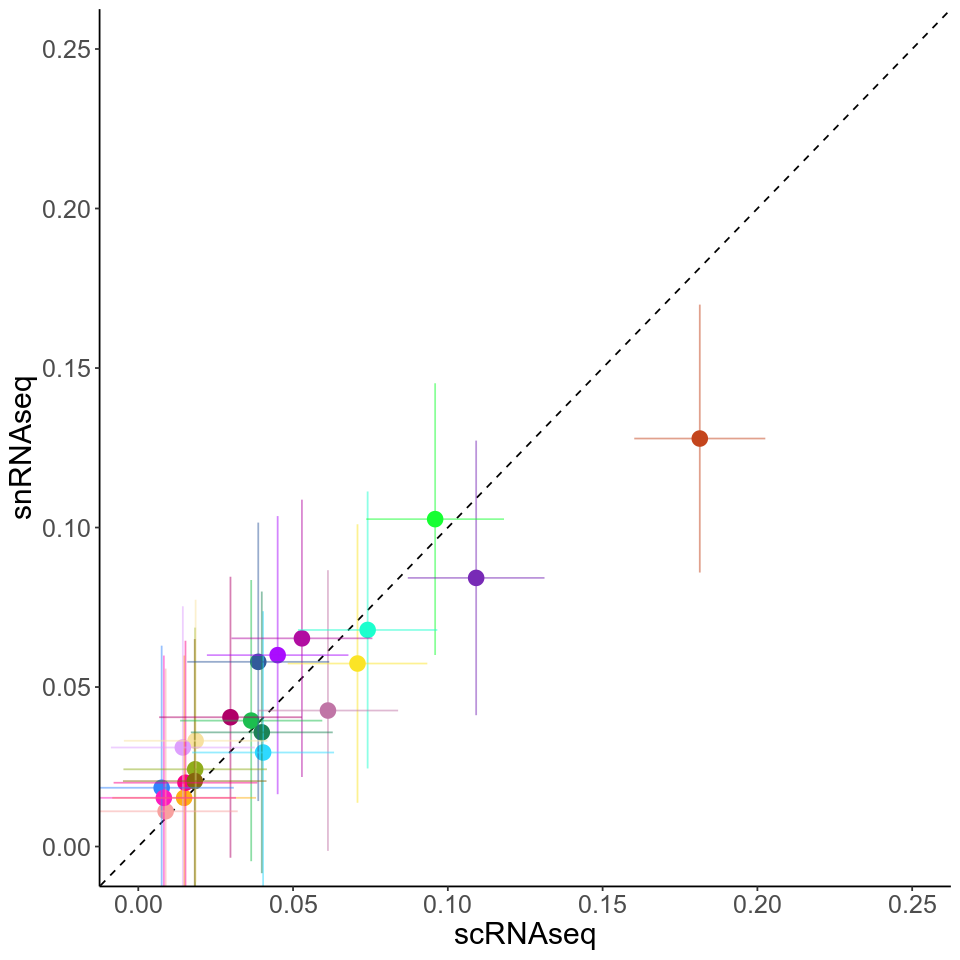

In [128]:

fig.size(8, 8)

max_val <- max(sample_freq[, c("sc_freq", "sn_freq")])

ggplot(sample_freq, aes(x = sc_freq, y = sn_freq, color = new_cluster_number)) + 
    geom_abline(linetype = "dashed") +
    scale_color_manual(values =as.vector(rev(polychrome(26)))) +
    theme_classic() + 
    geom_point(size = 4) + 
    geom_linerange(aes(ymax = sn_freq+1.96*sn_se, 
                        ymin = sn_freq-1.96*sn_se), alpha = 0.5) +
    geom_linerange(aes(xmax = sc_freq+1.96*sc_se, 
                        xmin = sc_freq-1.96*sc_se), alpha = 0.5) +
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18)) +
    coord_cartesian(xlim = c(0, 0.25), ylim = c(0, 0.25)) + 
    labs(x = "scRNAseq",
         y = "snRNAseq")

In [129]:
cor.test(sample_freq$sc_freq, sample_freq$sn_freq)


	Pearson's product-moment correlation

data:  sample_freq$sc_freq and sample_freq$sn_freq
t = 12.517, df = 20, p-value = 6.428e-11
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8625489 0.9758631
sample estimates:
      cor 
0.9417005 


### sc/sn qq ratio

In [ ]:
## Group by ind, Cell Type, Technology, Pseudobulk log TPM, 
## QQ normalized Value 
## Diff EX for CT Individual Tech (lm)
## lm(QQ norm value ~ sc/sn + Donor + Cell Type) 
## lm(QQ norm value ~ Donor + Cell Type)

In [24]:
qcd_meta <- qcd_meta %>% 
                        mutate(individual = str_split(sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3])

In [25]:
ind_meta <- qcd_meta %>% filter(Type == "Control") %>% 
                    select(individual, dataset) %>% 
                    table() %>% data.frame() 

In [26]:
ind_keep <- vector() 

for (i in unique(ind_meta$individual)) {
    ind_subset <- ind_meta %>% filter(individual == i)
        if (all(ind_subset$Freq > 0)) {
            ind_keep <- c(ind_keep, i)
        }
}

In [27]:
qq_pb_sc <- data.frame(nrow = nrow(qcd_norm))
individuals_sc <- vector()

for (i in ind_keep) {
            subset <- qcd_meta %>% filter(individual == i, 
                                                 dataset == "scRNAseq") %>% 
                        pull(cell)
            if(length(subset) > 1) {
                pb_vec <- rowMeans(qcd_norm[, subset])
                }
            else {
                pb_vec <- qcd_norm[, subset]
            }
            qq_pb_sc <- cbind(qq_pb_sc, pb_vec)
            individuals_sc <- c(individuals_sc, i)
}

qq_pb_sn <- data.frame(nrow = nrow(qcd_norm))
individuals_sn <- vector()

for (i in ind_keep) {
    subset <- qcd_meta %>% filter(individual == i, 
                                                 dataset == "snRNAseq") %>% 
                        pull(cell)
            if(length(subset) > 1) {
                pb_vec <- rowMeans(qcd_norm[, subset])
                }
            else {
                pb_vec <- qcd_norm[, subset]
            }
            qq_pb_sn <- cbind(qq_pb_sn, pb_vec)
            individuals_sn <- c(individuals_sn, i)
}

In [28]:
qq_pb_sc <- qq_pb_sc[, -1]
qq_pb_sn <- qq_pb_sn[, -1]

In [29]:
colnames(qq_pb_sc) <- paste0(individuals_sc, "_sc")
colnames(qq_pb_sn) <- paste0(individuals_sn, "_sn")

In [30]:
qq_pb <- cbind(qq_pb_sc, qq_pb_sn)

In [31]:
index_to_mean <- function(my_index, my_mean){
  return(my_mean[my_index])
}
df_rank <- apply(qq_pb,2,rank,ties.method="first")
df_sort <- data.frame(apply(qq_pb, 2, sort))
df_mean <- apply(df_sort, 1, mean)
df_final <- apply(df_rank, 2, index_to_mean, my_mean=df_mean)

In [32]:
df_final <- t(df_final) %>% data.frame()

In [33]:
df_final <- df_final %>% mutate(ind = sapply(rownames(df_final), 
                              FUN = function(x) unlist(str_split(x, "_"))[1]),
                    technology = sapply(rownames(df_final), 
                              FUN = function(x) unlist(str_split(x, "_"))[2]))

In [34]:
#out <- data.frame()
qq_lm <- function(gene, df_final) {
    i = which(rownames(qcd_norm) == gene)
    model_df <- cbind(df_final[, i], df_final %>% select(ind, technology))
    colnames(model_df) <- c('Exp', 'ind', 'technology')
    H0 <- lm(Exp ~ ind, data = model_df)
    H1 <- lm(Exp ~ ind + technology, data = model_df)
    ANNO <- anova(H0, H1)
    LRP <- ANNO[2,6]
    F <- ANNO[2,5]
    Beta <- summary(H1)$coefficients['technologysn', 'Estimate']
    SE <- summary(H1)$coefficients['technologysn', 'Std. Error']
    res <- c(gene = gene, LRP = LRP, F = F, Beta = Beta, SE = SE)
    return(res)
}

In [35]:
out <- lapply(rownames(qcd_norm), qq_lm, df_final)

Warning message in summary.lm(H1):
“essentially perfect fit: summary may be unreliable”
Warning message in summary.lm(H1):
“essentially perfect fit: summary may be unreliable”


In [36]:
out <-  as.data.frame(do.call(rbind, out))
out[out == 'NaN'] <- NA
out_filter <- out %>% na.omit() %>% 
                mutate(LRP = as.numeric(LRP),
                       F = as.numeric(F),
                       Beta = as.numeric(Beta),
                       SE = as.numeric(SE)) %>% 
                mutate(FDR = p.adjust(LRP, method = "BH"))

In [ ]:
out_filter

Warning message:
“Removed 266 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 82 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


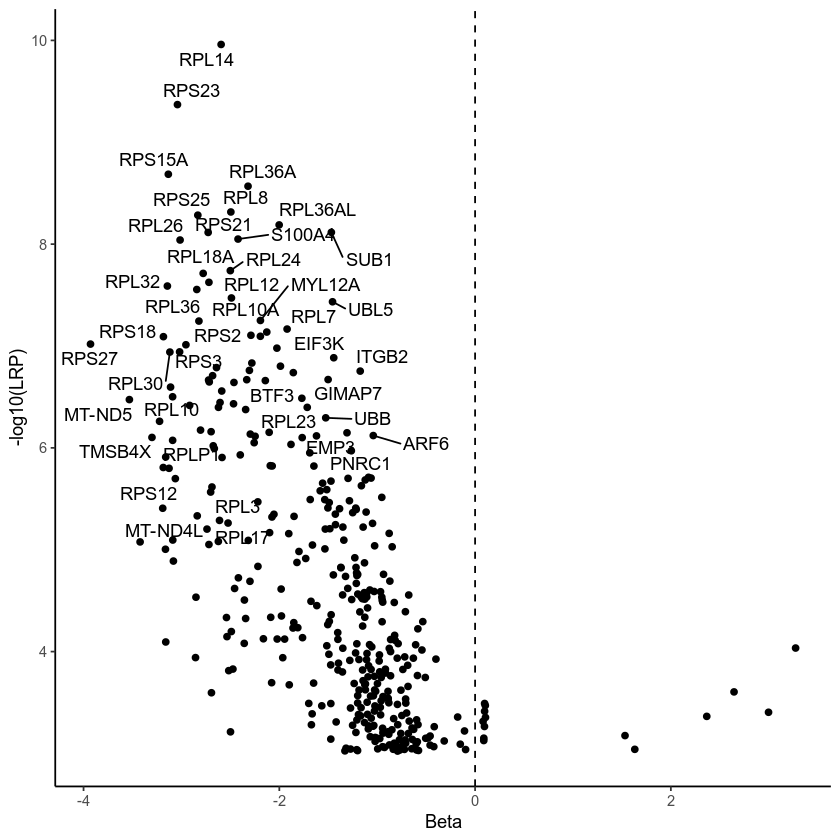

In [37]:
ggplot(out_filter %>% filter(FDR < 0.05) %>% 
           mutate(label = ifelse(-log10(FDR) > 3, gene, NA)), aes(x = Beta, y = -log10(LRP))) + 
    geom_point() + 
    geom_vline(aes(xintercept = 0), linetype = "dashed") + 
    theme_classic() + 
    ggrepel::geom_text_repel(aes(label = label))

In [296]:
library(msigdbr)
library(fgsea)

##format for gsea 
FC.vec <- out_filter$Beta
names(FC.vec) <- out_filter$gene

scoreType <- "std"

H <- msigdbr(species = "Homo sapiens", category = "H")

H.ensembl.ls <- H %>% 
  select(gs_name, gene_symbol) %>% 
  group_by(gs_name) %>% 
  summarise(all.genes = list(unique(gene_symbol))) %>% 
  tibble::deframe()

#Run GSEA
gsea.H <- fgseaSimple(pathways = H.ensembl.ls,
                      stats = FC.vec,
                      scoreType = scoreType,
                      nperm=10000)

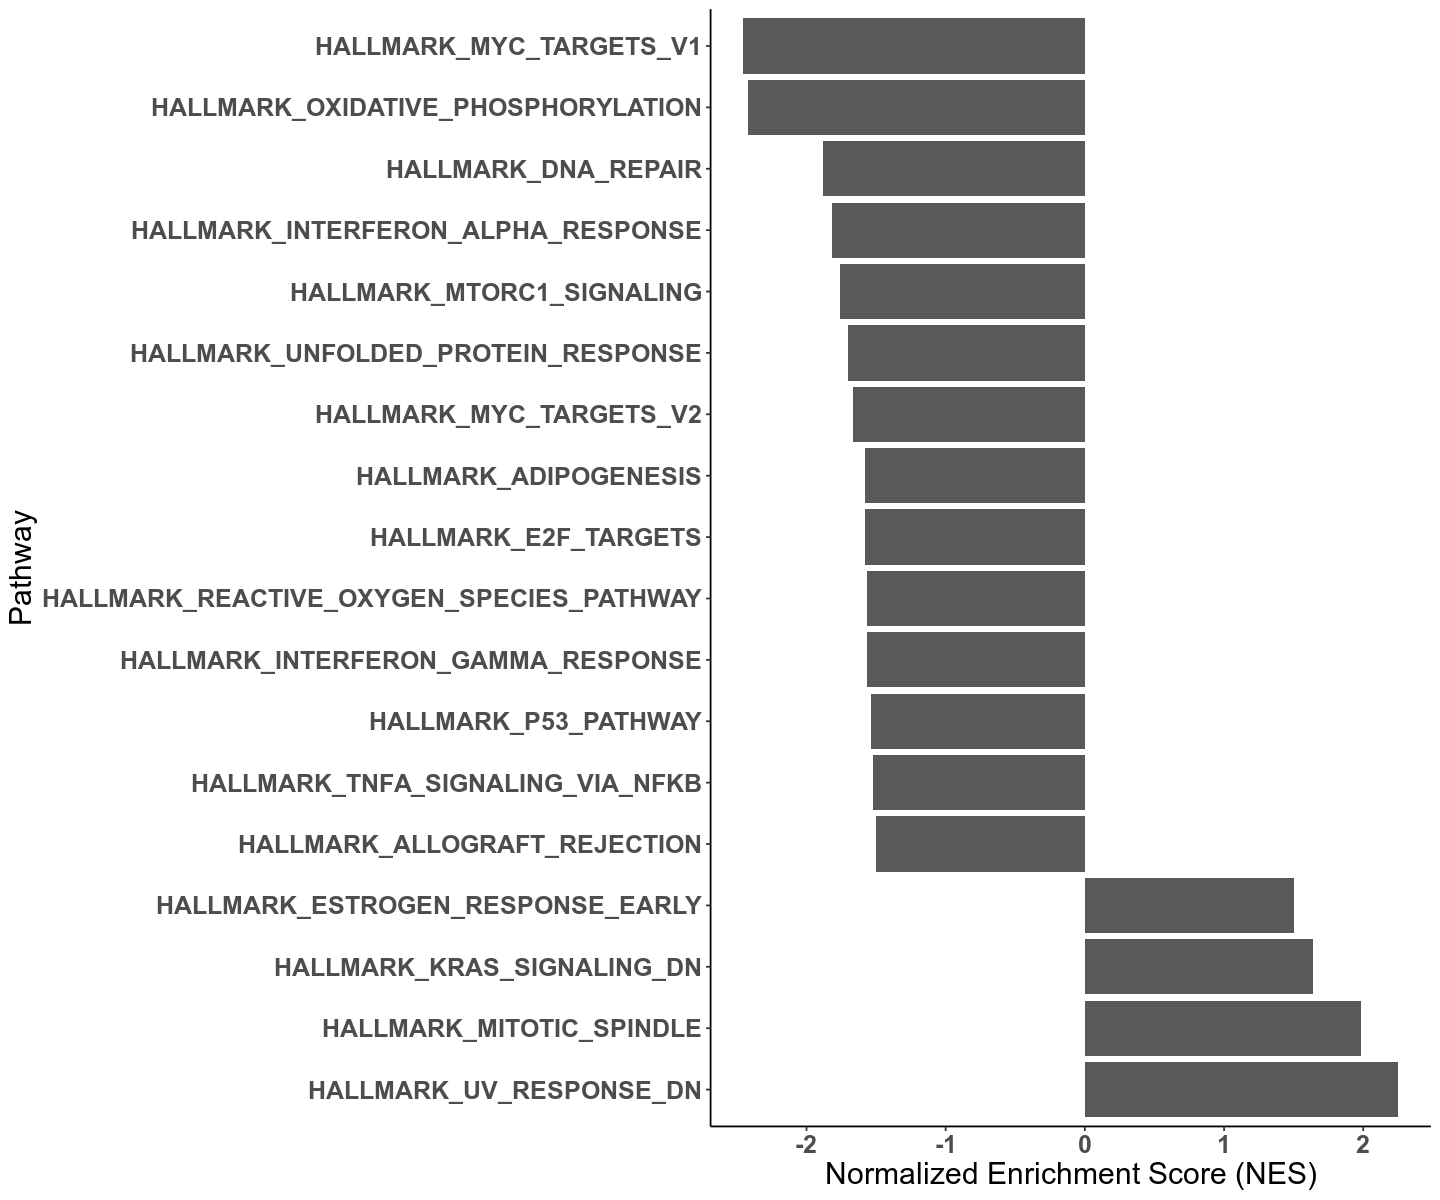

In [297]:
fig.size(10,12)
ggplot(gsea.H %>% filter(padj < 0.05), aes(x = NES, y = pathway)) +
    geom_bar(stat = "identity") +
    theme_classic() + 
    scale_y_discrete(limits = gsea.H %>% filter(padj < 0.05) %>% arrange(desc(NES)) %>% pull(pathway)) + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15, face = "bold"),
          axis.title = element_text(size = 18)) +
    labs(x = 'Normalized Enrichment Score (NES)', y = 'Pathway')

In [414]:
ind_meta <- all_immune_meta %>% filter(Type == 'Control') %>% 
                    select(individual, broad_cell_type, dataset) %>% 
                    table() %>% data.frame() 

## Case/Control Figure

In [56]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_NK_clusterQCd_meta_harmonizedPCUMAPclusters_annotations02062024.rds')
tnk_rawcounts <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_NK_clusterQCd_rawcounts_03062023.rds')
mito_genes_subset <- c("MT-ND5", "MT-ND6")
percent_mito <- colSums(tnk_rawcounts[mito_genes_subset, ]) / colSums(tnk_rawcounts) * 100
percent_mito <- data.frame(cell = names(percent_mito), percent.mt = percent_mito)
qcd_meta <- left_join(qcd_meta, percent_mito)
final_annotation = data.frame(new_cluster_number = seq(0, 21), 
                                           final_annotation = c("NK0. CD56dim NK",
                                                                 "T1. CD8+ GZMB+ CTL",
                                                                 "T2. CD8+ GZMB+ SYNE2bright CTL",
                                                                 "NK3. CD56bright NK",
                                                                 "T4. CENPF+ MKI67+ Proliferating",
                                                                 "T5. GZMK+ CD8+ NKG7high",
                                                                 "T6. GZMK+ CD8+ NKG7low",
                                                                 "T7. GZMK+ CD8+ Effector Memory",
                                                                 "T8. GZMK+ CD8+ NEAT1+",
                                                                 "T9. GZMK+ CD8+ Resident Memory",
                                                                 "T10. GZMK+ CD8+ ITGAE",
                                                                 "T11. CD4+ Effector Memory",
                                                                 "T12. CD8+ GMZK+ CD69+",
                                                                 "T13. CD4+ JUNlow Resident Memory",
                                                                 "T14. CD4+ JUNhigh Resident Memory",
                                                                 "T15. CD4+ S1PR1+ Central memory/Naive",
                                                                 "T16. KLRB1+ KIT+ ILC",
                                                                 "T17. CD4+ RORC+ CCR6+ Th17",
                                                                 "T18. CD4+ Central Memory/Naive",
                                                                 "T19. CD4+ IL2RA++ FOXP3++ Treg",
                                                                 "T20. CD4+ FOXP3+ Central Memory/Naive",
                                                                 "T21. CD4+ PDCD1+ CXCR5+ TFH/TPH"))

qcd_meta <- qcd_meta %>% left_join(final_annotation)
sc_meta <- qcd_meta %>% filter(dataset == "scRNAseq")

Joining, by = "cell"
Joining, by = "new_cluster_number"


### CASE/CONTROL BARPLOT

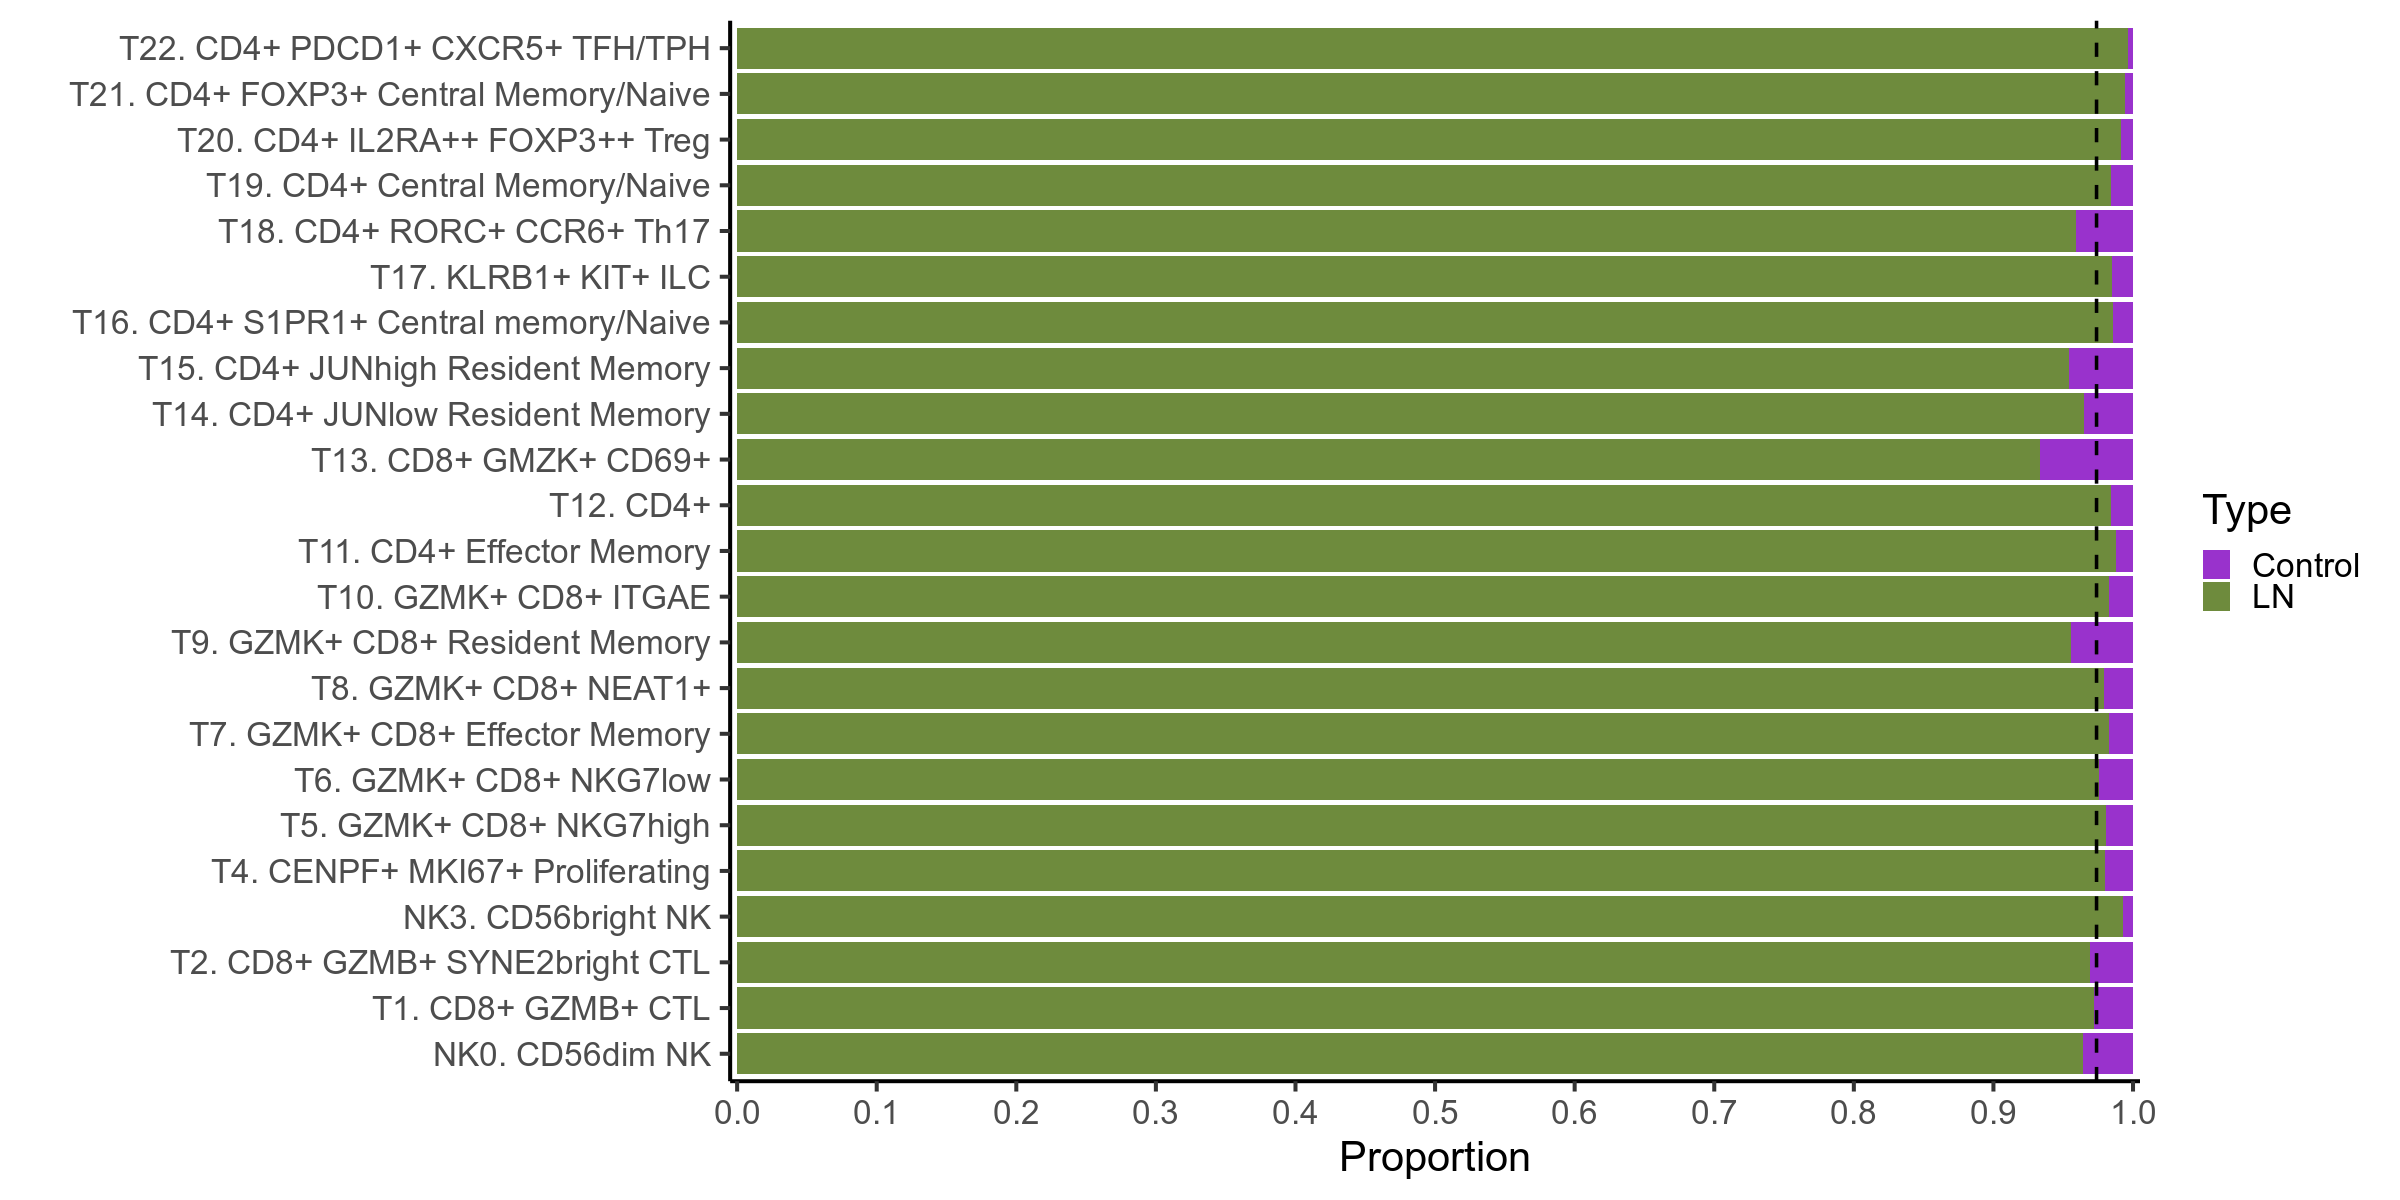

In [63]:
fig.size(10, 20)

total_prop <- qcd_meta %>% filter(dataset == 'scRNAseq') %>% 
                    select(Type) %>% table() %>% data.frame() %>% 
                    mutate(Freq = Freq / sum(Freq)) %>% pull(Freq)
ggplot(qcd_meta %>% filter(dataset == 'scRNAseq') %>% 
            select(Type, final_annotation) %>% 
            table() %>% data.frame() %>% 
            group_by(final_annotation) %>% mutate(prop = Freq/sum(Freq)),
       aes(y = final_annotation, x = prop, fill = Type)) + 
    geom_bar(position = position_fill(),
             stat = "identity") + 
    labs(x = "Proportion", y = "",
         ) + 
    theme_classic(base_size = 30) + 
    theme(legend.position = "none") + 
    scale_y_discrete(limits = final_annotation$final_annotation) + 
    scale_x_continuous(expand = c(0.005,0), limits = c(0 , 1),
                       breaks = seq(0, 1, 0.1)) +
    geom_vline(aes(xintercept = total_prop[2]), linetype = 'dashed', linewidth = 1) +
    scale_fill_manual(values = c("darkorchid", 'darkolivegreen4'))

In [43]:
total_prop <- qcd_meta %>% filter(dataset == 'scRNAseq') %>% 
                    pull(Type) %>% table() %>% data.frame() %>% 
                    mutate(Freq = Freq / sum(Freq)) 

In [47]:
total_prop %>% pull(Freq)

[1] 0.02612715 0.97387285

### CASE UMAP, CONTROL UMAP

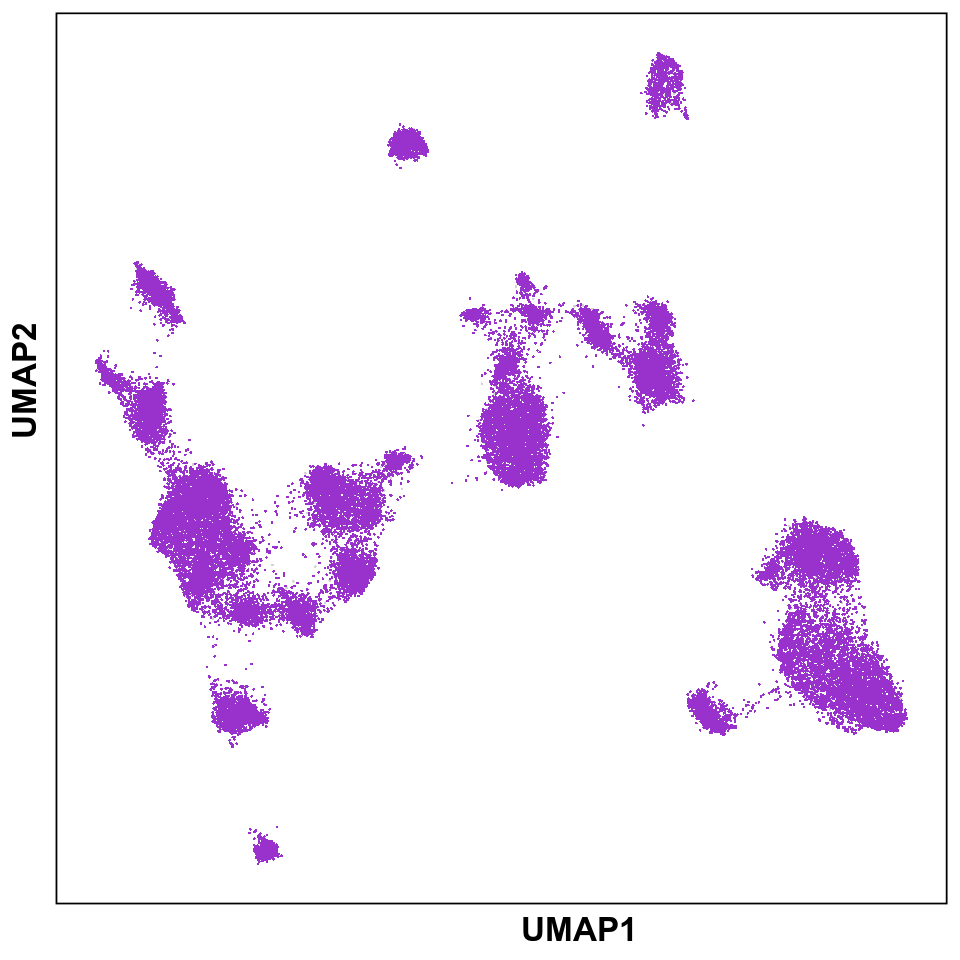

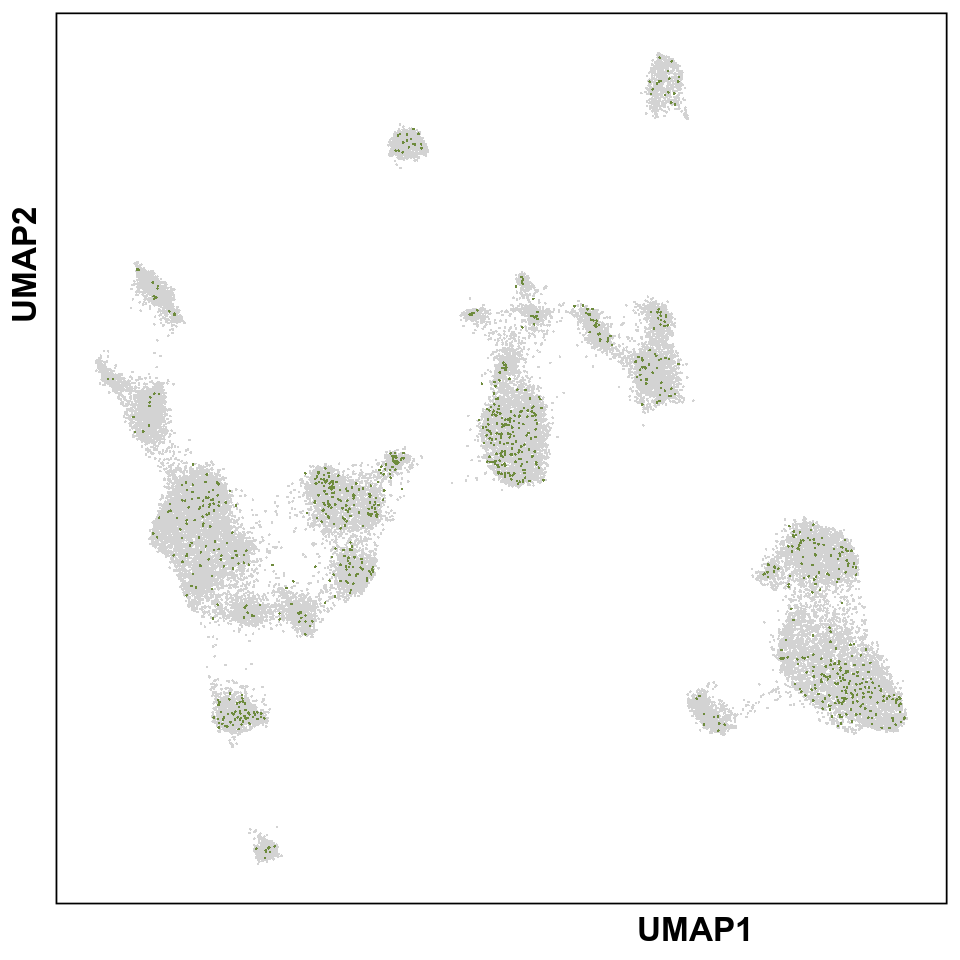

In [176]:
options(repr.plot.height = 8, repr.plot.width = 8)
ggplot() +
  geom_point(
    data=select(qcd_meta, c(hUMAP1, hUMAP2, dataset)),
    aes(x = hUMAP1, y = hUMAP2),
    size = 0.75, stroke = 0.0001, color = "lightgrey"
  ) + 
  geom_point(
    data=qcd_meta %>% filter(Type == "LN") %>% select(hUMAP1, hUMAP2),
    aes(x = hUMAP1, y = hUMAP2),
    size = 0.75, stroke = 0.0001, color = "darkorchid"
  ) +
theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
        #  plot.title = element_text(hjust = 0.5, 
        #                            size = 18, 
        #                            face = "bold"),
          axis.title = element_text(hjust = 0.6, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +     labs(x = "UMAP1", y = "UMAP2") 


ggplot() +
  geom_point(
    data=select(qcd_meta, c(hUMAP1, hUMAP2, dataset)),
    aes(x = hUMAP1, y = hUMAP2),
    size = 0.75, stroke = 0.0001, color = "lightgrey"
  ) + 
  geom_point(
    data=qcd_meta %>% filter(Type == "Control") %>% select(hUMAP1, hUMAP2),
    aes(x = hUMAP1, y = hUMAP2),
    size = 0.75, stroke = 0.0001, color = "darkolivegreen4"
  ) +
theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
        #  plot.title = element_text(hjust = 0.5, 
        #                            size = 18, 
        #                            face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +     labs(x = "UMAP1", y = "UMAP2") 

### CASE/CONTROL CNA

In [24]:
sc_meta <- qcd_meta[, !colnames(qcd_meta) %in% colnames(clinical)] %>% 
                        mutate(kid_sample = qcd_meta$sample) %>% 
                        filter(dataset == 'scRNAseq') %>% 
                        mutate(individual = str_split(kid_sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical)

meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta <- meta %>% mutate(Type_numeric = ifelse(Type == "LN", 1, 0))


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sc_t_nk_casecontrol_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sc_t_nk_casecontrol_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sc_t_nk_casecontrol_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "individual"


Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


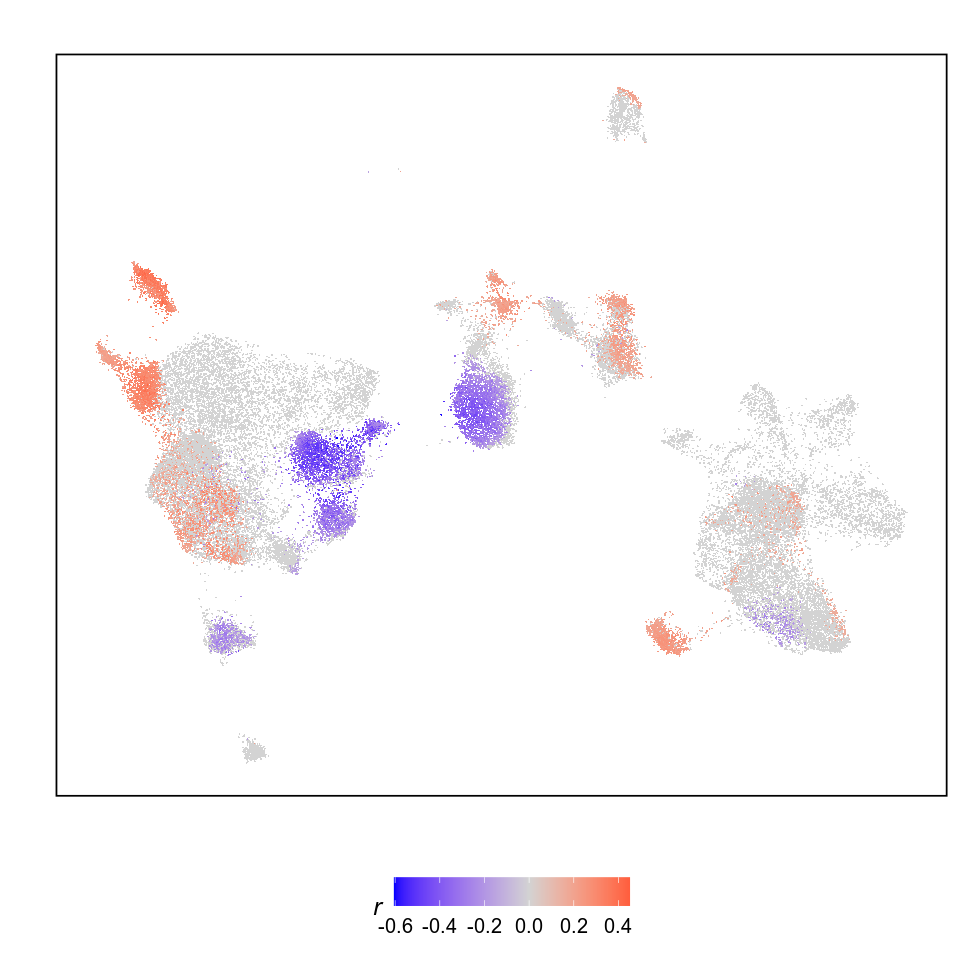

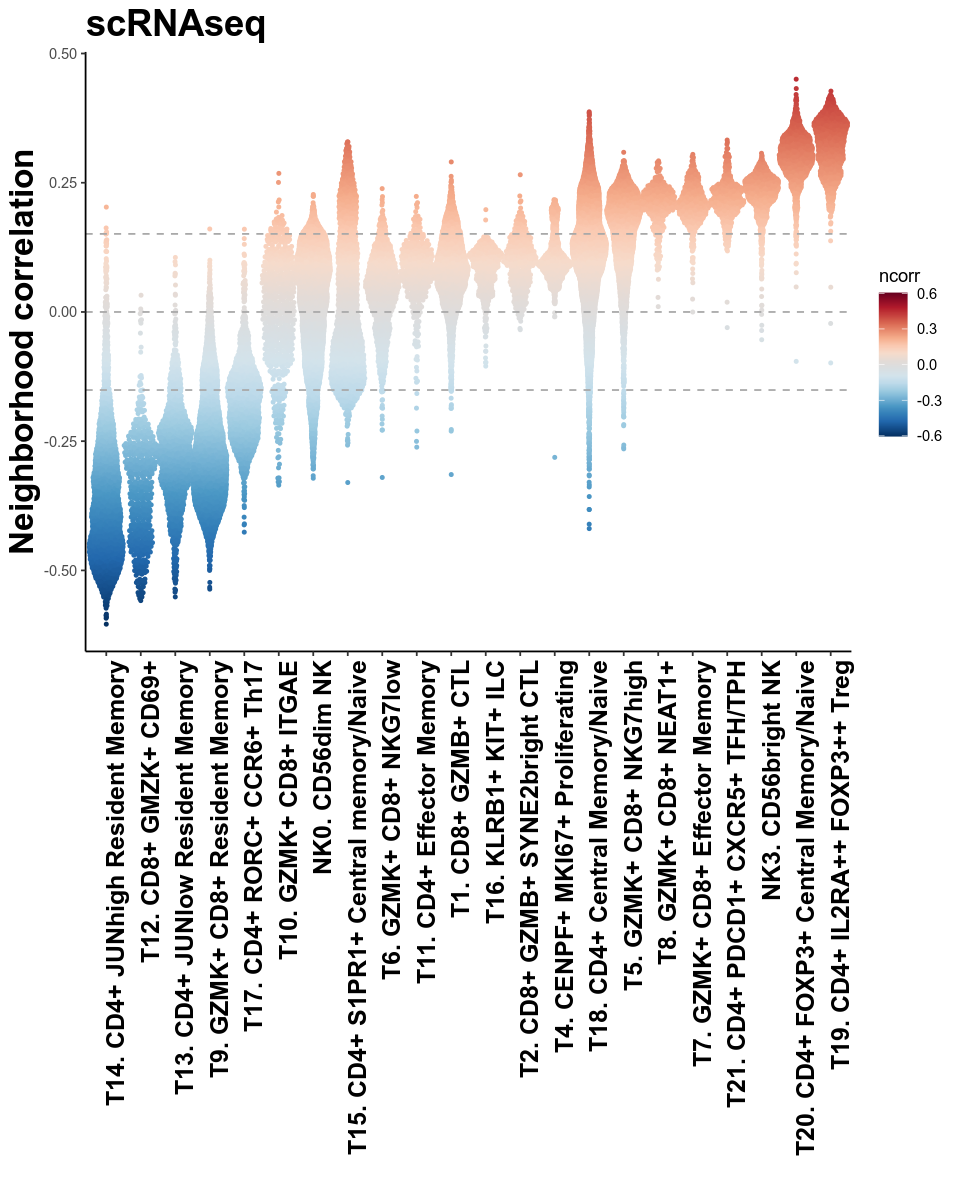

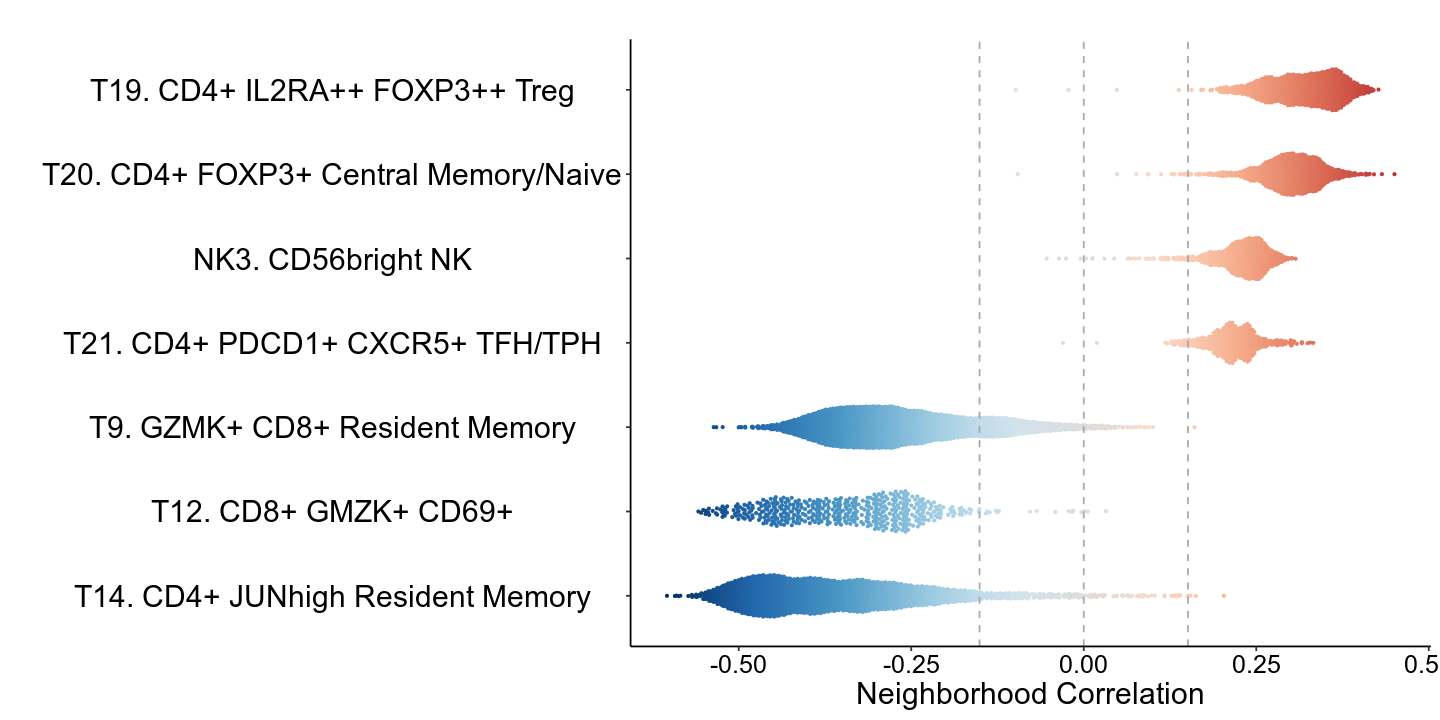

In [44]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sc_t_nk_casecontrol_meta.csv')
kept <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sc_t_nk_casecontrol.kept.csv")
kept <- which(kept[, 1] == TRUE)

thresh <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sc_t_nk_casecontrol.thresh.csv", header = FALSE)
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sc_t_nk_casecontrol.ncorrs.csv", header = FALSE)
ncorr <- ncorr[, 1]

meta_tmp_1 <- meta
meta_tmp_1$ncorr <- as.numeric(ncorr)

thresh5 <- thresh[1, ]


meta_tmp_1$ncorr <- as.numeric(ncorr)

umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sc_t_nk_casecontrol_umap.csv')


meta_tmp_1$hUMAP1 <- umap$hUMAP1
meta_tmp_1$hUMAP2 <- umap$hUMAP2


meta_tmp_1$ncorr[which(abs(meta_tmp_1$ncorr) < thresh5)] <- NA

fig.size(8, 8)
ggplot() + 
      geom_point(data = qcd_meta,
                 aes(x = hUMAP1, y = hUMAP2), color = 'lightgrey', size = 0.75, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = meta_tmp_1[sample(nrow(meta_tmp_1)),] %>% rename(correlation = ncorr), 
          aes(x = hUMAP1, y = hUMAP2, color = correlation), size = 0.75, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
                           #breaks = c(-0.3, -0.15, 0, 0.15, 0.3)) + 
     # labs(x="UMAP1", y="UMAP2", title = "T/NK Chronicity: p = 0.006") +
theme_classic(base_size = 15) +
  theme(
    legend.position = "bottom",
      legend.key.width = unit(1, 'cm'),
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x="", y="", title = "", color = "r") 


pos_fdr_thresh <- thresh5
neg_fdr_thresh <- -1 * thresh5


meta$ncorr <- as.numeric(ncorr)

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(10, 8)

ggplot(meta, aes(x = reorder(final_annotation, ncorr), y = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.5, size = 0.75) +
    geom_hline(yintercept = thresh5, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = -1 * thresh5, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    labs(title = "scRNAseq", x= "", y = "Neighborhood correlation") +
    theme_classic() +
    theme(
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=22, face = "bold"),
        axis.text.x = element_text(color = "black", size = 15, angle = 90, hjust=1, face = "bold"),
        axis.title = element_text(size=20, face = "bold"))

subset <- c(3, 9, 12, 14, 19, 20, 21)
fig.size(6, 12)

ggplot(meta %>% filter(new_cluster_number %in% subset), aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
 #   scale_x_discrete(limits = cluster_order) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [69]:
ci_summary <- meta %>% 
                select(new_cluster_number, cell, ncorr) %>% 
                group_by(new_cluster_number) %>% 
                summarize(ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")"))
res <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/masc/t_nk/case_control.rds') %>% 
            mutate(new_cluster_number = as.numeric(str_remove(cluster, "cluster")),
               OR.ci = paste0("(", round(Type.OR.95pct.ci.lower, 3), ", ", 
                              round(Type.OR.95pct.ci.upper, 3), ")")) %>% 
        select(new_cluster_number, OR.ci)

summary <- ci_summary %>% left_join(res)
write.csv(summary, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/tnk_casecontrol_corr_04152024.csv', quote = FALSE, row.names = FALSE)

Joining, by = "new_cluster_number"


Joining, by = "new_cluster_number"


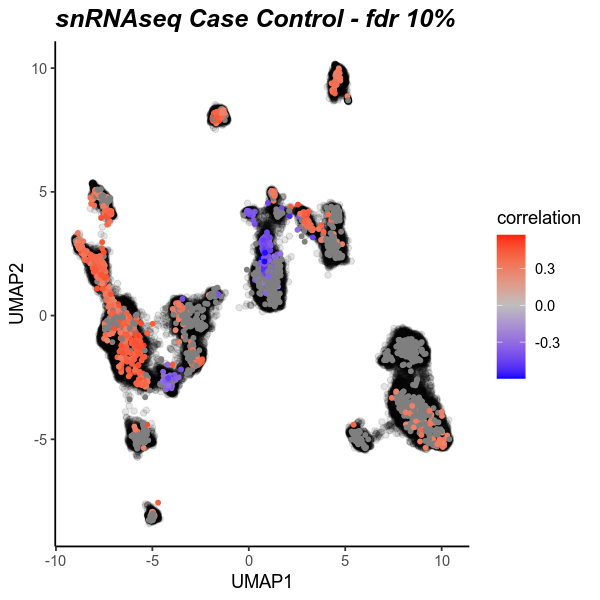

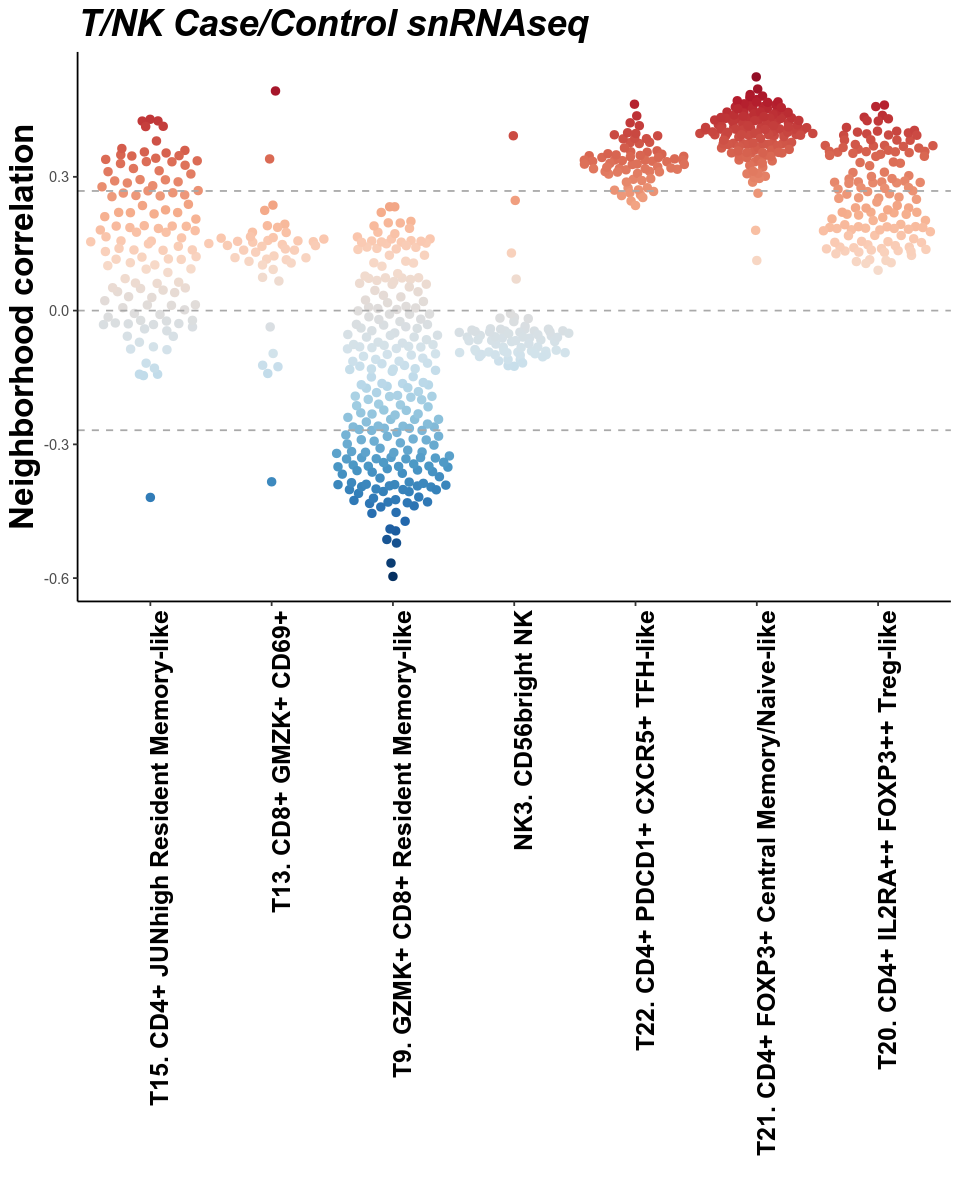

In [26]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sn_t_nk_casecontrol_meta.csv')
meta <- meta %>% left_join(final_annotation)
kept <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sn_t_nk_casecontrol.kept.csv')
kept <- kept[, 1]
kept <- which(kept == TRUE)
thresh <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sn_t_nk_casecontrol.thresh.csv', header = FALSE)
ncorr <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sn_t_nk_casecontrol.ncorrs.csv', check.names = FALSE, header = FALSE)
ncorr <- ncorr[, 1]

thresh10 <- thresh[2, ]


meta_tmp_1 <- meta
meta_tmp_1$ncorr <- as.numeric(ncorr)


umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sn_t_nk_casecontrol_umap.csv')

meta_tmp_1$UMAP1 <- umap$hUMAP1
meta_tmp_1$UMAP2 <- umap$hUMAP2

meta_tmp_1$ncorr[which(abs(meta_tmp_1$ncorr) < thresh10)] <- NA


sc_umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sc_t_nk_casecontrol_umap.csv')

fig.size(5, 5)
ggplot(
      data = meta_tmp_1[sample(nrow(meta_tmp_1)),] %>% rename(correlation = ncorr), 
      aes(x = UMAP1, y = UMAP2)) + 
      geom_point(data = qcd_meta %>% filter(dataset == 'scRNAseq'), aes(x = hUMAP1, y = hUMAP2), color = 'black', alpha = 0.1) + 
      geom_point(mapping = aes(color = correlation), alpha = 5, size = 1) + 
      scale_color_gradient2(low = 'blue', mid = 'gray', high = 'red') + 
      labs(x="UMAP1", y="UMAP2") +
      theme_classic()+
      theme(
        plot.title = element_text(color="black", size=15, face="bold.italic")
        ) +
      labs(title = "snRNAseq Case Control - fdr 10%")

pos_fdr_thres <- thresh10
neg_fdr_thresh <- -1 * thresh10


meta$ncorr <- as.numeric(ncorr)

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(10, 8)

ggplot(meta %>% filter(new_cluster_number %in% c(3, 20, 21, 22, 9, 13, 15)), aes(x = reorder(final_annotation, ncorr), y = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.5, size = 2) +
    geom_hline(yintercept = thresh10, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = -1 * thresh10, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    labs(title = "T/NK Case/Control snRNAseq", x= "", y = "Neighborhood correlation") +
    scale_x_discrete(limits = c('T15. CD4+ JUNhigh Resident Memory-like',
                                'T13. CD8+ GMZK+ CD69+',
                                'T9. GZMK+ CD8+ Resident Memory-like',
                                'NK3. CD56bright NK',
                                'T22. CD4+ PDCD1+ CXCR5+ TFH-like',
                                'T21. CD4+ FOXP3+ Central Memory/Naive-like',
                                'T20. CD4+ IL2RA++ FOXP3++ Treg-like'
)) + 
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=22, face = "bold.italic"),
        axis.text.x = element_text(color = "black", size = 15, angle = 90, hjust=1, face = "bold"),
        axis.title = element_text(size=20, face = "bold"))

### PSEUDOBULK DE

In [8]:
out <- mclapply(unique(qcd_meta$sample), pseudobulk, qcd_meta, qcd_norm,
               mc.cores = 6)
tnk_pb <- data.frame(do.call(rbind, out))

In [13]:
sample_stats <- qcd_meta %>% group_by(sample) %>% summarize(avg_count = mean(nCount_RNA), avg_mt = mean(percent.mt))
tnk_pb <- tnk_pb %>% left_join(sample_stats) %>% left_join(unique(qcd_meta %>% select(sample, Type)))
tnk_pb <- tnk_pb[grep("cells", tnk_pb$sample), ]
colnames(tnk_pb)[1:36601] <- rownames(qcd_norm)

Joining, by = "sample"
Joining, by = "sample"


In [15]:
saveRDS(tnk_pb, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/TNK_norm_pseudobulk_12072023.rds')

In [17]:
de_out <- mclapply(rownames(qcd_norm), de, tnk_pb, mc.cores = 20)

In [18]:
de_df <- data.frame(do.call(rbind, de_out)) %>% mutate(LRP = as.numeric(LRP),
                                                       F = as.numeric(F),
                                                       Beta = as.numeric(Beta),
                                                       SE = as.numeric(SE))

In [23]:
saveRDS(de_df, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/TNK_case_control_differential_expression_120722023.rds')

In [12]:
de_df <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/TNK_case_control_differential_expression_120722023.rds')

In [13]:
de_df <- de_df %>% na.omit()

In [14]:
genes <- c("CXCR4", "NFKBIA", "IL7R", "FKBP5", "PRDM1", 
           "BST2", "PFN1", "CD74", "ISG15", "IFI44L")

Warning message:
“Removed 19065 rows containing missing values (`geom_text_repel()`).”


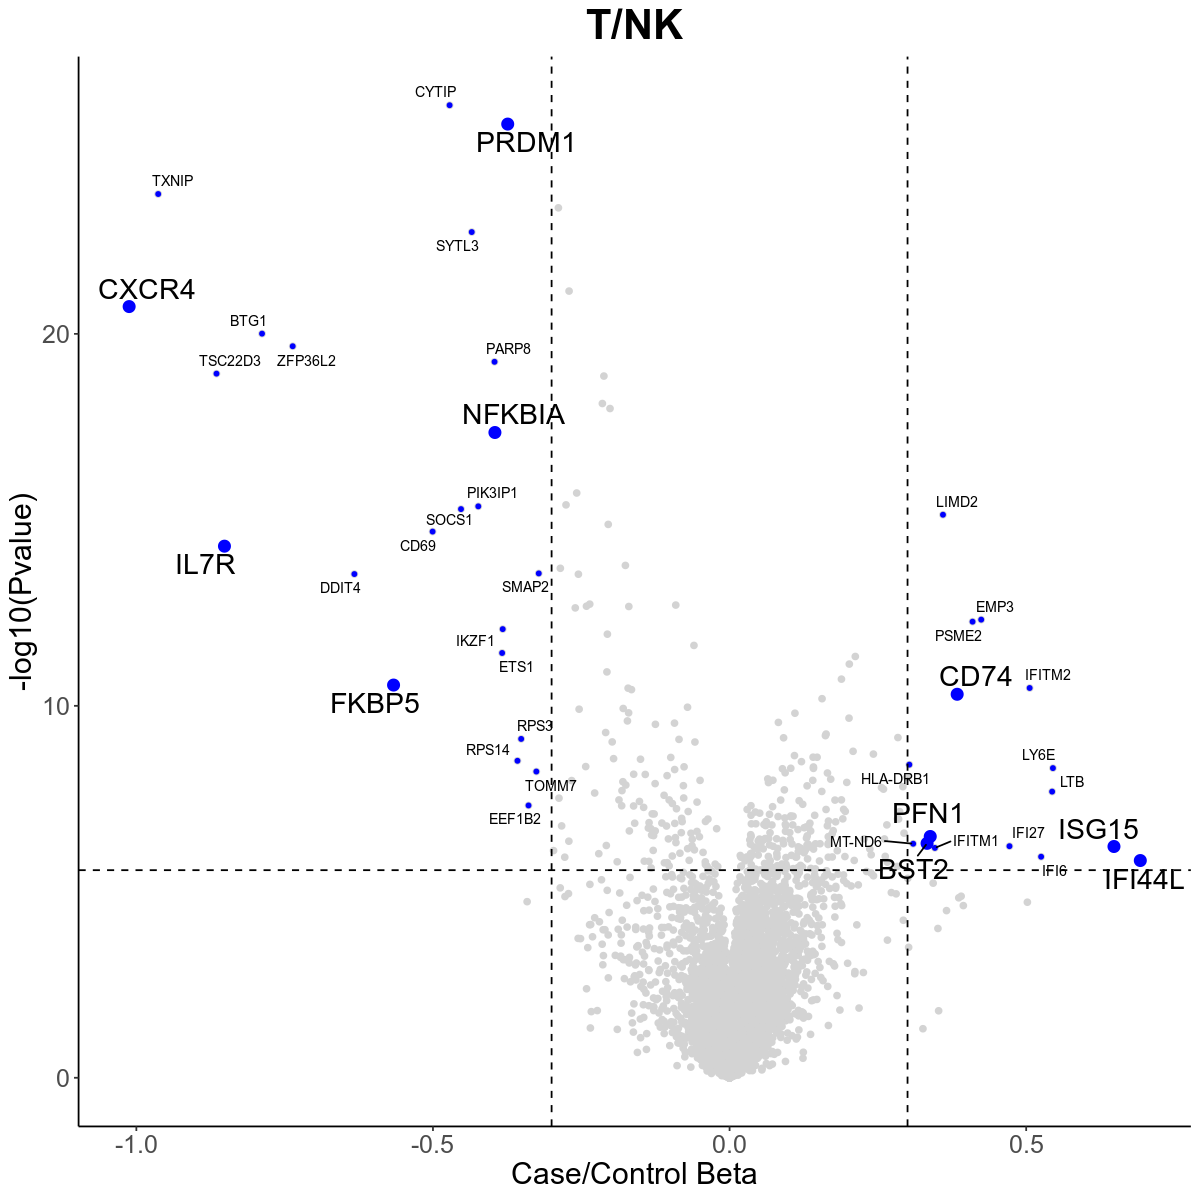

In [16]:
fig.size(10, 10)
ggplot(de_df,
                aes(x = Beta, y = -log10(LRP))) +
    geom_point(colour = 'lightgrey') + 
    geom_point(data = de_df %>% filter(LRP < 0.05/nrow(de_df) & abs(Beta) >= 0.3,
                                        ! gene %in% genes),
                   aes(x = Beta, y = -log10(LRP)),  color = "blue", size = 1) +
    geom_point(data = de_df %>% filter(gene %in% genes),
                   aes(x = Beta, y = -log10(LRP)),  color = "blue", size = 3)  + 
    geom_vline(xintercept = c(-0.3, 0.3), linetype = "dashed") + 
    geom_hline(yintercept = -log10(0.05/nrow(de_df)), linetype = "dashed") + 
    theme_classic() + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 25, hjust = 0.5, face = "bold")) +
    ggrepel::geom_text_repel(data = de_df %>% 
                                     mutate(label = ifelse(LRP < 0.05/nrow(de_df) & abs(Beta) >= 0.3 | 
                                                           gene %in% genes, gene, NA),
                                            label_size = ifelse(gene %in% genes, 6 , 3)),
                                     aes(x = Beta, y = -log10(LRP), 
                                         size = label_size, label = label)
            , color = "black") +
    scale_size_identity() + 
    labs(x = "Case/Control Beta", y = "-log10(Pvalue)", title = "T/NK")

### DE CORRELATION WITH CNA 

In [6]:
qcd_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_NK_clusterQCd_norm_09092022.rds')

In [7]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sc_t_nk_casecontrol_meta.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sc_t_nk_casecontrol.ncorrs.csv", header = FALSE)
ncorr <- ncorr[, 1]
meta$ncorr <- as.numeric(ncorr)

In [24]:
out <- mclapply(rownames(qcd_norm), cna_cor, meta, qcd_norm, mc.cores = 20)

In [28]:
cor_df <- do.call(rbind, out) %>% data.frame() %>% 
                                rename(gene = V1, pval = V3) %>% 
                                mutate(cor = as.numeric(cor),
                                       pval = as.numeric(pval))

In [32]:
saveRDS(cor_df, "/data/srlab/ssg34/SLE_kidney_v2/data/tissue/TNK_case_control_gene_correlation_01082024.rds")

### DE UMAPS

In [631]:
plot_shuffled_features <- function(input_df, input_norm, feature, pct) {
    
max.cutoff = quantile(input_norm[feature, input_df$cell], pct)
min.cutoff = quantile(input_norm[feature, input_df$cell], 1-pct)

plot_df <- input_df 
    
plot_df$norm_expression <- input_norm[feature, input_df$cell]
    
plot_df <- plot_df %>% 
                mutate(norm_expression = ifelse(norm_expression < min.cutoff, min.cutoff, norm_expression)) %>%
                mutate(norm_expression = ifelse(norm_expression > max.cutoff, max.cutoff, norm_expression)) 

p <- ggplot() +
        geom_point(
            data = plot_df[sample(nrow(plot_df)), ] %>% 
                      select(hUMAP1, hUMAP2, norm_expression), 
            aes(x = hUMAP1, y = hUMAP2, color = norm_expression),
            size = 0.75) +
      scale_color_viridis(option = "plasma", end = .9, name = "Expression") +
      labs(x="", y="", title = feature)+
      theme_bw(base_size = 20)+
      #facet_wrap(~dataset)+
      theme(
        legend.text = element_text(size = 10), 
        legend.title = element_text(size = 10),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=15, face="bold.italic"),
        strip.text.x = element_text(size = 10),
        axis.text = element_blank(),
        axis.ticks = element_blank()) 
return(p)
}

In [67]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sc_t_nk_casecontrol_meta.csv')
kept <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sc_t_nk_casecontrol.kept.csv")
kept <- which(kept[, 1] == TRUE)

thresh <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sc_t_nk_casecontrol.thresh.csv", header = FALSE)
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sc_t_nk_casecontrol.ncorrs.csv", header = FALSE)
ncorr <- ncorr[, 1]

meta_tmp_1 <- meta
meta_tmp_1$ncorr <- as.numeric(ncorr)

In [572]:
gene_cor <- function(gene) { 
    suppressWarnings(return(data.frame(cor.test(meta_tmp_1$ncorr, qcd_norm[gene, meta_tmp_1$cell])$estimate,
                            cor.test(meta_tmp_1$ncorr, qcd_norm[gene, meta_tmp_1$cell])$pvalue)))
}

In [582]:
cor_values <- vector()
for (i in 1:nrow(qcd_norm)) {
    cor_values <- c(cor_values, gene_cor(i))
}

In [ ]:
cor_out <- rbind(cor_out, data.frame(cor = cor.test(meta$ncorr, qcd_norm[gene, meta$cell])$estimate, 
                          pval = cor.test(meta$ncorr, qcd_norm[gene, meta$cell])$p.value))

In [73]:
cor_df <- readRDS("/data/srlab/ssg34/SLE_kidney_v2/data/cna/t_nk/sc_t_nk_casecontrol_genecor.rds")

In [607]:
cor_df %>% na.omit() %>% arrange(cor_values)

cor_values gene     
1     -0.2148675 ANXA1    
2     -0.2094255 LINC00892
3     -0.2024365 CD2      
4     -0.1959086 CD40LG   
5     -0.1931641 CCL5     
6     -0.1919375 JUN      
7     -0.1891504 HOPX     
8     -0.1811439 CKLF     
9     -0.1755224 XCL1     
10    -0.1727736 KLRB1    
11    -0.1708406 LINC01871
12    -0.1607003 CAPG     
13    -0.1588371 CD69     
14    -0.1563053 NCF1     
15    -0.1454570 ZNF683   
16    -0.1450497 CXCR6    
17    -0.1442643 ALOX5AP  
18    -0.1424212 IL2      
19    -0.1418501 ITGA1    
20    -0.1356457 TMSB4X   
21    -0.1317031 ZFP36L2  
22    -0.1284790 S100A4   
23    -0.1276836 HCST     
24    -0.1211229 GZMA     
25    -0.1208668 CXCR3    
26    -0.1198259 CPNE7    
27    -0.1176261 LGALS3   
28    -0.1155864 CCR2     
29    -0.1143524 JAML     
30    -0.1138973 FKBP11   
⋮     ⋮          ⋮        
27789 0.1011742  TTN      
27790 0.1012034  HAPLN3   
27791 0.1021636  HLA-DRA  
27792 0.1021696  STAM     
27793 0.1065927  BIRC3    
27794 0.1086792  F5       
27795 0.1108435  TSHZ2    
27796 0.1121315  RIPOR2   
27797 0.1123211  CD74     
27798 0.1129665  NPDC1    
27799 0.1137445  ENTPD1   
27800 0.1141003  TBC1D4   
27801 0.1149511  ID3      
27802 0.1151687  HACD1    
27803 0.1156968  SESN3    
27804 0.1161355  LEF1     
27805 0.1215645  GBP2     
27806 0.1222772  CCR7     
27807 0.1281467  CD27     
27808 0.1344932  MAL      
27809 0.1351755  CTLA4    
27810 0.1429062  IKZF2    
27811 0.1628625  TNFRSF18 
27812 0.1724297  ICA1     
27813 0.1828242  TIGIT    
27814 0.1854938  RTKN2    
27815 0.1945811  FOXP3    
27816 0.1955073  TNFRSF4  
27817 0.2067102  KLF2     
27818 0.2214642  SELL

In [610]:
cor.test(meta_tmp_1$ncorr, qcd_norm["SELL", meta_tmp_1$cell])


	Pearson's product-moment correlation

data:  meta_tmp_1$ncorr and qcd_norm["SELL", meta_tmp_1$cell]
t = 43.167, df = 36129, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2116362 0.2312474
sample estimates:
      cor 
0.2214642 


In [68]:
cor.test(meta_tmp_1$ncorr, qcd_norm["PRDM1", meta_tmp_1$cell])


	Pearson's product-moment correlation

data:  meta_tmp_1$ncorr and qcd_norm["PRDM1", meta_tmp_1$cell]
t = -7.0681, df = 36129, p-value = 1.599e-12
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.04745313 -0.02685914
sample estimates:
        cor 
-0.03716008 


In [14]:
poisson_model_stats <- function(gene, meta, rawcounts) {
df <- meta %>% select(nCount_RNA, percent.mt, sample, Type) %>%
                mutate(numeric_type = ifelse(Type == "Control", 0, 1)) %>%
                mutate(Exp = rawcounts[gene, meta$cell])
if(sum(df$Exp > 0) > 0.025 * nrow(df)) {
H0 <- glmmTMB(Exp ~ log(nCount_RNA) + percent.mt + (1|sample),
                     data = df, family=poisson(link='log'),
                     control = glmmTMBControl(parallel = 10))
H1 <- glmmTMB(Exp ~ log(nCount_RNA) + percent.mt + (1|sample) + numeric_type,
                     data = df, family=poisson(link='log'),
                      control = glmmTMBControl(parallel = 10))
ANNO <- anova(H0, H1)
LRP <- ANNO[["Pr(>Chisq)"]][2]
LRchisq<- ANNO[["Chisq"]][2]
Beta <- summary(H1)$coefficients$cond["numeric_type", "Estimate"]
SE <- summary(H1)$coefficients$cond["numeric_type", "Estimate"]

stats <- c(gene = gene, LRP = LRP, LRChisq = LRchisq, Beta = Beta, SE = SE)
}
else {
stats <- c(gene = gene, LRP = NA, LRChisq = NA, Beta = NA, SE = NA)
}
return(stats) }


poisson_model_stats("SELL", sc_meta, tnk_rawcounts[, sc_meta$cell])
poisson_model_stats("ANXA1", sc_meta, tnk_rawcounts[, sc_meta$cell])

gene                    LRP                LRChisq 
                "SELL" "1.32815258528259e-07"     "27.8247628530808" 
                  Beta                     SE 
    "0.94561836196493"     "0.94561836196493"

gene                    LRP                LRChisq 
               "ANXA1" "6.50450770392925e-05"     "15.9497875968082" 
                  Beta                     SE 
  "-0.243114780134728"   "-0.243114780134728"

In [25]:
gene <- "ANXA1"

meta <- sc_meta

df <- meta %>% select(nCount_RNA, percent.mt, sample, Type) %>%
                mutate(numeric_type = ifelse(Type == "Control", 0, 1)) %>%
                mutate(Exp = tnk_rawcounts[gene, meta$cell])
if(sum(df$Exp > 0) > 0.025 * nrow(df)) {
H0 <- glmmTMB(Exp ~ log(nCount_RNA) + percent.mt + (1|sample),
                     data = df, family=poisson(link='log'),
                     control = glmmTMBControl(parallel = 10))
H1 <- glmmTMB(Exp ~ log(nCount_RNA) + percent.mt + (1|sample) + numeric_type,
                     data = df, family=poisson(link='log'),
                      control = glmmTMBControl(parallel = 10))
ANNO <- anova(H0, H1)
LRP <- ANNO[["Pr(>Chisq)"]][2]
LRchisq<- ANNO[["Chisq"]][2]
Beta <- summary(H1)$coefficients$cond["numeric_type", "Estimate"]
SE <- summary(H1)$coefficients$cond["numeric_type", "Std. Error"]

stats <- c(gene = gene, LRP = LRP, LRChisq = LRchisq, Beta = Beta, SE = SE)
}

In [26]:
stats

gene                    LRP                LRChisq 
               "ANXA1" "6.50450770392925e-05"     "15.9497875968082" 
                  Beta                     SE 
  "-0.243114780134728"   "0.0593552279483386"

In [27]:
0.95 * 0.059

[1] 0.05605

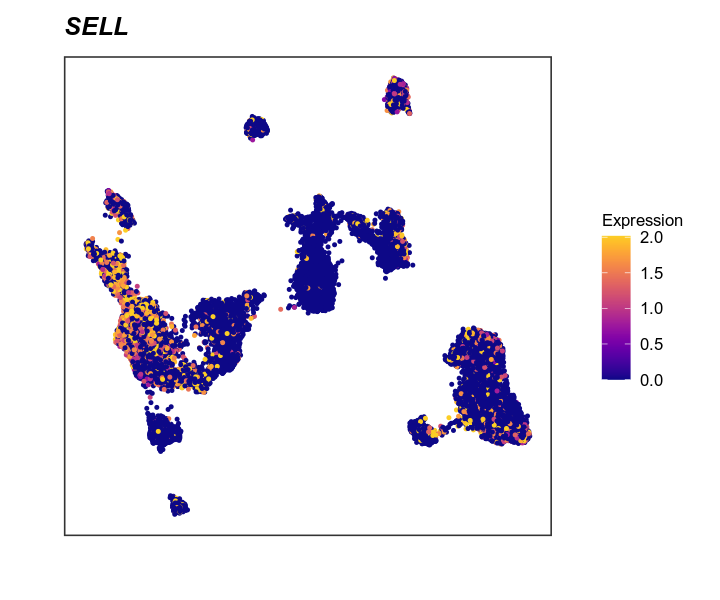

In [632]:
fig.size(5, 6)
plot_shuffled_features(sc_meta, qcd_norm[, sc_meta$cell], "SELL", 0.95)

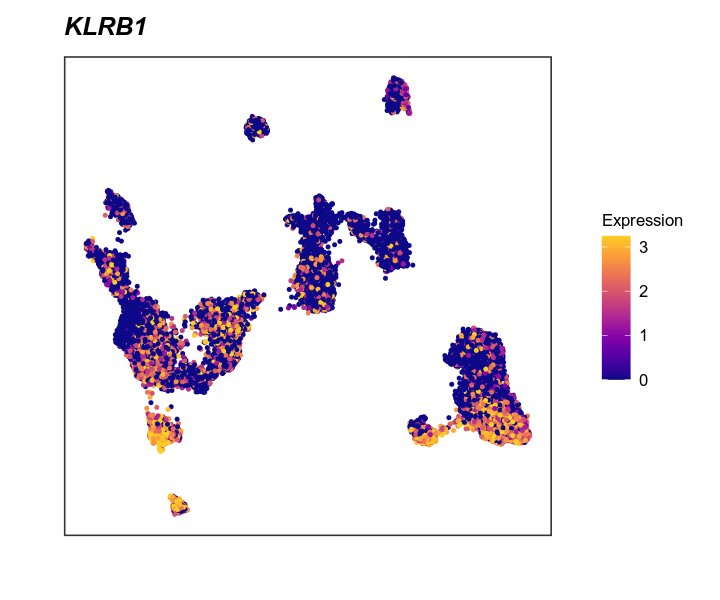

In [635]:
fig.size(5, 6)
plot_shuffled_features(sc_meta, qcd_norm[, sc_meta$cell], "KLRB1", 0.95)

In [151]:
wilcox <- wilcoxauc(sc_norm, sc_meta$new_cluster_number)

In [ ]:
wilcox %>% filter(new_cluster_number %in% )

#### PER CLUSTER DE

In [29]:
## CLUSTER 9 

df <- data.frame()

for (i in c('1_10000', '10000_19999', '20000_29999', '30000_36601')) {
    DE <- readRDS(paste0('/data/srlab/ssg34/SLE_kidney_v2/data/DE/T_NK_DE_cluster9_', i, '.rds'))
    DE <-  as.data.frame(do.call(rbind, DE))
    df <- rbind(df, DE)
}

In [24]:
control_9 <- sc_meta %>% filter(new_cluster_number == 9 & Type == "Control")
LN_9 <- sc_meta %>% filter(new_cluster_number == 9 & Type == "LN")

In [30]:
df <- df %>% mutate(LRP = as.numeric(LRP),
                    LRChisq = as.numeric(LRChisq),
                    Beta = as.numeric(Beta),
                    SE = as.numeric(SE)) %>% na.omit()

In [31]:
keep_genes <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/DE/keep_genes_cluster9_5_TNK.rds')

In [32]:
library(msigdbr)
library(fgsea)
df <- df %>% filter(gene %in% keep_genes)
##format for gsea 
FC.vec <- df$Beta
names(FC.vec) <- df$gene

scoreType <- "std"

H <- msigdbr(species = "Homo sapiens", category = "H")

H.ensembl.ls <- H %>% 
  select(gs_name, gene_symbol) %>% 
  group_by(gs_name) %>% 
  summarise(all.genes = list(unique(gene_symbol))) %>% 
  tibble::deframe()

#Run GSEA
gsea.H <- fgseaSimple(pathways = H.ensembl.ls,
                      stats = FC.vec,
                      scoreType = scoreType,
                      nperm=10000)

Warning message:
“Removed 5330 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


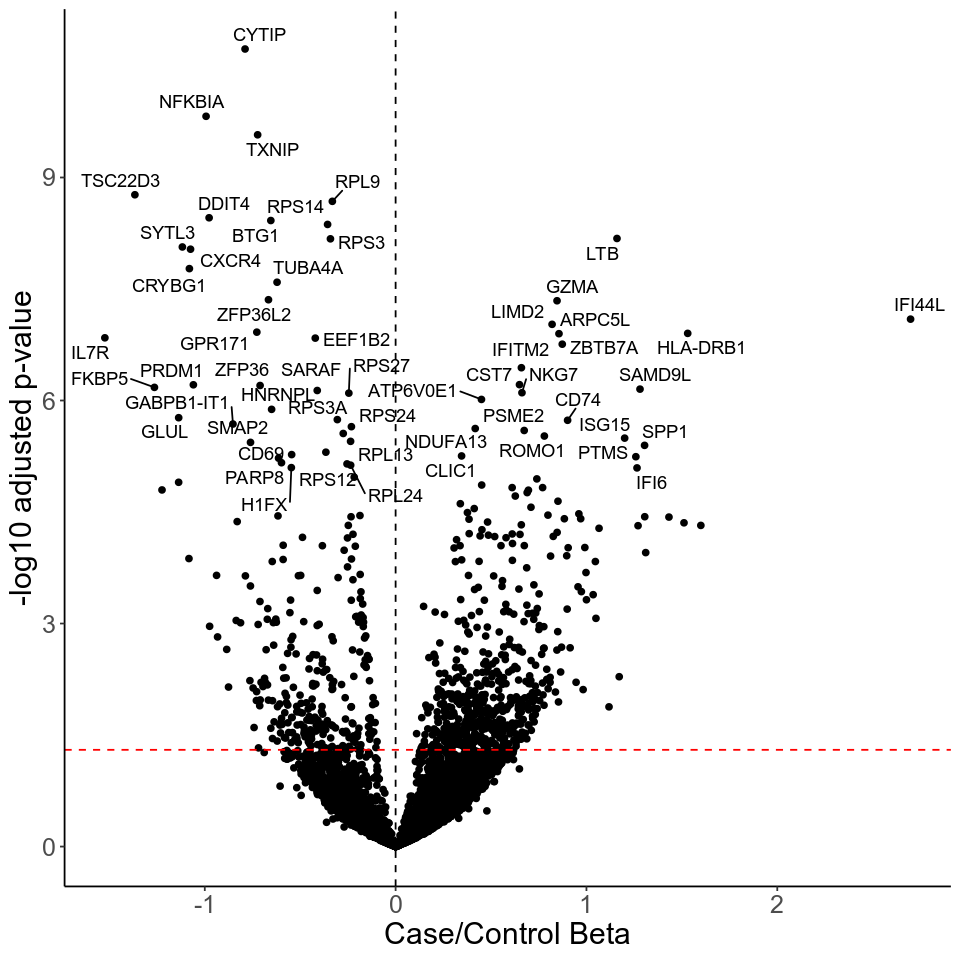

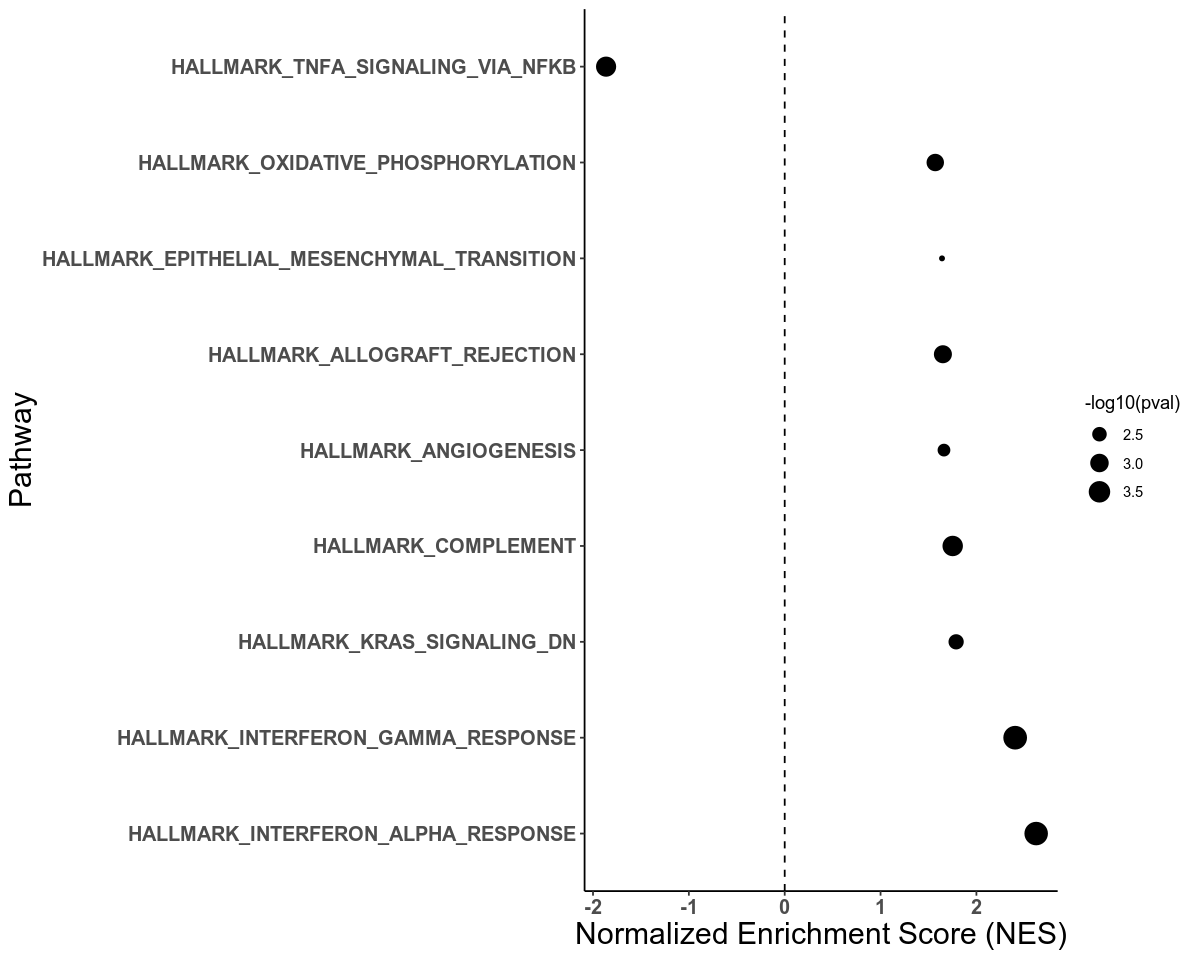

In [34]:
fig.size(8,8)
ggplot(df %>% mutate(label = ifelse(-log10(LRP) > 5, gene, NA)), 
       aes(x = Beta, y = -log10(LRP))) +
    geom_point() + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red") +
    geom_vline(xintercept = 0, linetype = "dashed") + 
    theme_classic() + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18)) +
    ggrepel::geom_text_repel(aes(label = label)) +
    labs(x = "Case/Control Beta", y = "-log10 adjusted p-value")

fig.size(8, 10)
ggplot(gsea.H %>% filter(padj < 0.05), aes(y = pathway, x = NES)) + 
    geom_point(aes(size = -log10(pval))) + 
    scale_y_discrete(limits = gsea.H %>% filter(padj < 0.05) %>% arrange(desc(NES)) %>% pull(pathway)) + 
    theme_classic() + 
    theme(
          axis.text = element_text(size = 12, face = "bold"),
          axis.title = element_text(size = 18)) +
    geom_vline(aes(xintercept = 0), linetype = "dashed") + 
    labs(x = 'Normalized Enrichment Score (NES)', y = 'Pathway')

In [35]:
## CLUSTER 14 

df <- data.frame()

for (i in c('1_10000', '10000_19999', '20000_29999', '30000_36601')) {
    DE <- readRDS(paste0('/data/srlab/ssg34/SLE_kidney_v2/data/DE/T_NK_DE_cluster14_', i, '.rds'))
    DE <-  as.data.frame(do.call(rbind, DE))
    df <- rbind(df, DE)
}

In [36]:
df <- df %>% mutate(LRP = as.numeric(LRP),
                    LRChisq = as.numeric(LRChisq),
                    Beta = as.numeric(Beta),
                    SE = as.numeric(SE)) %>% na.omit()

In [42]:
control_14<- sc_meta %>% filter(new_cluster_number == 14 & Type == "Control")
LN_14 <- sc_meta %>% filter(new_cluster_number == 14 & Type == "LN")

In [11]:
cluster_14 <- df %>% arrange(LRP) %>% slice(1:100) %>% pull(gene)
cluster_14_df <- df %>% arrange(LRP) %>% slice(1:100) %>% select(gene, Beta, SE)

In [37]:
keep_genes <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/DE/keep_genes_TNK_cluster14_5.rds')

In [38]:
library(msigdbr)
library(fgsea)
df <- df %>% filter(gene %in% keep_genes)
##format for gsea 
FC.vec <- df$Beta
names(FC.vec) <- df$gene

scoreType <- "std"

H <- msigdbr(species = "Homo sapiens", category = "H")

H.ensembl.ls <- H %>% 
  select(gs_name, gene_symbol) %>% 
  group_by(gs_name) %>% 
  summarise(all.genes = list(unique(gene_symbol))) %>% 
  tibble::deframe()

#Run GSEA
gsea.H <- fgseaSimple(pathways = H.ensembl.ls,
                      stats = FC.vec,
                      scoreType = scoreType,
                      nperm=10000)

Warning message:
“Removed 5114 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


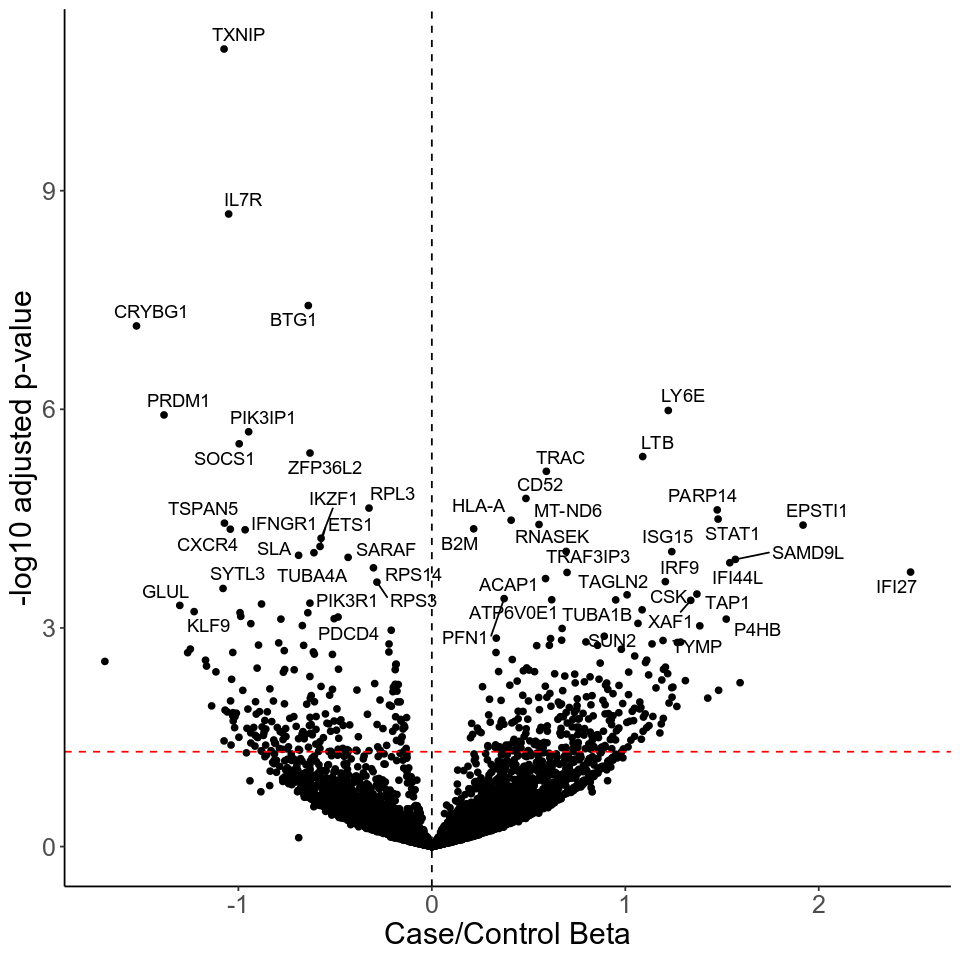

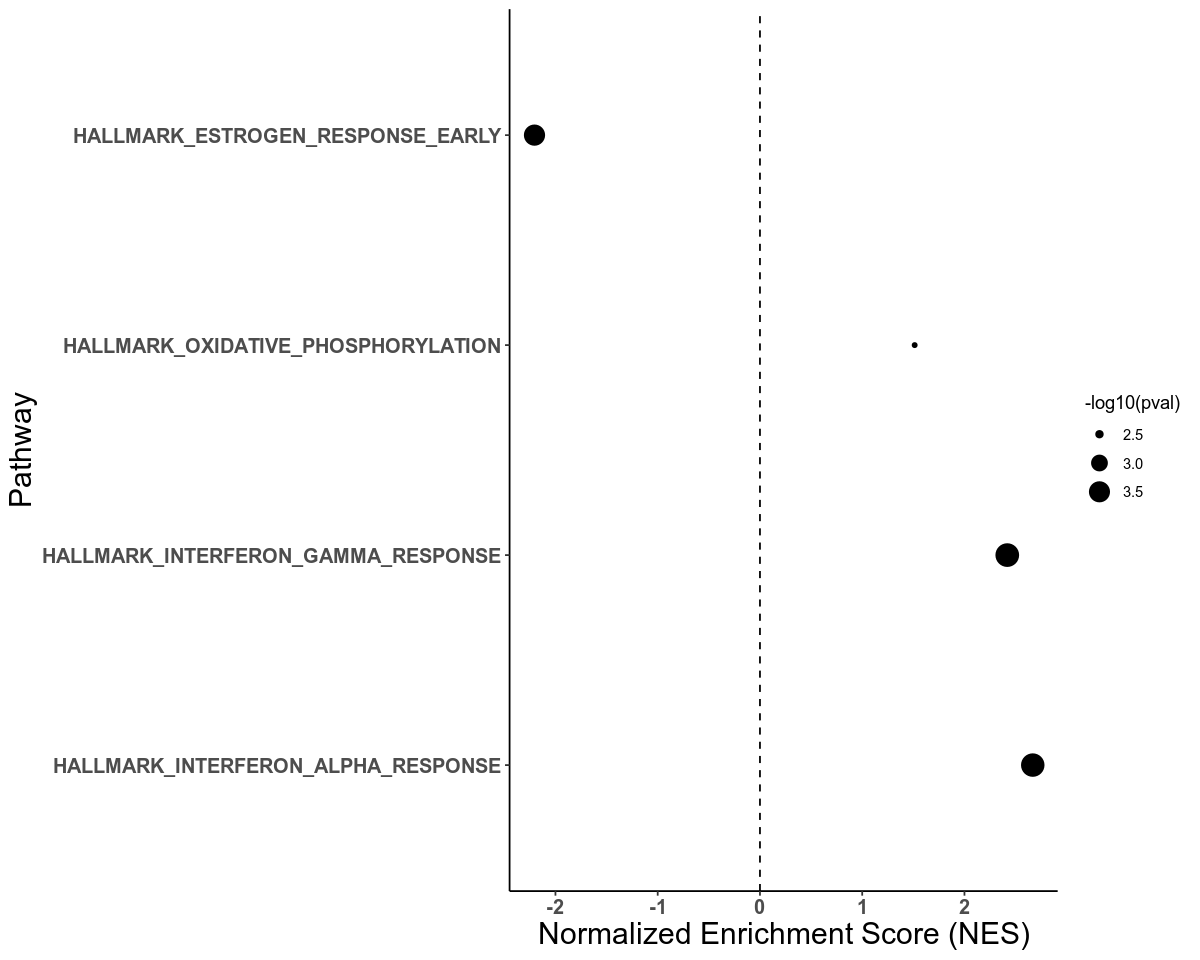

In [41]:
fig.size(8, 8)
fig.size(8,8)
ggplot(df %>% mutate(label = ifelse(-log10(LRP) > 3, gene, NA)), 
       aes(x = Beta, y = -log10(LRP))) +
    geom_point() + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red") +
    geom_vline(xintercept = 0, linetype = "dashed") + 
    theme_classic() + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18)) +
   ggrepel::geom_text_repel(aes(label = label)) +
    labs(x = "Case/Control Beta", y = "-log10 adjusted p-value")

fig.size(8, 10)
ggplot(gsea.H %>% filter(padj < 0.05), aes(y = pathway, x = NES)) + 
    geom_point(aes(size = -log10(pval))) + 
    scale_y_discrete(limits = gsea.H %>% filter(padj < 0.05) %>% arrange(desc(NES)) %>% pull(pathway)) + 
    theme_classic() + 
    theme(
          axis.text = element_text(size = 12, face = "bold"),
          axis.title = element_text(size = 18)) +
    geom_vline(aes(xintercept = 0), linetype = "dashed") + 
    labs(x = 'Normalized Enrichment Score (NES)', y = 'Pathway')

In [42]:
## CLUSTER 15 

df <- data.frame()

for (i in c('1_10000', '10000_19999', '20000_29999', '30000_36601')) {
    DE <- readRDS(paste0('/data/srlab/ssg34/SLE_kidney_v2/data/DE/T_NK_DE_cluster15_', i, '.rds'))
    DE <-  as.data.frame(do.call(rbind, DE))
    df <- rbind(df, DE)
}

In [43]:
df <- df %>% mutate(LRP = as.numeric(LRP),
                    LRChisq = as.numeric(LRChisq),
                    Beta = as.numeric(Beta),
                    SE = as.numeric(SE)) %>% na.omit()

In [11]:
control_15 <- sc_meta %>% filter(new_cluster_number == 15 & Type == "Control")
LN_15 <- sc_meta %>% filter(new_cluster_number == 15 & Type == "LN")

ERROR: Error in filter(., new_cluster_number == 15 & Type == "Control"): object 'sc_meta' not found


In [45]:
keep_genes <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/DE/keep_genes_TNK_5_cluster15.rds')

In [46]:
library(msigdbr)
library(fgsea)
df <- df %>% filter(gene %in% keep_genes)
##format for gsea 
FC.vec <- df$Beta
names(FC.vec) <- df$gene

scoreType <- "std"

H <- msigdbr(species = "Homo sapiens", category = "H")

H.ensembl.ls <- H %>% 
  select(gs_name, gene_symbol) %>% 
  group_by(gs_name) %>% 
  summarise(all.genes = list(unique(gene_symbol))) %>% 
  tibble::deframe()

#Run GSEA
gsea.H <- fgseaSimple(pathways = H.ensembl.ls,
                      stats = FC.vec,
                      scoreType = scoreType,
                      nperm=10000)

Warning message:
“Removed 4859 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


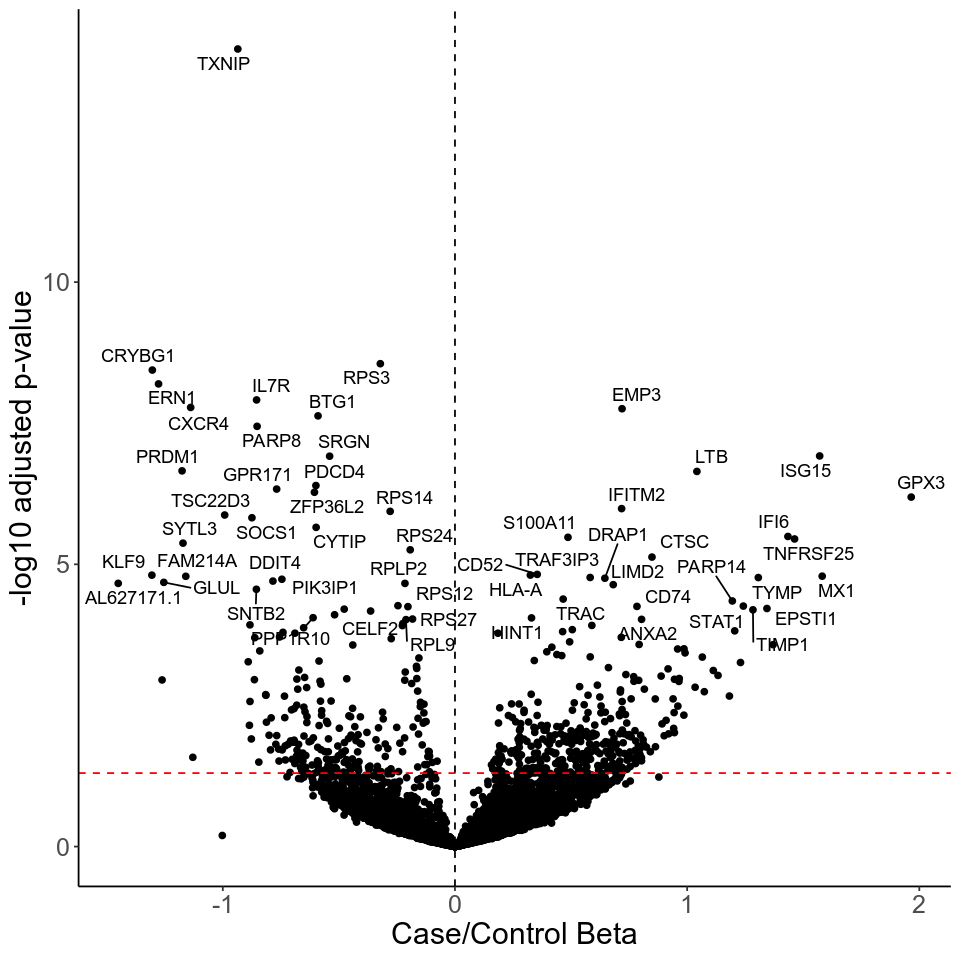

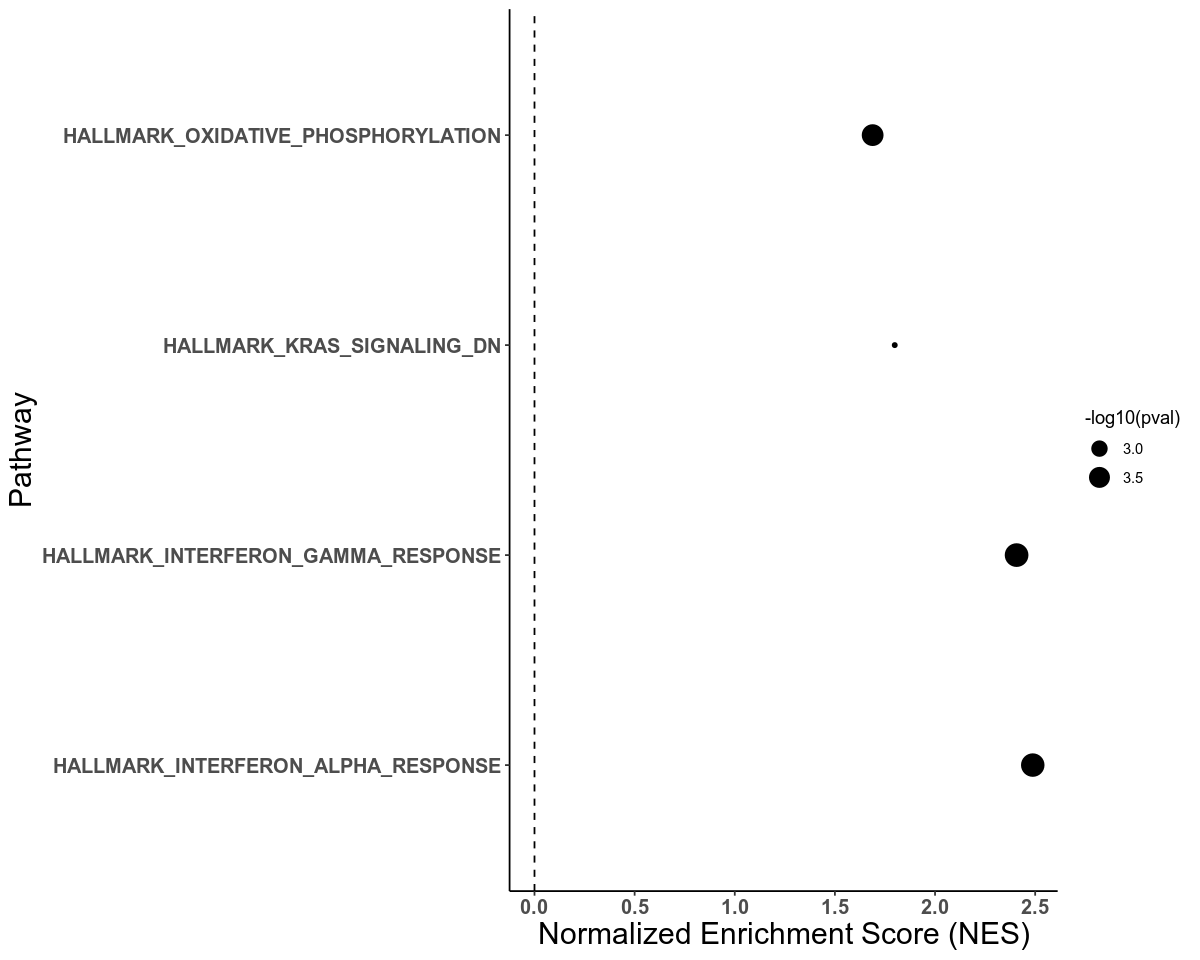

In [48]:
fig.size(8,8)
ggplot(df %>% mutate(label = ifelse(-log10(LRP) > 4, gene, NA)), 
       aes(x = Beta, y = -log10(LRP))) +
    geom_point() + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "red") +
    geom_vline(xintercept = 0, linetype = "dashed") + 
    theme_classic() + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18)) +
   ggrepel::geom_text_repel(aes(label = label)) +
    labs(x = "Case/Control Beta", y = "-log10 adjusted p-value")

fig.size(8, 10)
ggplot(gsea.H %>% filter(padj < 0.05), aes(y = pathway, x = NES)) + 
    geom_point(aes(size = -log10(pval))) + 
    scale_y_discrete(limits = gsea.H %>% filter(padj < 0.05) %>% arrange(desc(NES)) %>% pull(pathway)) + 
    theme_classic() + 
    theme(
          axis.text = element_text(size = 12, face = "bold"),
          axis.title = element_text(size = 18)) +
    geom_vline(aes(xintercept = 0), linetype = "dashed") + 
    labs(x = 'Normalized Enrichment Score (NES)', y = 'Pathway')

In [15]:
shared_genes <- intersect(intersect(cluster_9, cluster_14), cluster_15)

In [16]:
shared <- left_join(left_join(cluster_9_df %>% 
                        select(-SE) %>% 
                        rename(Beta_9 = Beta), 
                    cluster_14_df %>% 
                        select(-SE) %>% 
                        rename(Beta_14 = Beta), by = "gene"), 
          cluster_15_df %>% 
              select(-SE) %>% 
              rename(Beta_15 = Beta), by = "gene") %>% na.omit() %>% 
            pivot_longer(cols = c("Beta_9", "Beta_14", "Beta_15"),
                         names_to = "Cluster",
                         values_to = "Beta") %>% 
            mutate(Cluster = ifelse(Cluster == "Beta_9", "9", Cluster),
                   Cluster = ifelse(Cluster == "Beta_14", "14", Cluster),
                   Cluster = ifelse(Cluster == "Beta_15", "15",Cluster))

In [17]:
exclude <- shared %>% filter(Beta > 6)  %>% pull(gene) %>% unique()

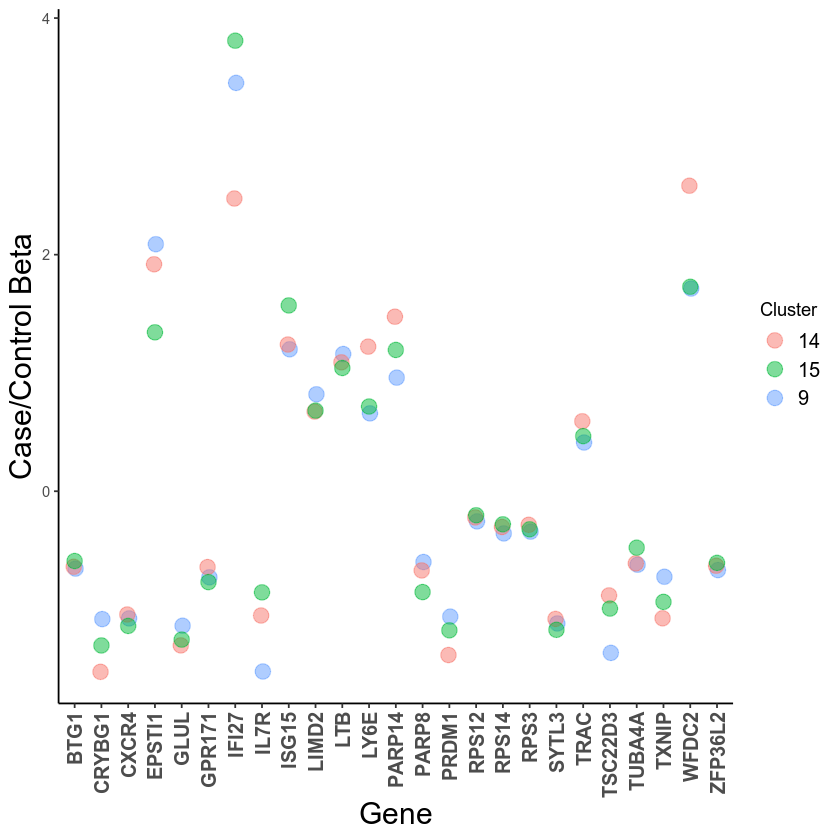

In [18]:
ggplot(shared %>% filter(!gene %in% exclude), 
        aes(x = gene, y = Beta, color = Cluster, group = Cluster)) + 
    geom_point(position = position_dodge(width = 0.1), size = 4, alpha = 0.5) +
    theme_classic() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, 
                                     hjust=1, size = 12, face = "bold"),
         axis.title = element_text(size = 18),
         legend.text = element_text(size = 12))  +
    labs(x = "Gene", y = "Case/Control Beta")

In [135]:
shared <- left_join(left_join(cluster_9_df %>% 
                        select(-SE) %>% 
                        rename(Beta_9 = Beta), 
                    cluster_14_df %>% 
                        select(-SE) %>% 
                        rename(Beta_14 = Beta), by = "gene"), 
          cluster_15_df %>% 
              select(-SE) %>% 
              rename(Beta_15 = Beta), by = "gene") %>% na.omit() 

### MASC

In [57]:
model_df <- sc_meta %>% select(sample, processing.batch, Type, nCount_RNA, percent.mt, new_cluster_number)
model_df <- model_df %>% 
                mutate(Type = ifelse(Type == "LN", 1, 0),
                       nCount_RNA = log(nCount_RNA))

In [58]:
res <- MASC.me(model_df, factor(model_df$new_cluster_number),
                contrast = "Type",
                random_effects = c("sample"),
                fixed_effects = c("nCount_RNA", "percent.mt"),
                verbose = TRUE,
                save_models = F) %>%
            dplyr::mutate(bonferroni = p.adjust(model.pvalue, method = "bonferroni")) %>%
            dplyr::arrange(model.pvalue)

Using null model: cluster ~ nCount_RNA + percent.mt + (1|sample)

Creating logistic mixed models for cluster0

Creating logistic mixed models for cluster1

Creating logistic mixed models for cluster10

Creating logistic mixed models for cluster11

Creating logistic mixed models for cluster12

Creating logistic mixed models for cluster13

Creating logistic mixed models for cluster14

Creating logistic mixed models for cluster15

Creating logistic mixed models for cluster16

Creating logistic mixed models for cluster17

Creating logistic mixed models for cluster18

Creating logistic mixed models for cluster19

Creating logistic mixed models for cluster2

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.106351 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?”
Warning

In [59]:
saveRDS(res, '/data/srlab/ssg34/SLE_kidney_v2/data/masc/t_nk/case_control.rds')

In [27]:
res <- res %>% 
        rowwise() %>% 
        mutate(cluster = ifelse(unlist(str_split(cluster, 'cluster'))[2] %in% c(0, 3), 
                                paste0('NK', unlist(str_split(cluster, 'cluster'))[2]),
                                paste0('T', unlist(str_split(cluster, 'cluster'))[2])))

Warning message:
“Removed 15 rows containing missing values (`geom_label_repel()`).”


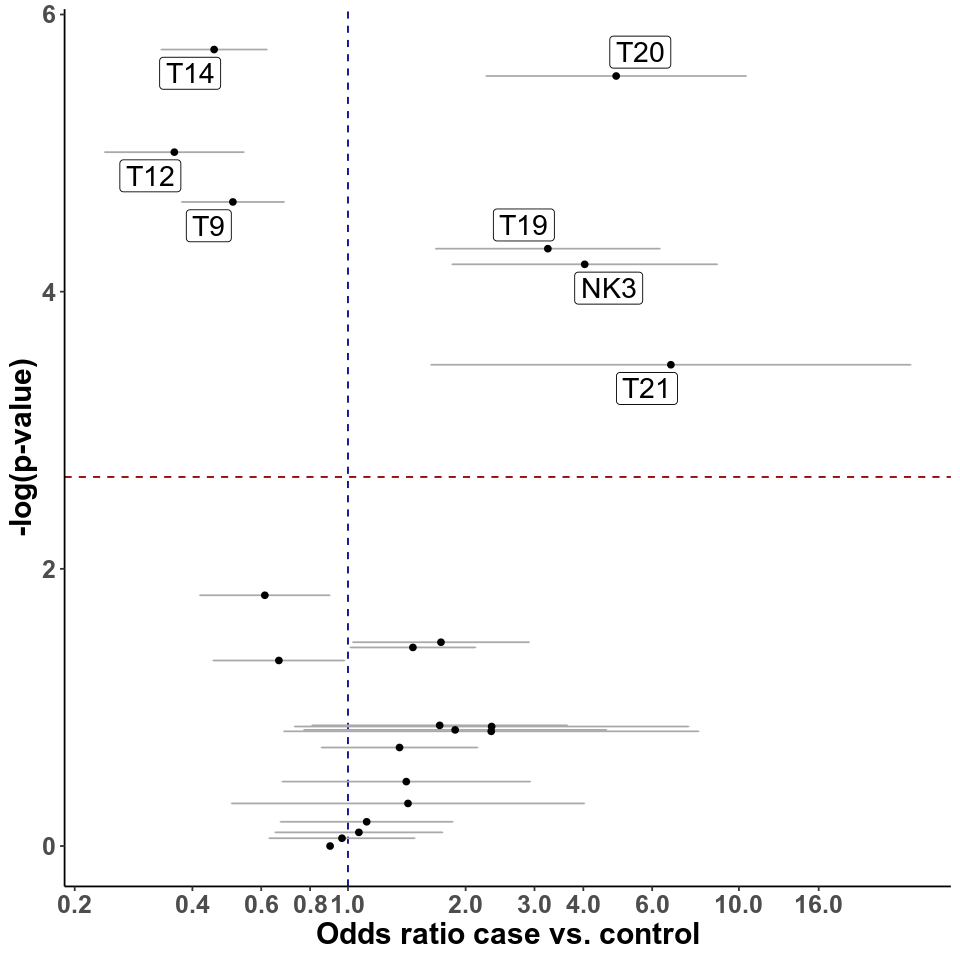

In [28]:
fig.size(8, 8)
ggplot(data = res %>% mutate(label = ifelse(-log10(model.pvalue) > -log10(0.05/23), cluster, NA)), 
       aes(x = Type.OR, y = -log10(model.pvalue))) +
    theme_classic() + ylab("-log(p-value)") + xlab("Odds ratio case vs. control") +
    geom_vline(xintercept = 1, linetype = "dashed", color = "darkblue") +
    geom_errorbar(aes(xmin=Type.OR.95pct.ci.lower	, xmax=Type.OR.95pct.ci.upper), col = "darkgrey") +
    geom_point() + 
    geom_hline(yintercept = -log10(.05/23), linetype = "dashed", color = "darkred") +
    scale_x_log10(breaks = c(0.2, 0.4, 0.6, 0.8, 1, 2.0, 3.0, 4.0, 6.0, 10.0, 16.0)) + 
    ggrepel::geom_label_repel(aes(label = label), size = 6) +
    theme(axis.title = element_text(size = 18, face = "bold"),
          axis.text = element_text(size = 15, face = "bold"))

## WITHIN CASE ASSOCIATIONS

In [30]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_NK_clusterQCd_meta_harmonizedPCUMAPclusters_annotations02062024.rds')
final_annotation = data.frame(new_cluster_number = seq(0, 21), 
                                           final_annotation = c("NK0. CD56dim NK",
                                                                 "T1. CD8+ GZMB+ CTL",
                                                                 "T2. CD8+ GZMB+ SYNE2bright CTL",
                                                                 "NK3. CD56bright NK",
                                                                 "T4. CENPF+ MKI67+ Proliferating",
                                                                 "T5. GZMK+ CD8+ NKG7high",
                                                                 "T6. GZMK+ CD8+ NKG7low",
                                                                 "T7. GZMK+ CD8+ Effector Memory",
                                                                 "T8. GZMK+ CD8+ NEAT1+",
                                                                 "T9. GZMK+ CD8+ Resident Memory",
                                                                 "T10. GZMK+ CD8+ ITGAE",
                                                                 "T11. CD4+ Effector Memory",
                                                                 "T12. CD8+ GMZK+ CD69+",
                                                                 "T13. CD4+ JUNlow Resident Memory",
                                                                 "T14. CD4+ JUNhigh Resident Memory",
                                                                 "T15. CD4+ S1PR1+ Central memory/Naive",
                                                                 "T16. KLRB1+ KIT+ ILC",
                                                                 "T17. CD4+ RORC+ CCR6+ Th17",
                                                                 "T18. CD4+ Central Memory/Naive",
                                                                 "T19. CD4+ IL2RA++ FOXP3++ Treg",
                                                                 "T20. CD4+ FOXP3+ Central Memory/Naive",
                                                                 "T21. CD4+ PDCD1+ CXCR5+ TFH/TPH"))

qcd_meta <- qcd_meta %>% left_join(final_annotation)

tnk_rawcounts <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_NK_clusterQCd_rawcounts_03062023.rds')
mito_genes_subset <- c("MT-ND5", "MT-ND6")
percent_mito <- colSums(tnk_rawcounts[mito_genes_subset, ]) / colSums(tnk_rawcounts) * 100
percent_mito <- data.frame(cell = names(percent_mito), percent.mt = percent_mito)

qcd_meta <- qcd_meta %>% left_join(percent_mito)

Joining, by = "new_cluster_number"
Joining, by = "cell"


In [31]:
first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])

In [32]:
sc_meta <- qcd_meta[, !colnames(qcd_meta) %in% colnames(clinical)] %>% 
                        mutate(kid_sample = qcd_meta$sample) %>% 
                        filter(dataset == 'scRNAseq') %>% 
                        mutate(individual = str_split(kid_sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical) %>% 
                        left_join(first_biop_pred) %>% 
                        filter(Type == "LN") %>% 
                        select(c(cell, paste0('hPC', 1:20), Sex, hUMAP1, hUMAP2, sample, final_annotation,
                                 Responder.Status, Age, Race, Final_ISN, Final_Chronicity, Final_Activity, Type, Final_Site,
                                 First_biop, Pred_use)) 

sn_meta <- qcd_meta[, !colnames(qcd_meta) %in% colnames(clinical)] %>% 
                        mutate(kid_sample = qcd_meta$sample) %>% 
                        filter(dataset == 'snRNAseq') %>% 
                        mutate(individual = str_split(kid_sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical) %>% 
                        left_join(first_biop_pred) %>% 
                        filter(Type == "LN") %>% 
                        select(c(cell, paste0('hPC', 1:20), Sex, hUMAP1, hUMAP2, sample, final_annotation,
                                 Responder.Status, Age, Race, Final_ISN, Final_Chronicity, Final_Activity, Type, Final_Site,
                                 First_biop, Pred_use)) 

Joining, by = "individual"
Joining, by = "individual"
Joining, by = "individual"
Joining, by = "individual"


### AGE

In [364]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Age)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")






write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sn_meta_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sn_harmony_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sn_umap_age.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [366]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Age)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_meta_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_harmony_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_umap_age.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### SEX

In [367]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[which(meta$Sex %in% c("Female", "Male"))]
meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sn_meta_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sn_harmony_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sn_umap_sex.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [368]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[which(meta$Sex %in% c("Female", "Male"))]
meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_meta_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_harmony_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_umap_sex.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### RESPONSE

In [411]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[which(meta$Responder.Status %in% c("NR", "CR", "PR"))]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")





write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sn_meta_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sn_harmony_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sn_umap_response.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [7]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[which(meta$Responder.Status %in% c("NR", "CR", "PR"))]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

sc_pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/sc_injured_pt_prop_07142023.rds')

meta <- left_join(meta, sc_pt_meta)

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_meta_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_harmony_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_umap_response.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"
Joining, by = "sample"


#### RESULTS

In [103]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_meta_response.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_umap_response.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_response_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_response_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

#### MASC

In [ ]:
model_df <- meta %>% 
                left_join(qcd_meta %>% select(cell, nCount_RNA, percent.mt, new_cluster_number)) %>%
                mutate(nCount_RNA = log(nCount_RNA))

res <- MASC.me(model_df, as.factor(model_df$new_cluster_number),
                contrast = "Responder_Status",
                random_effects = c("sample"),
                fixed_effects = c("nCount_RNA", "percent.mt"),
                verbose = TRUE,
                save_models = F) %>%
            dplyr::mutate(bonferroni = p.adjust(model.pvalue, method = "bonferroni")) %>%
            dplyr::arrange(model.pvalue)

In [ ]:
res <- res %>% 
        rowwise() %>% 
        mutate(cluster = ifelse(unlist(str_split(cluster, 'cluster'))[2] %in% c(0, 3), 
                                paste0('NK', unlist(str_split(cluster, 'cluster'))[2]),
                                paste0('T', unlist(str_split(cluster, 'cluster'))[2])))

In [ ]:
fig.size(8, 8)
ggplot(data = res %>% mutate(label = ifelse(-log10(model.pvalue) > -log10(0.05), cluster, NA)), 
       aes(x = Responder_Status.OR, y = -log10(model.pvalue))) +
    theme_classic() + ylab("-log(p-value)") + xlab("Odds ratio Responder Status") +
    geom_vline(xintercept = 1, linetype = "dashed", color = "darkblue") +
    geom_errorbar(aes(xmin=Responder_Status.OR.95pct.ci.lower	, xmax=Responder_Status.OR.95pct.ci.upper), col = "darkgrey") +
    geom_point() + 
    geom_hline(yintercept = -log10(.05), linetype = "dashed", color = "darkred") +
    scale_x_log10(breaks = c(0.2, 0.4, 0.6, 0.8, 1, 2.0, 3.0, 4.0, 6.0, 10.0, 16.0)) + 
    ggrepel::geom_label_repel(aes(label = label), size = 6) +
    theme(axis.title = element_text(size = 18, face = "bold"),
          axis.text = element_text(size = 15, face = "bold"))

#### CNA

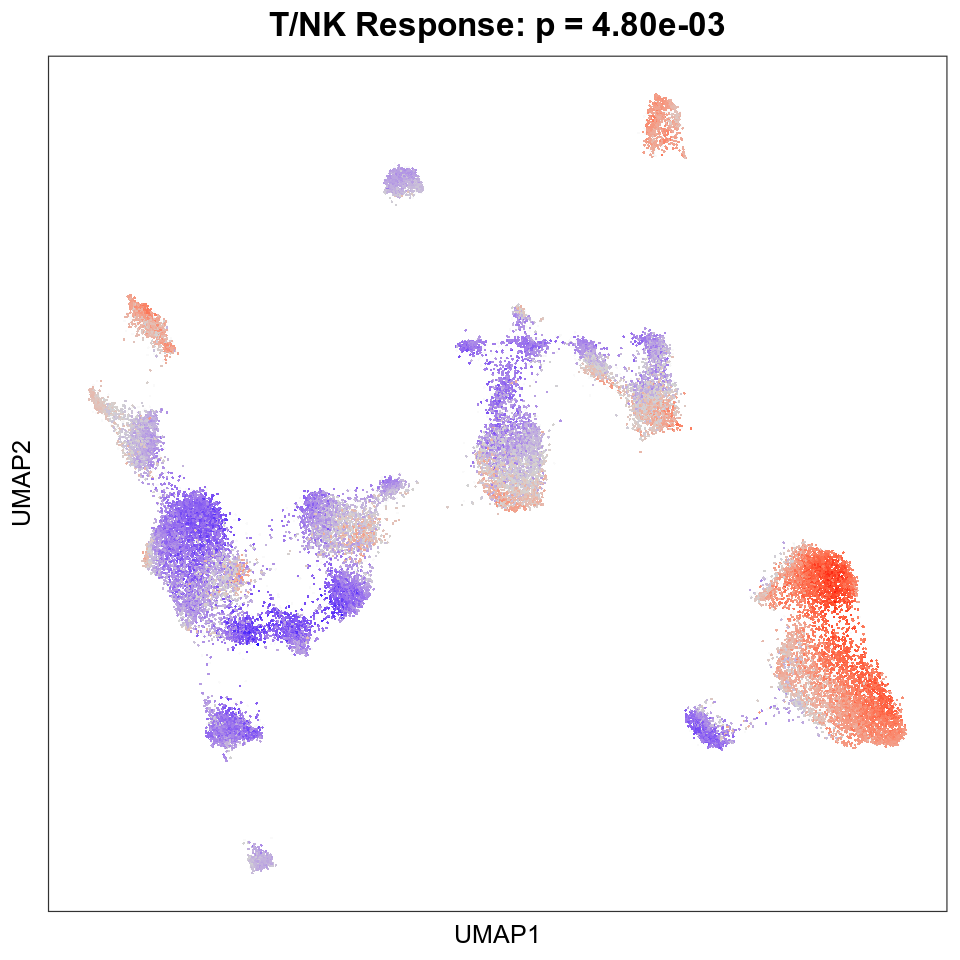

In [107]:
fdr_10 <- fdrs %>% filter(fdr < 0.1) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% mutate(ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA))
tmp_meta <- cbind(tmp_meta, umap)


fig.size(8, 8)
ggplot() + 
      geom_point(data = qcd_meta, 
                     aes(x = hUMAP1, y = hUMAP2), color = 'lightgrey', alpha = 0.1, size = 0.75, stroke = 0.00001) +
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = hUMAP1, y = hUMAP2, color = correlation), size = 0.75, stroke = 0.0001) +  
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="UMAP1", y="UMAP2", title = "T/NK Response: p = 4.80e-03") +
      theme_bw(base_size = 15) +
  theme( legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) 

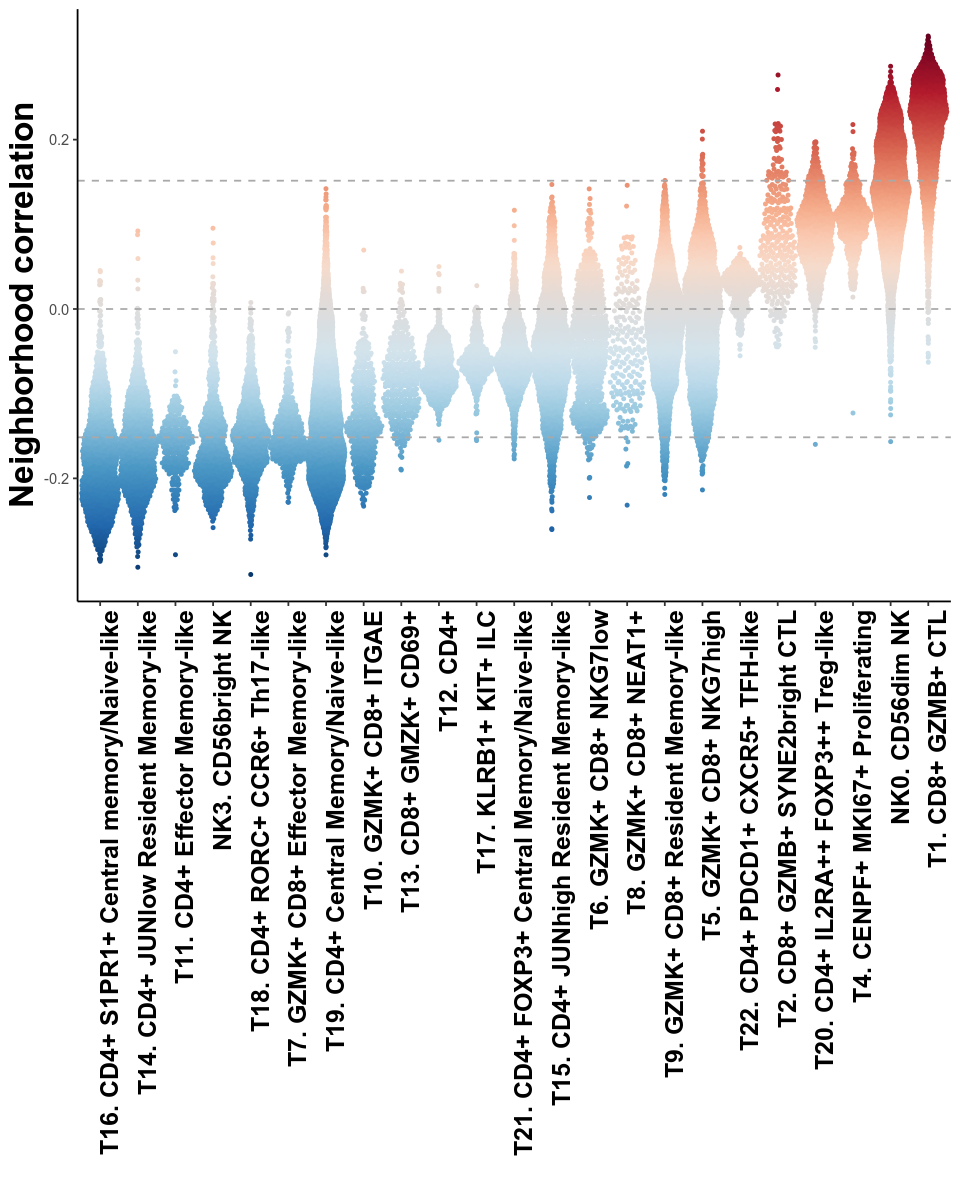

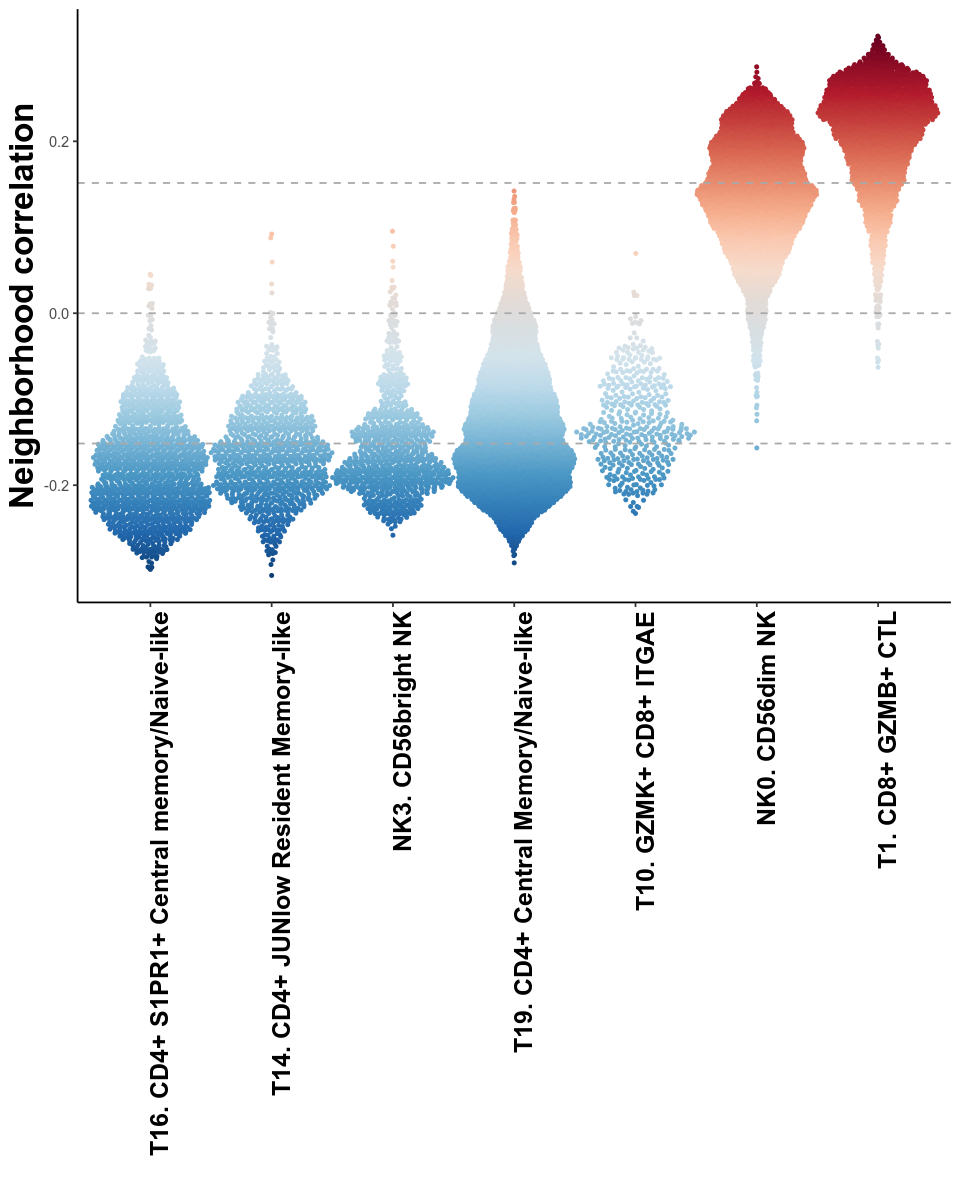

In [74]:
pos_fdr_thresh <- fdr_10
neg_fdr_thresh <- -1 * fdr_10

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(10, 8)

ggplot(meta, aes(x = reorder(final_annotation, ncorr), y = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.5, size = 0.75) +
    geom_hline(yintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    labs( x= "", y = "Neighborhood correlation") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=22, face = "bold"),
        axis.text.x = element_text(color = "black", size = 15, angle = 90, hjust=1, face = "bold"),
        axis.title = element_text(size=20, face = "bold"))

ggplot(meta %>% filter(final_annotation %in% c('T16. CD4+ S1PR1+ Central memory/Naive-like',
                                               'T14. CD4+ JUNlow Resident Memory-like',
                                               'NK3. CD56bright NK',
                                               'T19. CD4+ Central Memory/Naive-like',
                                               'T10. GZMK+ CD8+ ITGAE',
                                               'NK0. CD56dim NK',
                                               'T1. CD8+ GZMB+ CTL')), aes(x = reorder(final_annotation, ncorr), y = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.5, size = 0.75) +
    geom_hline(yintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    labs( x= "", y = "Neighborhood correlation") +
    scale_x_discrete(limits = c('T16. CD4+ S1PR1+ Central memory/Naive-like',
                                               'T14. CD4+ JUNlow Resident Memory-like',
                                               'NK3. CD56bright NK',
                                               'T19. CD4+ Central Memory/Naive-like',
                                                'T10. GZMK+ CD8+ ITGAE',
                                               'NK0. CD56dim NK',
                                               'T1. CD8+ GZMB+ CTL')) + 
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=22, face = "bold"),
        axis.text.x = element_text(color = "black", size = 15, angle = 90, hjust=1, face = "bold"),
        axis.title = element_text(size=20, face = "bold"))

In [4]:
pt_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_meta_response.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_umap_response.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_injured_pt_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_injured_pt_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
pt_meta$ncorr <- ncorr$V1


meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_meta_response.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_umap_response.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_response_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_response_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

chron_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_covariate_cond_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_covariate_cond_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
chron_meta$ncorr <- ncorr$V1

Joining, by = "cell"


[1] -0.8289712

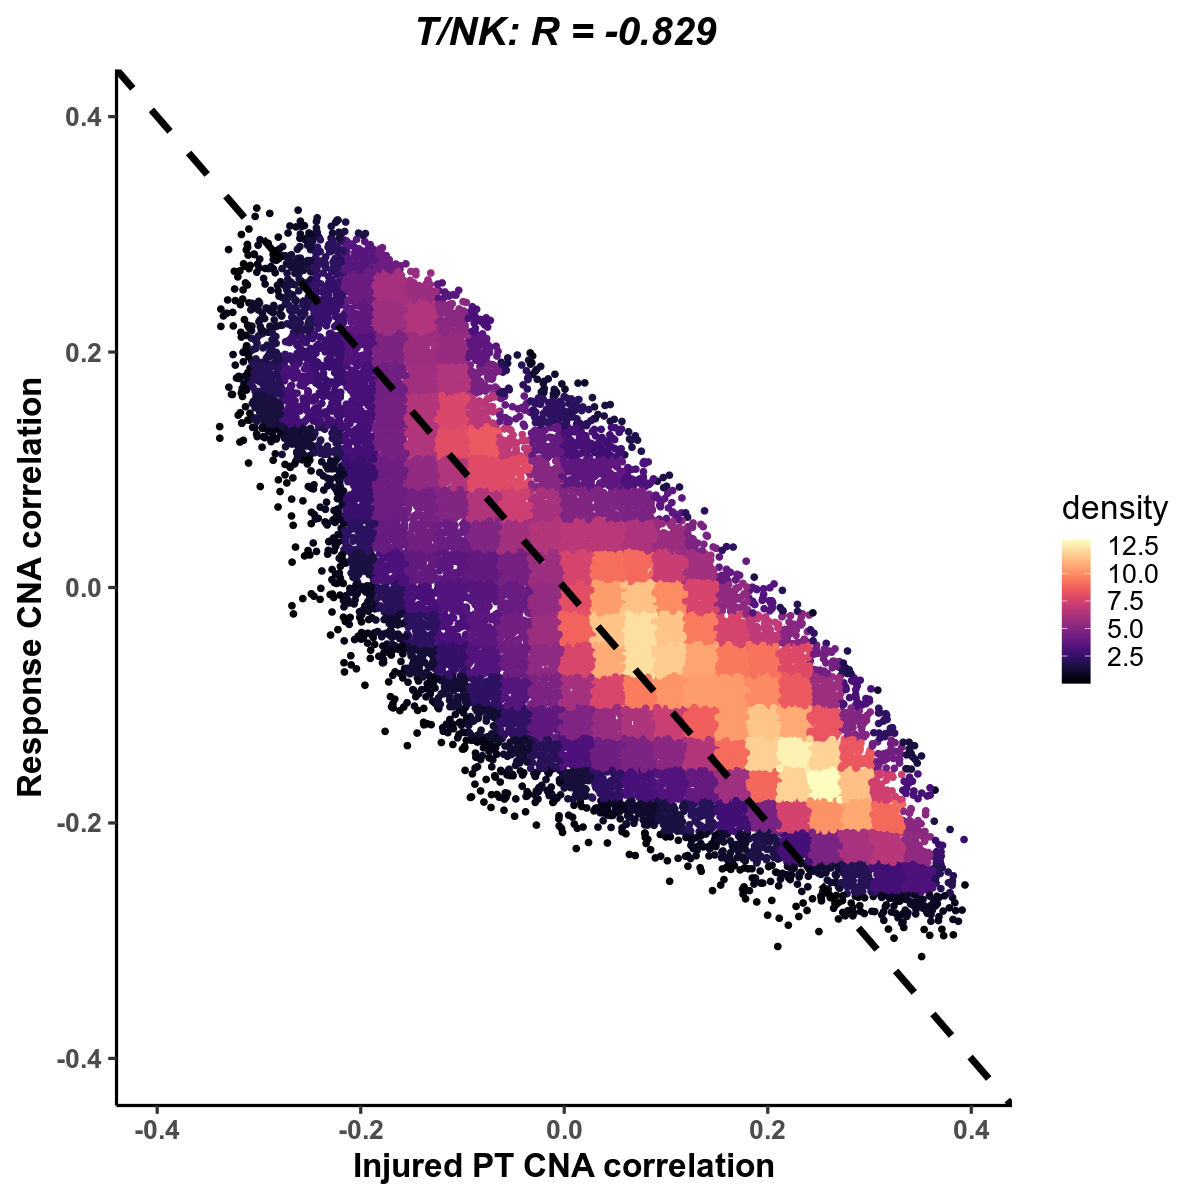

In [19]:
ncorr_meta <- pt_meta %>% 
                    select(cell, ncorr) %>% 
                    rename(pt_ncorr = ncorr) %>% 
                left_join(meta %>% 
                            select(cell, ncorr) %>% 
                            rename(chronicity_ncorr = ncorr)) %>% na.omit()

get_density <- function(x, y, ...) {
  dens <- MASS::kde2d(x, y, ...)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

ncorr_meta$density <- get_density(ncorr_meta$pt_ncorr, ncorr_meta$chronicity_ncorr)

fig.size(10, 10)
cor(ncorr_meta$pt_ncorr, ncorr_meta$chronicity_ncorr)
ggplot(ncorr_meta, aes(x = pt_ncorr, y = chronicity_ncorr, color = density)) +
    geom_point() +
    scale_color_viridis(option = "magma") + 
    theme_classic(base_size = 20) +
    geom_abline(slope = -1, linetype = 'dashed', linewidth = 2) + 
    scale_x_continuous(limits = c(-0.4, 0.4)) + 
    scale_y_continuous(limits = c(-0.4, 0.4)) + 
    labs(x = "Injured PT CNA correlation",
         y = "Response CNA correlation",
         title = "T/NK: R = -0.829") + 
    theme(
          axis.text = element_text(face = "bold"),
          axis.title = element_text(face = "bold"),
          plot.title = element_text(face = "bold.italic", 
                                    hjust = 0.5))

Joining, by = "cell"


[1] -0.8078947

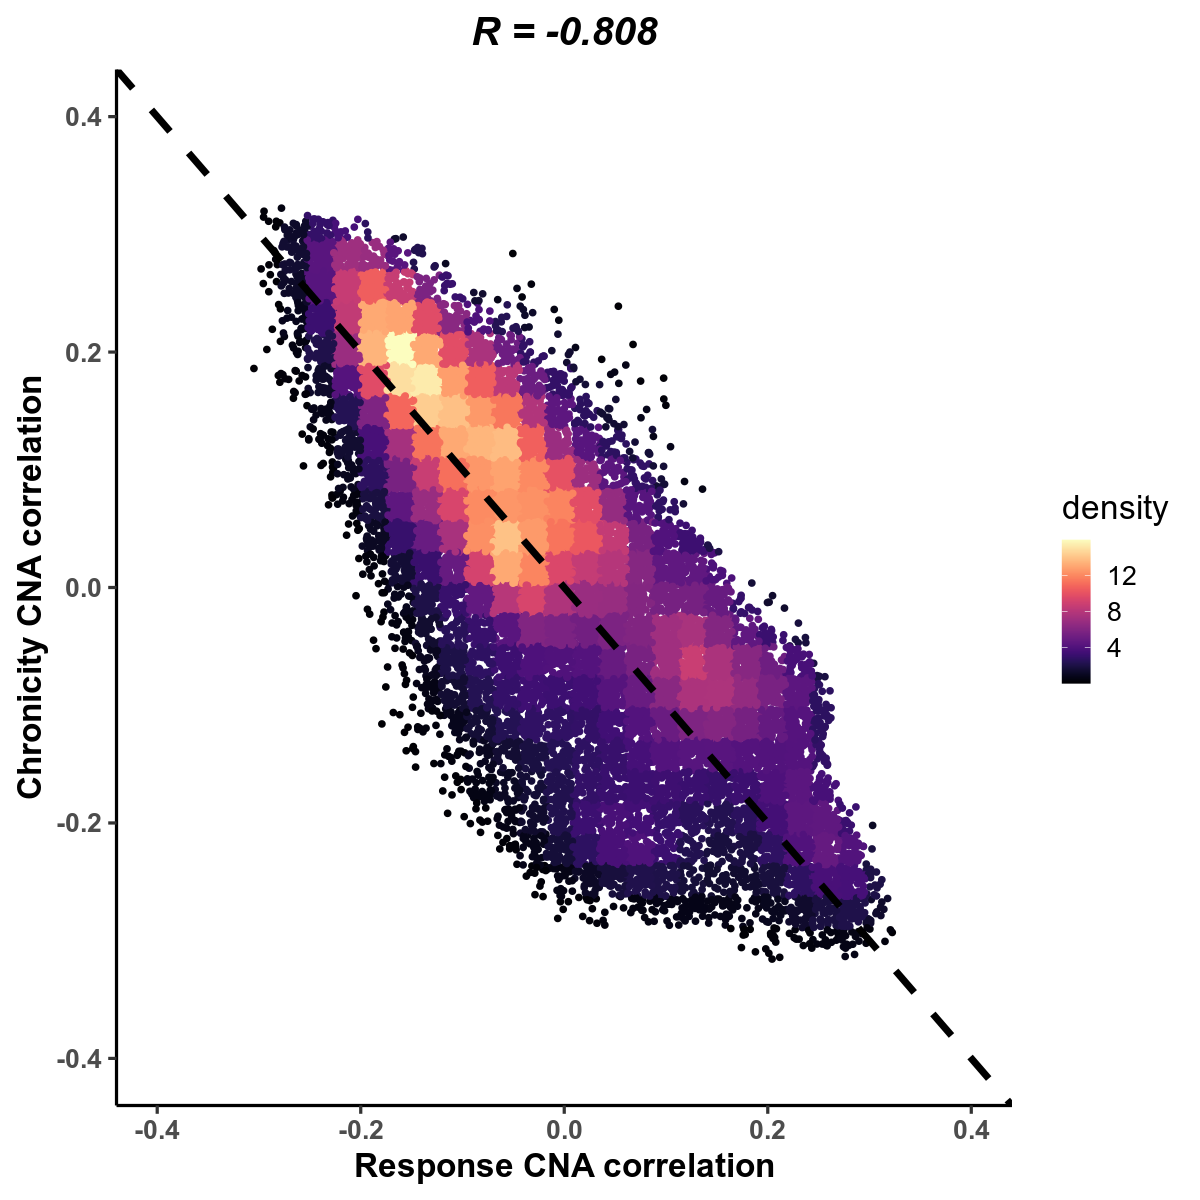

In [7]:
ncorr_meta <- chron_meta %>% 
                    select(cell, ncorr) %>% 
                    rename(chronicity_ncorr = ncorr) %>% 
                left_join(meta %>% 
                            select(cell, ncorr) %>% 
                            rename(response_ncorr = ncorr)) %>% na.omit()

get_density <- function(x, y, ...) {
  dens <- MASS::kde2d(x, y, ...)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

ncorr_meta$density <- get_density(ncorr_meta$chronicity_ncorr, ncorr_meta$response_ncorr)

fig.size(10, 10)
cor(ncorr_meta$response_ncorr, ncorr_meta$chronicity_ncorr)
ggplot(ncorr_meta, aes(x = response_ncorr, y = chronicity_ncorr, color = density)) +
    geom_point() +
    scale_color_viridis(option = "magma") + 
    theme_classic(base_size = 20) +
    geom_abline(slope = -1, linetype = 'dashed', linewidth = 2) + 
    scale_x_continuous(limits = c(-0.4, 0.4)) + 
    scale_y_continuous(limits = c(-0.4, 0.4)) + 
    labs(x = "Response CNA correlation",
         y = "Chronicity CNA correlation",
         title = "R = -0.808") + 
    theme(
          axis.text = element_text(face = "bold"),
          axis.title = element_text(face = "bold"),
          plot.title = element_text(face = "bold.italic", 
                                    hjust = 0.5))

### RACE

In [371]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Race)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sn_meta_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sn_harmony_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sn_umap_race.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [372]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Race)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_meta_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_harmony_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/age_sex_response_race/sc_umap_race.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### FIRST BIOPSY

In [373]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$First_biop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sn_meta_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sn_harmony_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sn_umap_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [374]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$First_biop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sc_meta_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sc_harmony_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sc_umap_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### PRED USE

In [375]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Pred_use)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sn_meta_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sn_harmony_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sn_umap_preduse.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [376]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Pred_use)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sc_meta_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sc_harmony_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sc_umap_preduse.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### SITE

In [377]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Site)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sn_meta_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sn_harmony_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sn_umap_site.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [378]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Site)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sc_meta_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sc_harmony_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/first_biop_pred_use_site/sc_umap_site.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### Chronicity

In [358]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- which(is.na(meta$Final_Chronicity))
meta <- meta[-ind, ]
harmony <- harmony[-ind, ]
umap <- umap[-ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [356]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- which(is.na(meta$Final_Chronicity))
meta <- meta[-ind, ]
harmony <- harmony[-ind, ]
umap <- umap[-ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [357]:
meta

cell                                  Sex sample              
1    ACACCCTTCACGCGGT-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
2    ACTGAGTAGGTAAACT-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
3    AGAATAGGTTACGGAG-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
4    AGTGAGGCAATGTAAG-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
5    ATTGGTGTCCTATTCA-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
6    CAAGTTGGTGTTGAGG-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
7    CACACCTCAGGGTATG-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
8    CATCCACCATTATCTC-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
9    CCCTCCTTCAAACCGT-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
10   CCTTTCTCATCGACGC-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
11   CGAGCCAGTCTAGTCA-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
12   CGGACGTAGAGGGATA-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
13   CGGTTAACATGGTAGG-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
14   CGTCCATCAAACCCAT-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
15   CTCGGGAGTCTCACCT-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
16   CTGTTTATCACAGTAC-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
17   CTTAGGAAGCGATAGC-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
18   GAATGAAGTGCGGTAA-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
19   GACCTGGTCCATGAGT-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
20   GATCGTATCGGCTACG-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
21   GATCTAGTCTCCAACC-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
22   GCAGCCACACCGGAAA-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
23   GGATTACCACAGGCCT-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
24   GGCAATTTCCCTGACT-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
25   GTCATTTAGTTTAGGA-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
26   TAAACCGTCGATAGAA-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
27   TACGGTAGTAGGAGTC-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
28   TCACAAGCAGGTCGTC-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
29   TCATTTGCAAGCGAGT-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
30   TCATTTGCAGTGACAG-1-AMPSLEkid_nuc_0137 1   AMPSLEkid_cells_0137
⋮    ⋮                                     ⋮   ⋮                   
2091 GCACGGTTCAACTCTT-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2092 GCAGCTGTCGGCTCTT-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2093 GCGAGAACACTACCGG-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2094 GGAAGTGGTCGGCCTA-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2095 GGAATCTGTCCTTTGC-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2096 GGACGTCTCTTGCAGA-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2097 GGGTCACGTGCTGTCG-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2098 GGTCACGCATGGCACC-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2099 GTAGGTTCAAGAATAC-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2100 GTGCGTGAGGAGACCT-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2101 GTTAGTGGTTCCTACC-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2102 TACCGGGAGCCTAGGA-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2103 TCACAAGTCTACGCAA-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2104 TCAGCCTGTCAACGCC-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2105 TCATCCGCACCGCTGA-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2106 TCCACGTGTCGGTGTC-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2107 TCCATGCTCGTCCTCA-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2108 TCCCAGTTCGGCTGAC-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2109 TCCTCCCCAATCTGCA-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2110 TCGATTTAGAAGCTGC-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2111 TCGCTCATCGGTAGGA-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2112 TCTACATTCGATTTCT-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2113 TCTGGCTAGCACTAAA-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2114 TGAGGGATCGAACACT-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2115 TGATCAGGTATTCCGA-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2116 TGGATGTGTCGATTCA-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cells_2877
2117 TGGTAGTGTGAGAGGG-1-AMPSLEkid_nuc_2877 2   AMPSLEkid_cell

#### Results - NO CONDITIONING

In [39]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

#### MASC

In [ ]:
model_df <- meta %>% 
                left_join(qcd_meta %>% select(cell, nCount_RNA, percent.mt, new_cluster_number)) %>%
                mutate(nCount_RNA = log(nCount_RNA))

res <- MASC.me(model_df, as.factor(model_df$new_cluster_number),
                contrast = "Final_Chronicity",
                random_effects = c("sample"),
                fixed_effects = c("nCount_RNA", "percent.mt"),
                verbose = TRUE,
                save_models = F) %>%
            dplyr::mutate(bonferroni = p.adjust(model.pvalue, method = "bonferroni")) %>%
            dplyr::arrange(model.pvalue)

In [596]:
saveRDS(res, '/data/srlab/ssg34/SLE_kidney_v2/data/masc/t_nk/chronicity.rds')

In [597]:
res <- res %>% 
        rowwise() %>% 
        mutate(cluster = ifelse(unlist(str_split(cluster, 'cluster'))[2] %in% c(0, 3), 
                                paste0('NK', unlist(str_split(cluster, 'cluster'))[2]),
                                paste0('T', unlist(str_split(cluster, 'cluster'))[2])))

Warning message:
“Removed 20 rows containing missing values (`geom_label_repel()`).”


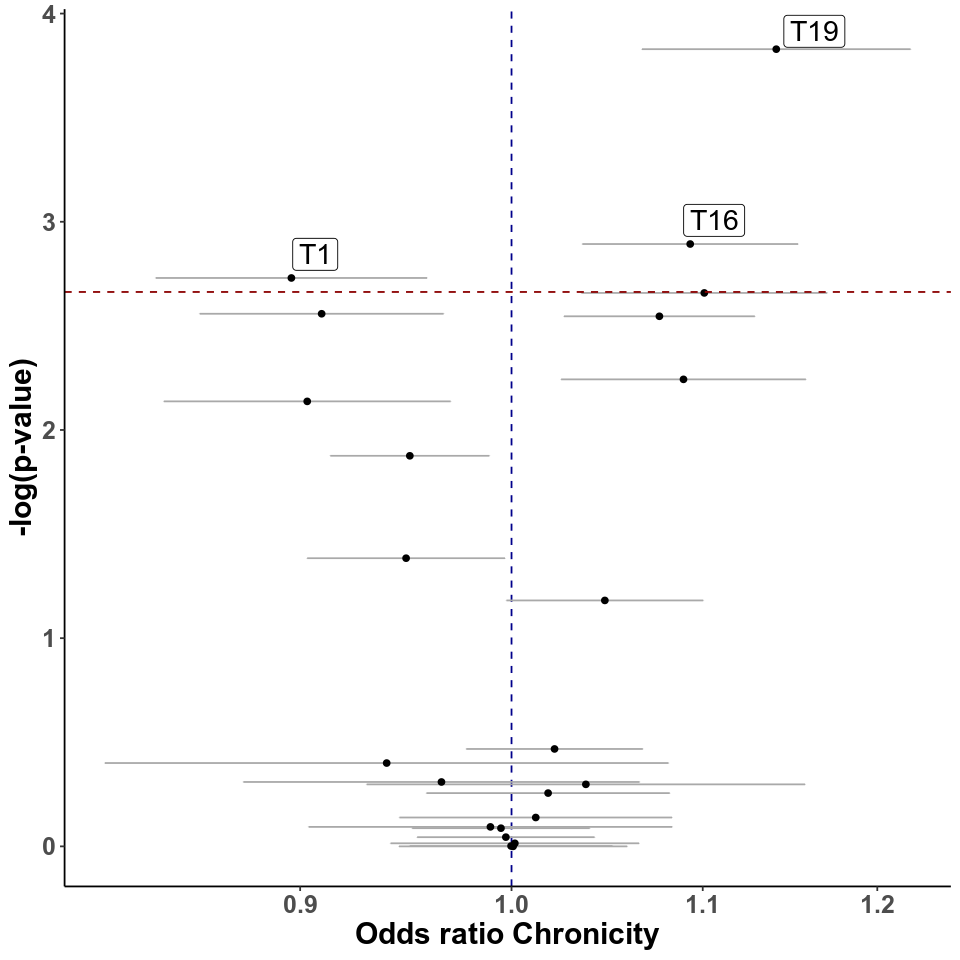

In [608]:
fig.size(8, 8)
ggplot(data = res %>% mutate(label = ifelse(-log10(model.pvalue) > -log10(0.05/23), cluster, NA)), 
       aes(x = Final_Chronicity.OR, y = -log10(model.pvalue))) +
    theme_classic() + ylab("-log(p-value)") + xlab("Odds ratio Chronicity") +
    geom_vline(xintercept = 1, linetype = "dashed", color = "darkblue") +
    geom_errorbar(aes(xmin=Final_Chronicity.OR.95pct.ci.lower	, xmax=Final_Chronicity.OR.95pct.ci.upper), col = "darkgrey") +
    geom_point() + 
    geom_hline(yintercept = -log10(.05/ 23), linetype = "dashed", color = "darkred") +
    scale_x_log10(breaks = c(0.8, 0.9, 1, 1.1, 1.2)) + 
    ggrepel::geom_label_repel(aes(label = label), size = 6) +
    theme(axis.title = element_text(size = 18, face = "bold"),
          axis.text = element_text(size = 15, face = "bold"))

#### CNA

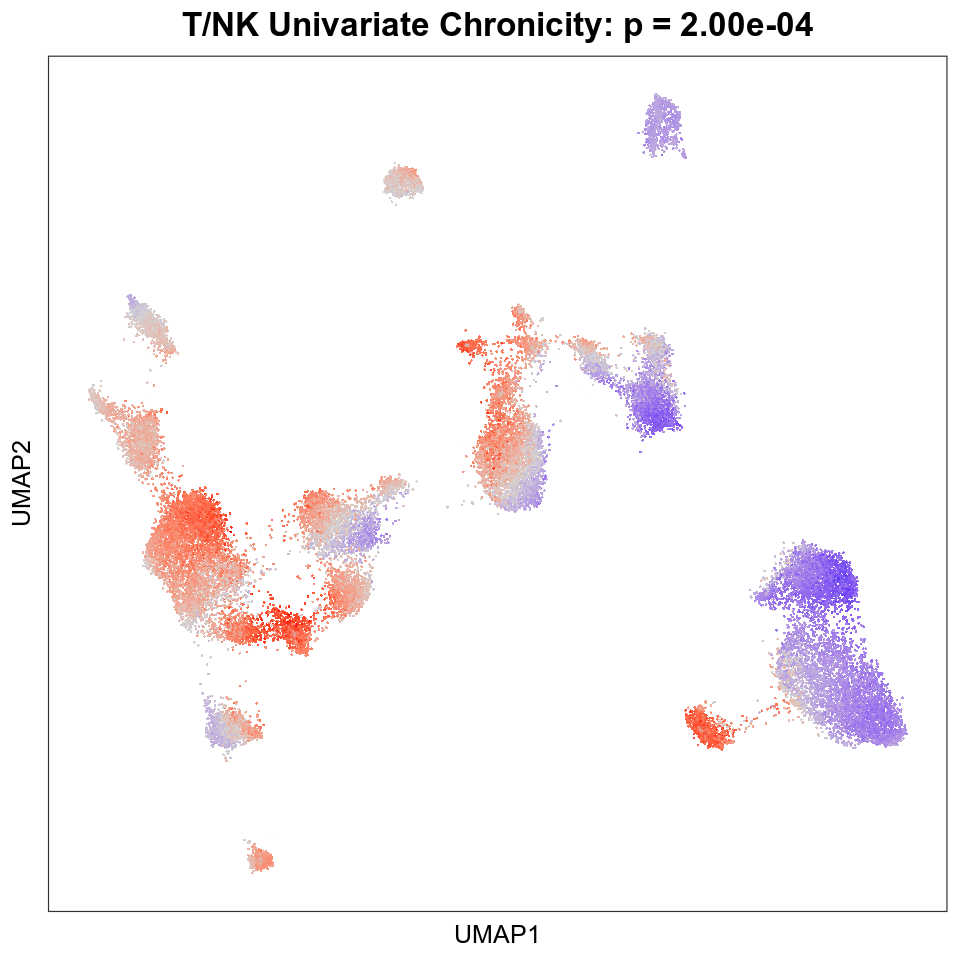

In [40]:
fdr_10 <- fdrs %>% filter(fdr < 0.1) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% mutate(ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA))
tmp_meta <- cbind(tmp_meta, umap)

fig.size(8, 8)
ggplot() + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = hUMAP1, y = hUMAP2, color = correlation), size = 0.75, stroke = 0.00001) + 
      geom_point(data = qcd_meta %>% filter(dataset == 'snRNAseq'),
                     aes(x = hUMAP1, y = hUMAP2), color = 'lightgrey', alpha = 0.1, size = 0.75, stroke = 0.00001) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="UMAP1", y="UMAP2", title = "T/NK Univariate Chronicity: p = 2.00e-04") +
      theme_bw(base_size = 15) +
  theme( legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) 

In [480]:
clusters <- qcd_meta %>% 
                           filter(new_cluster_number %in% c(0, 1, 2, 5, 6, 3, 14, 16, 17, 19)) %>% 
                       pull(final_annotation) %>% unique()

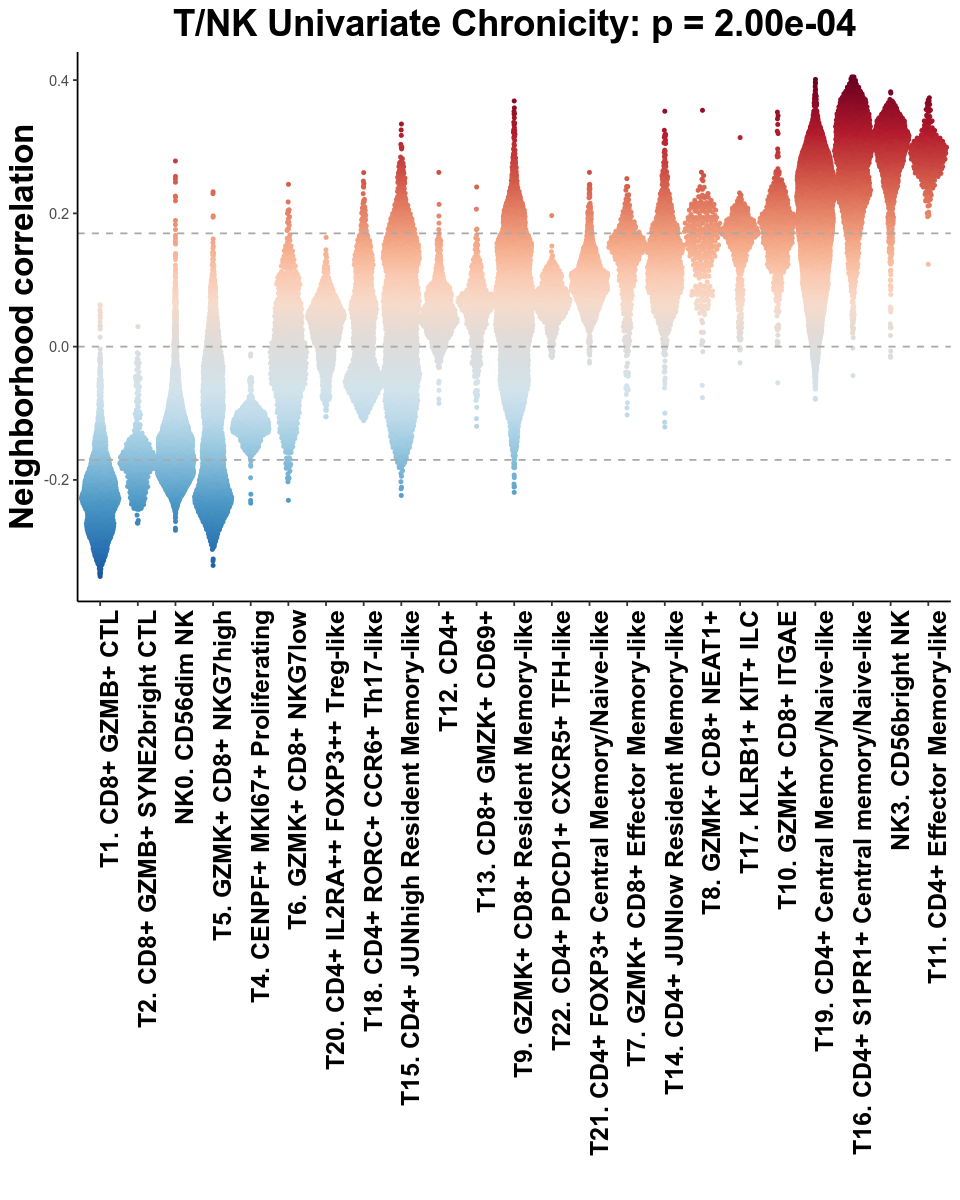

In [30]:
pos_fdr_thresh <- fdr_10
neg_fdr_thresh <- -1 * fdr_10

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(10, 8)

cluster_order <- meta %>% select(final_annotation, ncorr) %>% group_by(final_annotation) %>% summarize(ncorr = mean(ncorr)) %>% arrange(ncorr) %>% pull(final_annotation)

ggplot(meta, aes(x = reorder(final_annotation, ncorr), y = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.5, size = 0.75) +
    geom_hline(yintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    labs( x= "", y = "Neighborhood correlation", title = "T/NK Univariate Chronicity: p = 2.00e-04") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=22, face = "bold", hjust = 0.5),
        axis.text.x = element_text(color = "black", size = 15, angle = 90, hjust=1, face = "bold"),
        axis.title = element_text(size=20, face = "bold"))

In [ ]:
ggplot(meta %>% filter(final_annotation %in% clusters), aes(x = reorder(final_annotation, ncorr), y = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.5, size = 0.75) +
    geom_hline(yintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    labs( x= "", y = "Neighborhood correlation") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=22, face = "bold"),
        axis.text.x = element_text(color = "black", size = 15, angle = 90, hjust=1, face = "bold"),
        axis.title = element_text(size=20, face = "bold"))

#### Results - CONDITIONING

In [94]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_conditional_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_conditional_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

In [107]:
qcd_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_NK_clusterQCd_meta_harmonizedPCUMAPclusters_annotations02062024.rds')

ci_summary <- meta %>% left_join(qcd_meta %>% select(cell, new_cluster_number)) %>% 
                select(new_cluster_number, cell, ncorr) %>% 
                group_by(new_cluster_number) %>% 
                summarize(ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")"))
res <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/masc/t_nk/chronicity_covariates.rds') %>% 
        mutate(new_cluster_number = as.numeric(str_remove(cluster, "cluster")),
               OR.ci = paste0("(", round(Final_Chronicity.OR.95pct.ci.lower, 3), ", ", 
                              round(Final_Chronicity.OR.95pct.ci.upper, 3), ")")) %>% 
        select(new_cluster_number, OR.ci)

summary <- ci_summary %>% left_join(res)
write.table(summary, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/tnk_chronicity_corr_04152024.csv', quote = FALSE, row.names = FALSE,
            sep = "\t")

Joining, by = "cell"
Joining, by = "new_cluster_number"


#### MASC

In [425]:
model_df <- meta %>% 
                left_join(qcd_meta %>% select(cell, nCount_RNA, percent.mt, new_cluster_number)) %>%
                mutate(nCount_RNA = log(nCount_RNA))

res <- MASC.me(model_df, as.factor(model_df$new_cluster_number),
                contrast = "Final_Chronicity",
                random_effects = c("sample"),
                fixed_effects = c('First_biop', 'Responder_Status'),
                verbose = TRUE,
                save_models = F) %>%
            dplyr::mutate(bonferroni = p.adjust(model.pvalue, method = "bonferroni")) %>%
            dplyr::arrange(model.pvalue)

Joining, by = "cell"
Using null model: cluster ~ First_biop + Responder_Status + (1|sample)

Creating logistic mixed models for cluster0

Creating logistic mixed models for cluster1

Creating logistic mixed models for cluster10

Creating logistic mixed models for cluster11

Creating logistic mixed models for cluster12

Creating logistic mixed models for cluster13

Creating logistic mixed models for cluster14

Creating logistic mixed models for cluster15

Creating logistic mixed models for cluster16

Creating logistic mixed models for cluster17

Creating logistic mixed models for cluster18

Creating logistic mixed models for cluster19

Creating logistic mixed models for cluster2

Creating logistic mixed models for cluster20

Creating logistic mixed models for cluster21

Creating logistic mixed models for cluster3

Creating logistic mixed models for cluster4

Creating logistic mixed models for cluster5

Creating logistic mixed models for cluster6

Creating logistic mixed models for clust

In [426]:
saveRDS(res, '/data/srlab/ssg34/SLE_kidney_v2/data/masc/t_nk/chronicity_covariates.rds')

In [427]:
res <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/masc/t_nk/chronicity_covariates.rds')

In [429]:
res <- res %>% 
        rowwise() %>% 
        mutate(cluster = ifelse(unlist(str_split(cluster, 'cluster'))[2] %in% c(0, 3), 
                                paste0('NK', unlist(str_split(cluster, 'cluster'))[2]),
                                paste0('T', unlist(str_split(cluster, 'cluster'))[2])))

Warning message:
“Removed 14 rows containing missing values (`geom_label_repel()`).”


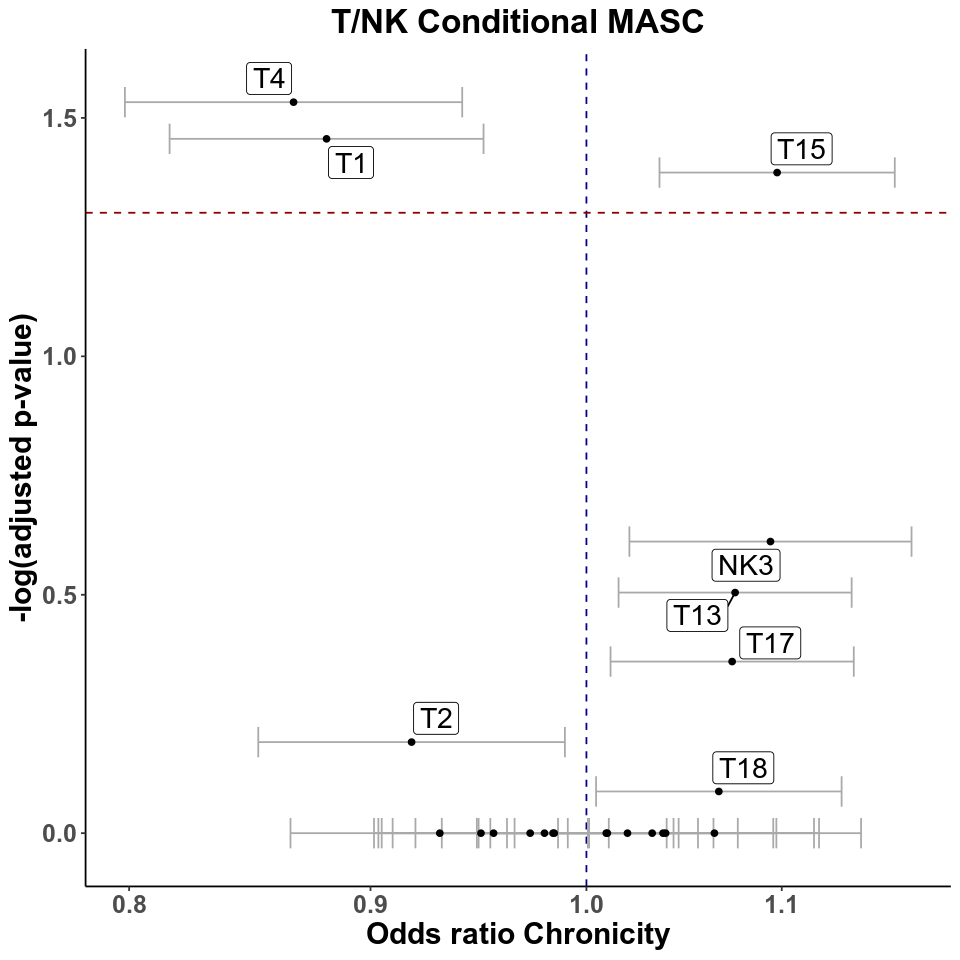

In [433]:
fig.size(8, 8)
ggplot(data = res %>% mutate(label = ifelse(-log10(model.pvalue) > -log10(0.05), cluster, NA)), 
       aes(x = Final_Chronicity.OR, y = -log10(bonferroni))) +
    theme_classic() + ylab("-log(adjusted p-value)") + xlab("Odds ratio Chronicity") + 
    labs(title = "T/NK Conditional MASC") +
    geom_vline(xintercept = 1, linetype = "dashed", color = "darkblue") +
    geom_errorbar(aes(xmin=Final_Chronicity.OR.95pct.ci.lower	, xmax=Final_Chronicity.OR.95pct.ci.upper), col = "darkgrey") +
    geom_point() + 
    geom_hline(yintercept = -log10(.05), linetype = "dashed", color = "darkred") +
    scale_x_log10(breaks = c(0.8, 0.9, 1, 1.1, 1.2)) + 
    ggrepel::geom_label_repel(aes(label = label), size = 6) +
    theme(plot.title = element_text(size = 20, hjust = 0.5, face = "bold"),
          axis.title = element_text(size = 18, face = "bold"),
          axis.text = element_text(size = 15, face = "bold"))

#### CNA

In [2]:
fdr_5 <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% mutate(ifelse(abs(meta$ncorr) > fdr_5, ncorr, NA))
tmp_meta <- cbind(tmp_meta, umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = qcd_meta,
                 aes(x = hUMAP1, y = hUMAP2), color = 'lightgrey', size = 0.75, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = hUMAP1, y = hUMAP2, color = correlation), size = 0.75, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
                           #breaks = c(-0.3, -0.15, 0, 0.15, 0.3)) + 
     # labs(x="UMAP1", y="UMAP2", title = "T/NK Chronicity: p = 0.006") +
theme_classic(base_size = 15) +
  theme(
    legend.position = "right",
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x="", y="", title = "", color = "r") 

ERROR: Error in fdrs %>% filter(fdr < 0.05) %>% mutate(fdr = round(fdr, 4)) %>% : could not find function "%>%"


In [17]:
fdr_5 <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

Joining, by = c("final_annotation", "new_cluster_number")


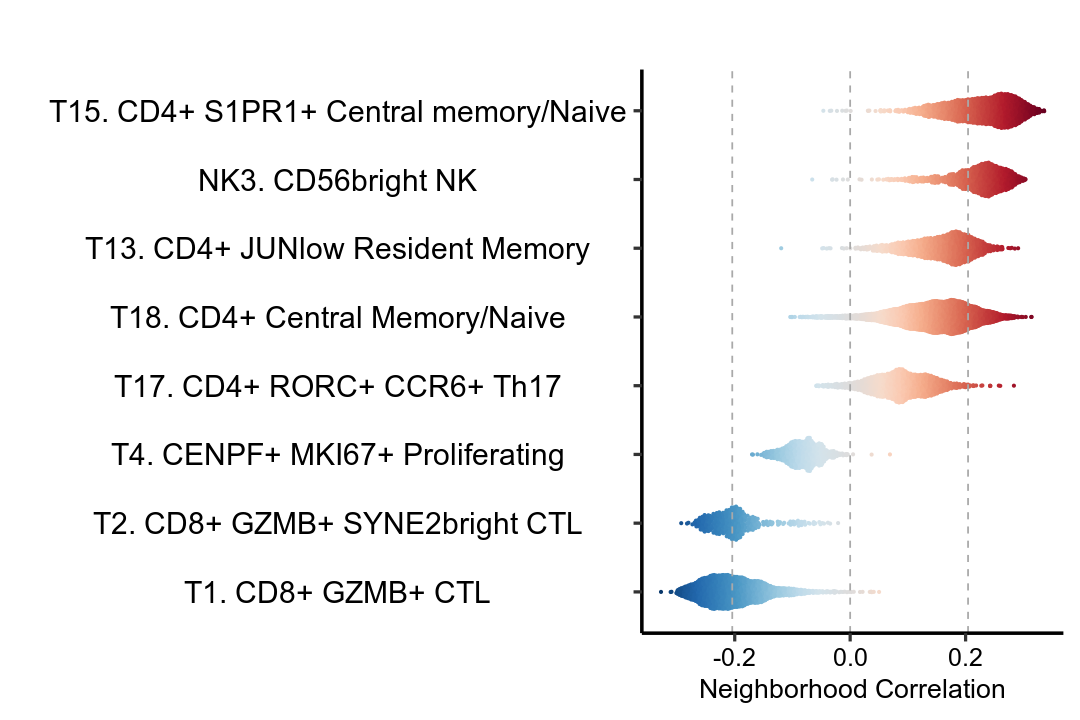

In [513]:
pos_fdr_thresh <- fdr_5
neg_fdr_thresh <- -1 * fdr_5

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(10, 8)

meta <- meta %>% left_join(final_annotation)
subset <- c(1, 2, 3, 4, 13, 15, 17, 18)
fig.size(6, 9)

ggplot(meta %>% filter(new_cluster_number %in% subset), aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic(base_size = 20) +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=16, hjust = 0.5),
        axis.line.x.bottom = element_line(color = 'black', linewidth = 1),
        axis.line.y.left   = element_line(color = 'black', linewidth = 1))

#### DE

In [48]:
de <- function(feature, df) {
    model_df <- df %>% select(feature, sample, First_biop, Responder_Status, 
                              Final_Chronicity, avg_count, avg_mt) %>% rename(Exp = feature)
    if (sum(model_df$Exp > 0) > 0.05 * nrow(model_df)) { 
        m_0 <- lm(Exp ~ log(avg_count) + avg_mt, data = model_df)
        m_1 <- lm(Exp ~ log(avg_count) + avg_mt + Final_Chronicity, data = model_df)
        ANNO <- anova(m_0, m_1)
        LRP <- ANNO[2,6]
        F <- ANNO[2,5]
        Beta <- summary(m_1)$coefficients['Final_Chronicity', 'Estimate']
        SE <- summary(m_1)$coefficients['Final_Chronicity', 'Std. Error']
        res <- c(gene = feature, LRP = LRP, F = F, Beta = Beta, SE = SE)
    }
    else {
        res <- c(gene = feature, LRP = NA, F = NA, Beta = NA, SE = NA)
    }
    return(res)
}

In [4]:
tnk_pb <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/TNK_norm_pseudobulk_12072023.rds')
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_meta.csv')

In [5]:
tnk_pb <- tnk_pb %>% 
                filter(sample %in% unique(meta$sample)) %>% 
                left_join(meta %>% 
                              select(sample, First_biop, Responder_Status, Final_Chronicity) %>% 
                              unique())

Joining, by = "sample"


In [49]:
de_out <- mclapply(colnames(tnk_pb)[1:36601], de, tnk_pb, mc.cores = 20)

In [64]:
de_df <- data.frame(do.call(rbind, de_out)) %>% mutate(LRP = as.numeric(LRP),
                                                       F = as.numeric(F),
                                                       Beta = as.numeric(Beta),
                                                       SE = as.numeric(SE))

In [71]:
saveRDS(de_df, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/TNK_chronicity_differential_expression_03082024.rds')

In [135]:
de_df <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/TNK_chronicity_differential_expression_03082024.rds')

In [136]:
de_df <- de_df %>% 
            na.omit() %>% 
            arrange(LRP) %>% 
            mutate(FDR = p.adjust(LRP, method = "BH")) 

In [129]:
genes <- c("CX3CR1", "MMP7", "WFDC2", "NKG7", "GZMA",
           "IL7R", "CCL5", "MIOX", "LGALS1", "GSTA1")

Warning message:
“Removed 21726 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


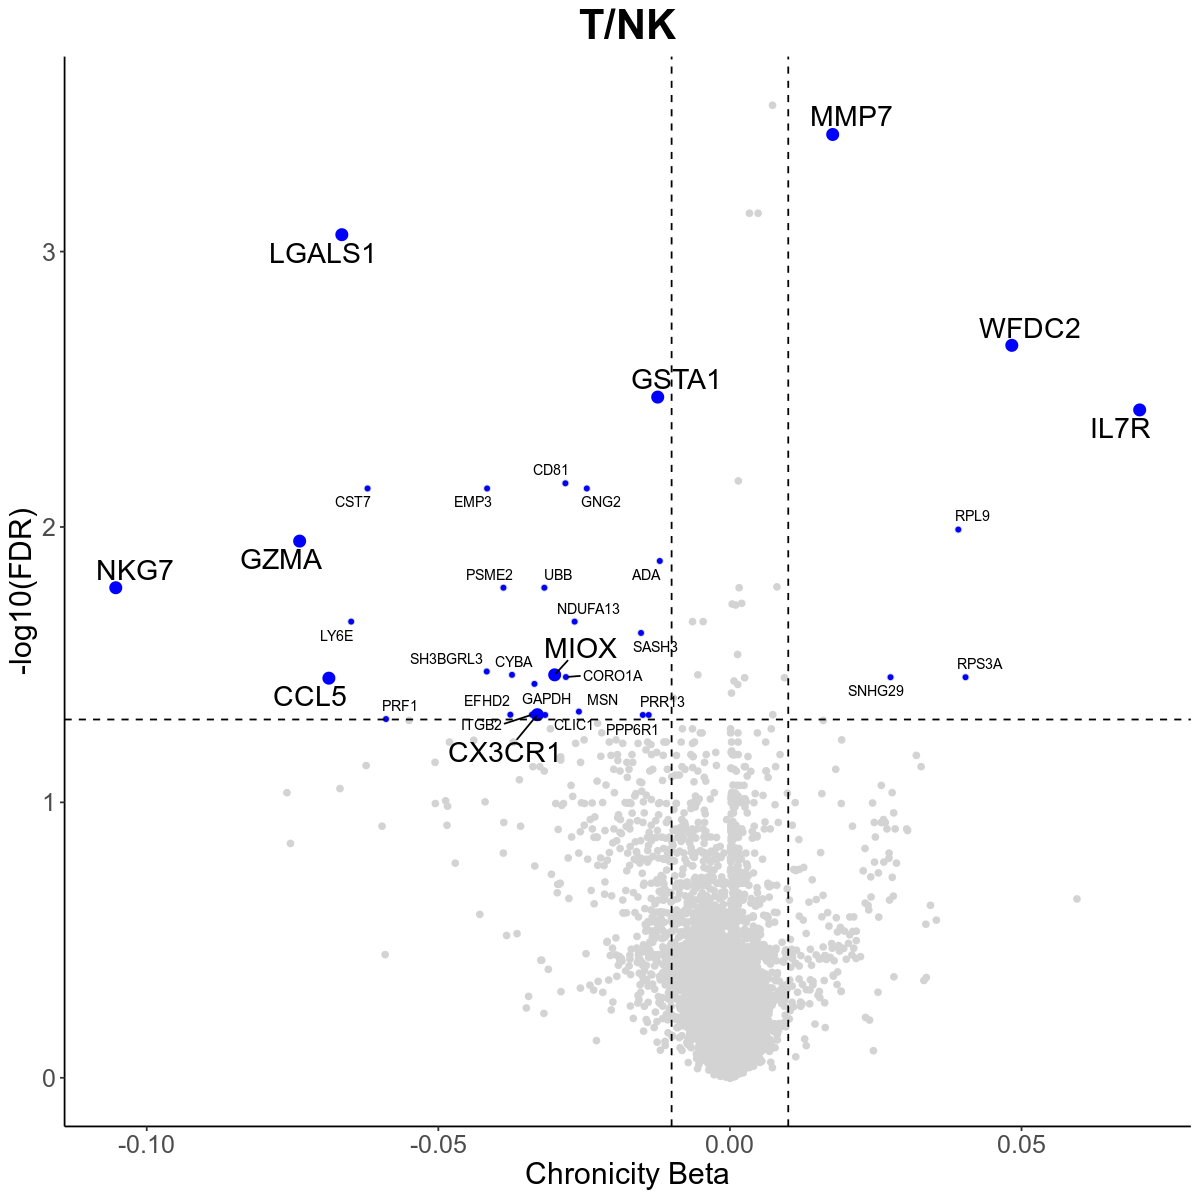

In [130]:
fig.size(10, 10)
ggplot(de_df,
                aes(x = Beta, y = -log10(FDR))) +
    geom_point(colour = 'lightgrey') + 
    geom_point(data = de_df %>% filter(FDR < 0.05 & abs(Beta) >= 0.01,
                                        ! gene %in% genes),
                   aes(x = Beta, y = -log10(FDR)),  color = "blue", size = 1) +
    geom_point(data = de_df %>% filter(gene %in% genes),
                   aes(x = Beta, y = -log10(FDR)),  color = "blue", size = 3)  + 
    geom_vline(xintercept = c(-0.01, 0.01), linetype = "dashed") + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") + 
    theme_classic() + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 25, hjust = 0.5, face = "bold")) +
    ggrepel::geom_text_repel(data = de_df %>% 
                                     mutate(label = ifelse(FDR<0.05 & abs(Beta) >= 0.01 | 
                                                           gene %in% genes, gene, NA),
                                            label_size = ifelse(gene %in% genes, 6 , 3)),
                                     aes(x = Beta, y = -log10(FDR), 
                                         size = label_size, label = label)
            , color = "black") +
    scale_size_identity() + 
    labs(x = "Chronicity Beta", y = "-log10(FDR)", title = "T/NK")

In [5]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_umap.csv')
qcd_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/qcd/T_NK_clusterQCd_norm_09092022.rds')
meta <- meta %>% cbind(umap)

In [151]:
ncorr <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_conditional_ncorr.csv', header = FALSE)

In [153]:
meta$ncorr <- ncorr$V1

In [168]:
cor.test(qcd_norm['ISG15', meta$cell], meta$ncorr)


	Pearson's product-moment correlation

data:  qcd_norm["ISG15", meta$cell] and meta$ncorr
t = -32.853, df = 31559, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1924980 -0.1711625
sample estimates:
       cor 
-0.1818517 


Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


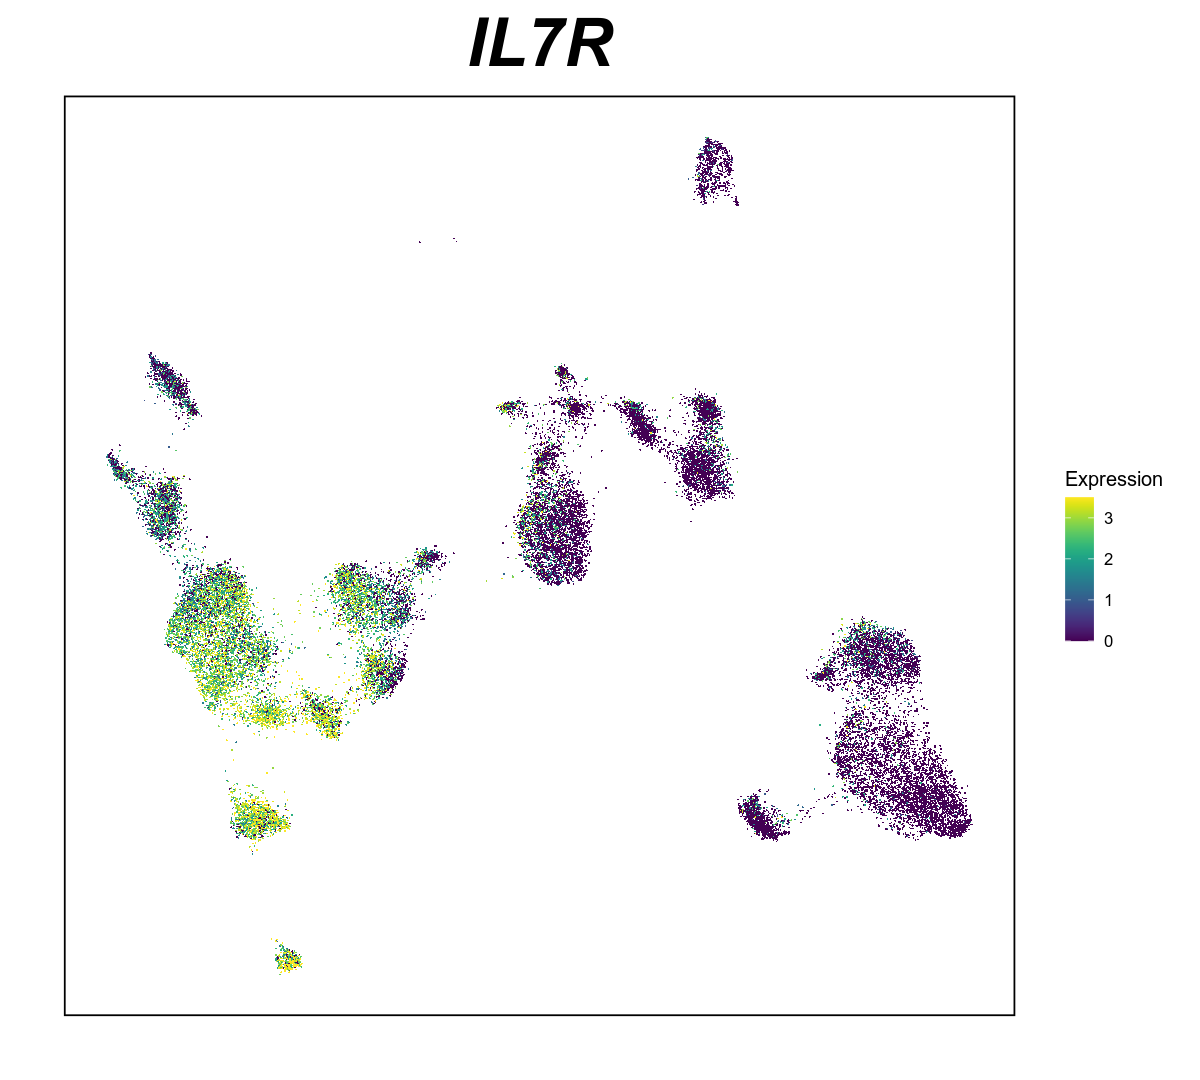

In [6]:
fig.size(9, 10)
plot_shuffled_features(meta, 
                       qcd_norm, "IL7R", 
                       pct = 0.95, 
                       pt_size = 0.75) + 
    theme(plot.title = element_text(size = 40),
                    panel.border = element_rect(colour = "black", fill=NA, size=1)) 

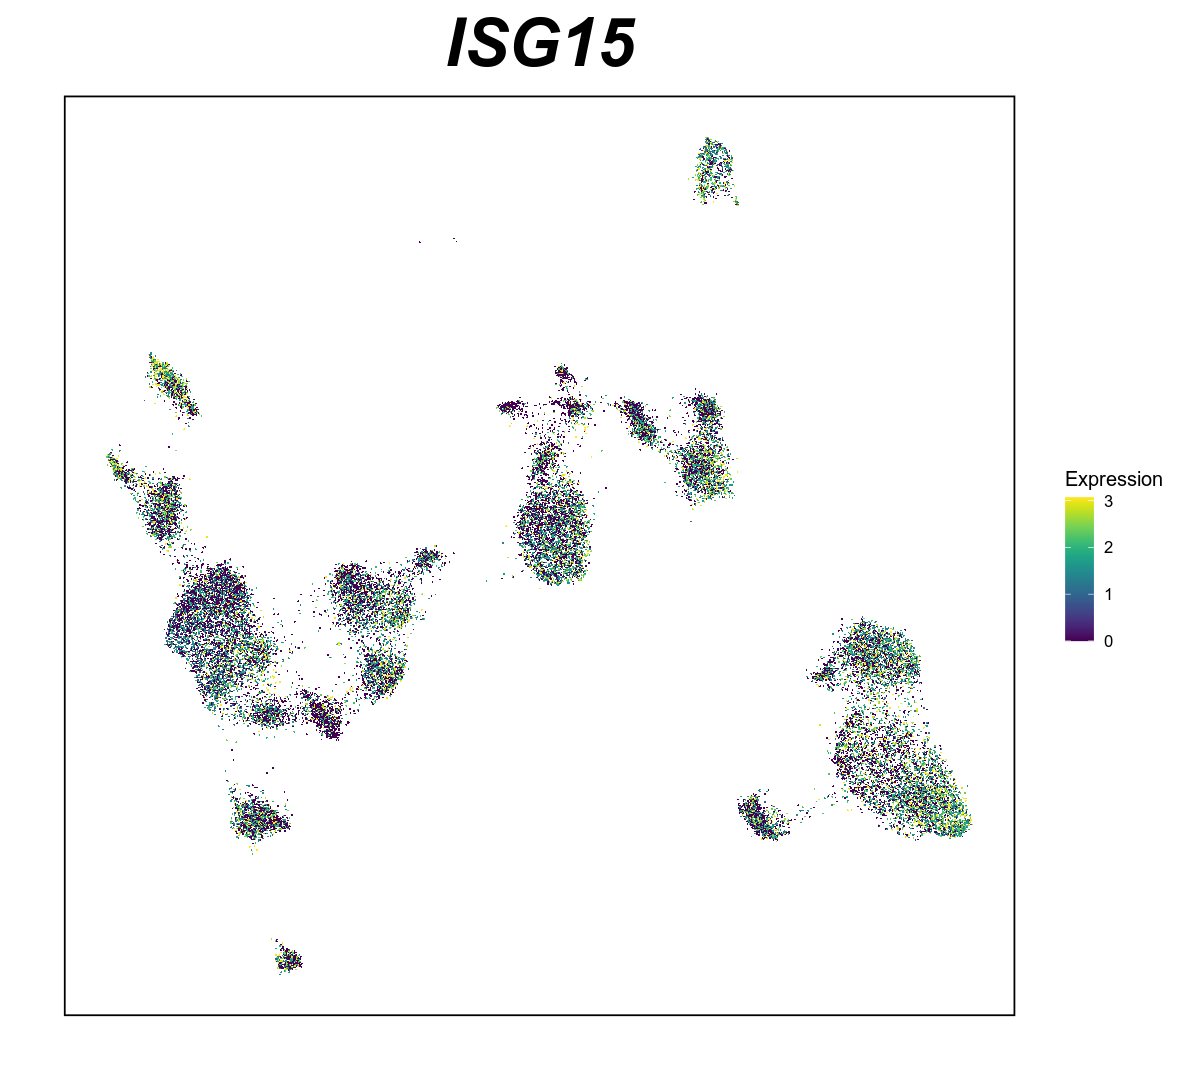

In [8]:
fig.size(9, 10)
plot_shuffled_features(meta, 
                       qcd_norm, 
                       "ISG15", 
                       pct = 0.95, 
                       pt_size = 0.75) + 
    theme(plot.title = element_text(size = 40),
                    panel.border = element_rect(colour = "black", fill=NA, size=1))

### Activity

In [381]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- which(is.na(meta$Final_Activity))
meta <- meta[-ind, ]
harmony <- harmony[-ind, ]
umap <- umap[-ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/activity/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/activity/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/activity/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [382]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- which(is.na(meta$Final_Activity))
meta <- meta[-ind, ]
harmony <- harmony[-ind, ]
umap <- umap[-ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/activity/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/activity/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/activity/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### ISN

In [383]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_ISN)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/ISN/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/ISN/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/ISN/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [385]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC', colnames(sn_meta))])

umap <- sn_meta %>% select(c(hUMAP1, hUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_ISN)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/ISN/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/ISN/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/ISN/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


### % Injured PT

In [35]:
lateinjury_high_prop <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/injured_pt_highprop_singlecell_05102024.rds') %>% 
                            select(Prop, sample)

In [43]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('hUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC', colnames(sc_meta))])

umap <- sc_meta %>% select(c(hUMAP1, hUMAP2))

meta <- meta %>% left_join(lateinjury_high_prop %>% rename(injured_pt_prop = Prop))

ind <- c(1:nrow(meta))[!is.na(meta$injured_pt_prop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)


meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/injured_pt/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/injured_pt/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/injured_pt/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "sample"
Joining, by = "Responder.Status"


Joining, by = "individual"



Call:
lm(formula = Final_Chronicity ~ injured_pt_prop, data = pt_chron)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.0845 -1.2206 -0.0351  1.1120  5.6398 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.42868    0.29767   4.800 4.03e-06 ***
injured_pt_prop  0.25735    0.02771   9.289 2.73e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.92 on 140 degrees of freedom
Multiple R-squared:  0.3813,	Adjusted R-squared:  0.3769 
F-statistic: 86.28 on 1 and 140 DF,  p-value: 2.73e-16


`geom_smooth()` using formula = 'y ~ x'


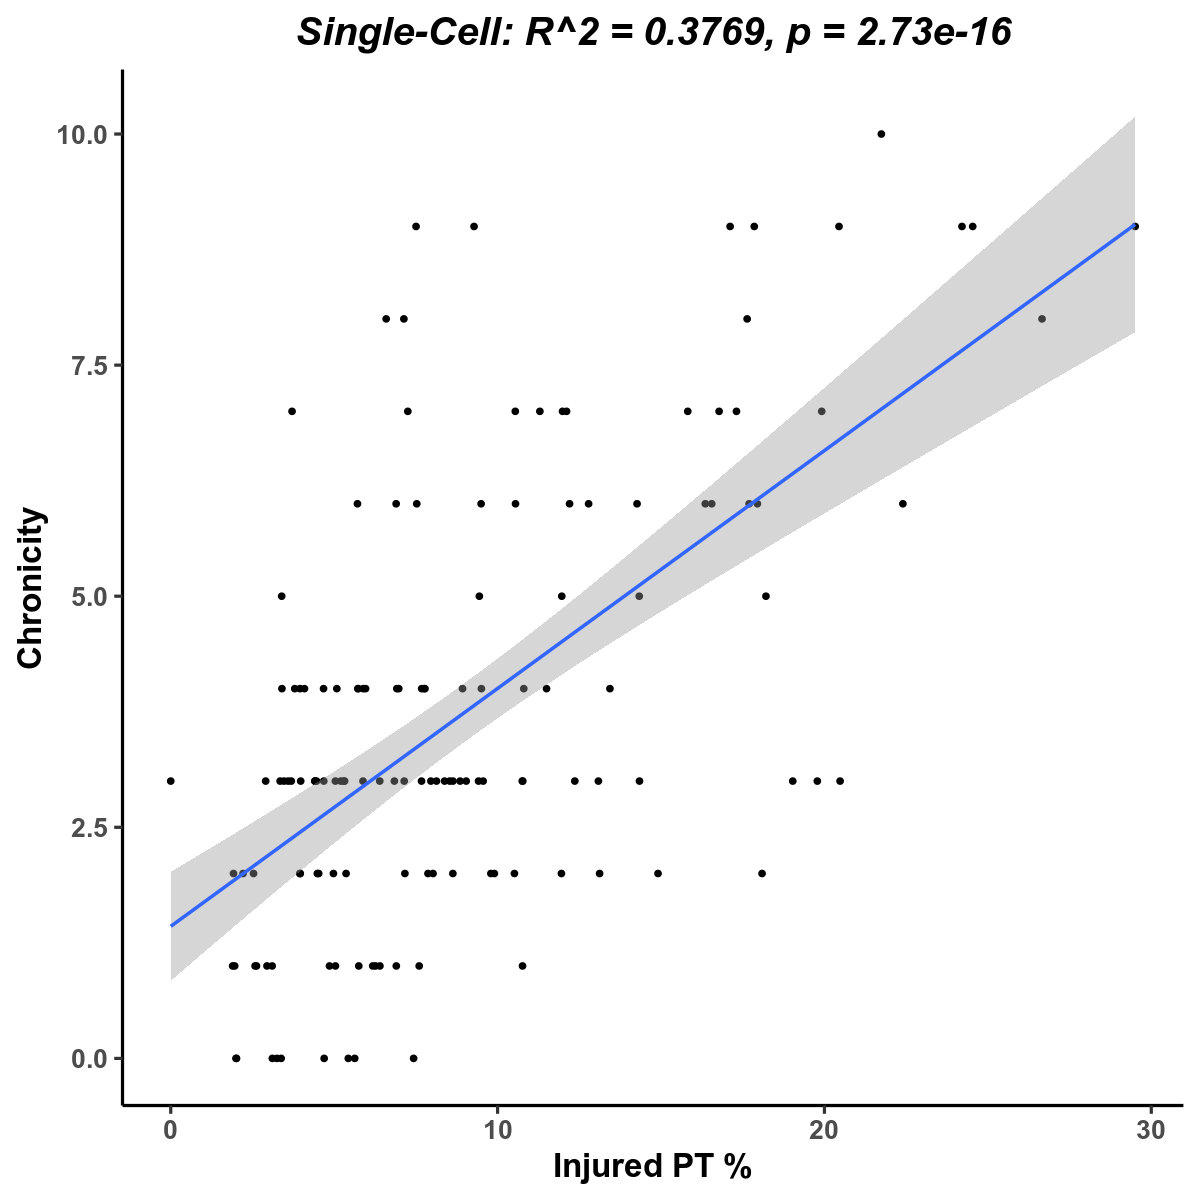

In [33]:
pt_chron <- sc_pt_meta %>%                         
                        mutate(individual = str_split(sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical %>% select(individual, Final_Chronicity)) %>% na.omit()

summary(lm(Final_Chronicity ~ injured_pt_prop, data = pt_chron))

fig.size(10, 10)
ggplot(pt_chron, aes(x = injured_pt_prop, y = Final_Chronicity)) + 
    geom_point() + 
    theme_classic(base_size = 20) +
    geom_smooth(method = "lm") + 
    labs(x = "Injured PT %", y = "Chronicity", title = "Single-Cell: R^2 = 0.3769, p = 2.73e-16") + 
    theme(plot.title = element_text(hjust = 0.5, face= "bold.italic"),
          axis.text = element_text(face = "bold"),
          axis.title = element_text(face = "bold"))

Joining, by = "individual"



Call:
lm(formula = Final_Chronicity ~ injured_pt_prop, data = pt_chron)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1271 -1.3424 -0.2293  0.7517  5.4168 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.12537    0.72786   1.546    0.132    
injured_pt_prop  0.30708    0.06422   4.782  3.5e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.018 on 33 degrees of freedom
Multiple R-squared:  0.4093,	Adjusted R-squared:  0.3914 
F-statistic: 22.87 on 1 and 33 DF,  p-value: 3.501e-05


`geom_smooth()` using formula = 'y ~ x'


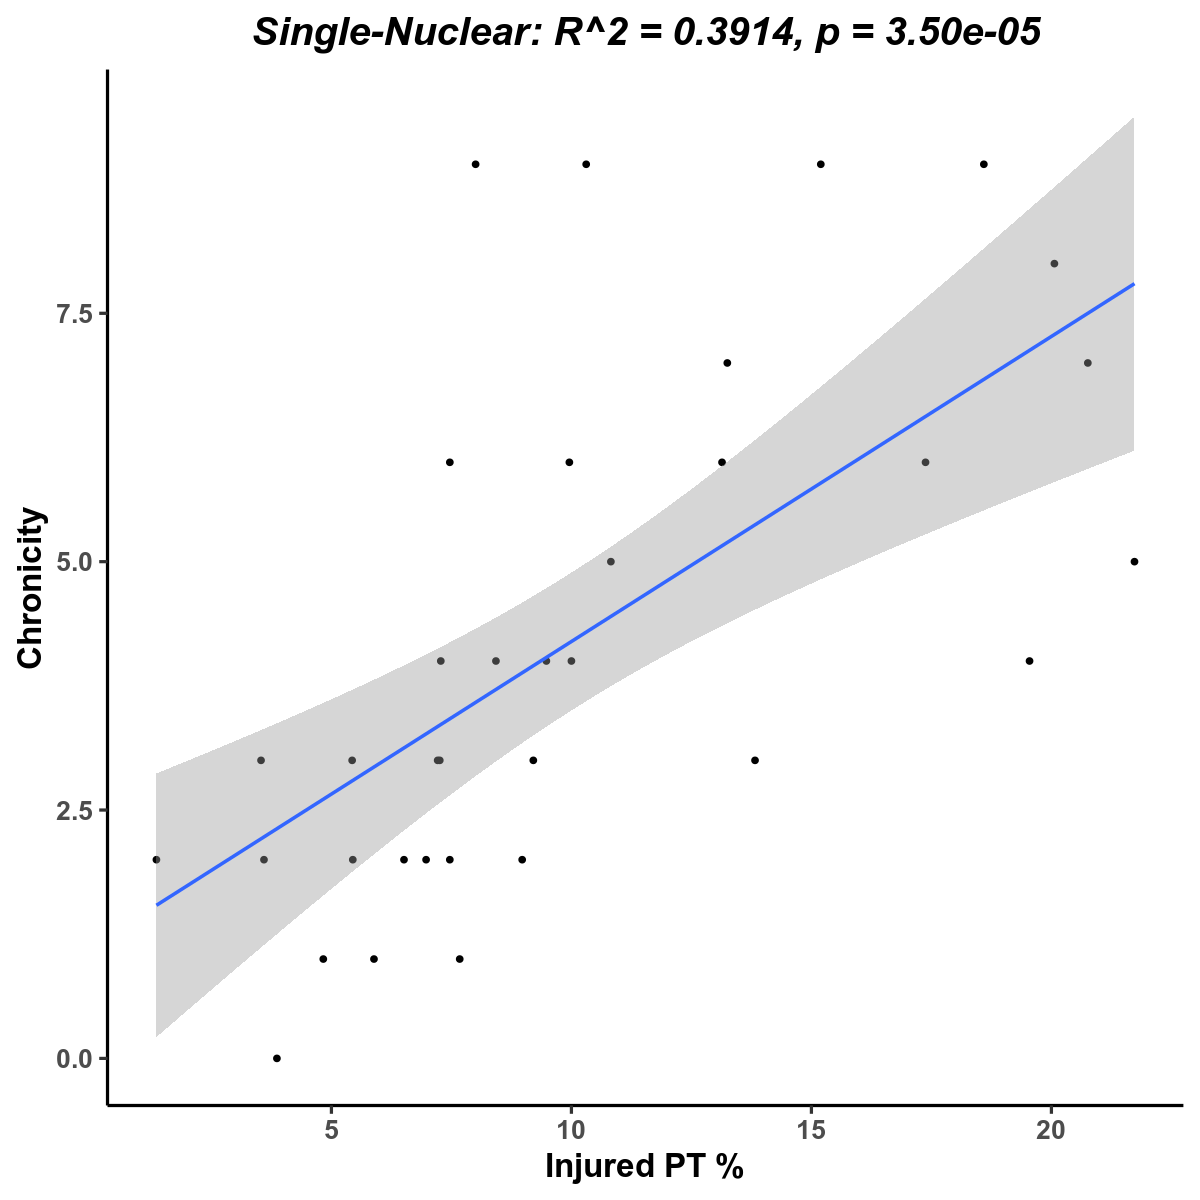

In [36]:
sn_pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/sn_injured_pt_prop_07142023.rds')
pt_chron <- sn_pt_meta %>%                         
                        mutate(individual = str_split(sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical %>% select(individual, Final_Chronicity)) %>% na.omit()

summary(lm(Final_Chronicity ~ injured_pt_prop, data = pt_chron))

fig.size(10, 10)
ggplot(pt_chron, aes(x = injured_pt_prop, y = Final_Chronicity)) + 
    geom_point() + 
    theme_classic(base_size = 20) +
    geom_smooth(method = "lm") + 
    labs(x = "Injured PT %", y = "Chronicity", 
         title = "Single-Nuclear: R^2 = 0.3914, p = 3.50e-05") + 
    theme(plot.title = element_text(hjust = 0.5, face= "bold.italic"),
          axis.text = element_text(face = "bold"),
          axis.title = element_text(face = "bold"))

#### RESULTS

In [3]:
pt_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/injured_pt/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/injured_pt/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/injured_pt/sc_injured_pt_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/injured_pt/sc_injured_pt_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
pt_meta$ncorr <- ncorr$V1

meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_covariate_cond_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/t_nk/chronicity/sc_covariate_cond_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

In [4]:
ncorr_meta <- pt_meta %>% 
                    select(cell, ncorr) %>% 
                    rename(pt_ncorr = ncorr) %>% 
                left_join(meta %>% 
                            select(cell, ncorr) %>% 
                            rename(chronicity_ncorr = ncorr)) %>% na.omit()

Joining, by = "cell"


In [23]:
library(MASS)

get_density <- function(x, y, ...) {
  dens <- MASS::kde2d(x, y, ...)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

ncorr_meta$density <- get_density(ncorr_meta$pt_ncorr, ncorr_meta$chronicity_ncorr)

Warning message:
“package ‘MASS’ was built under R version 4.1.3”

Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




[1] 0.8043032

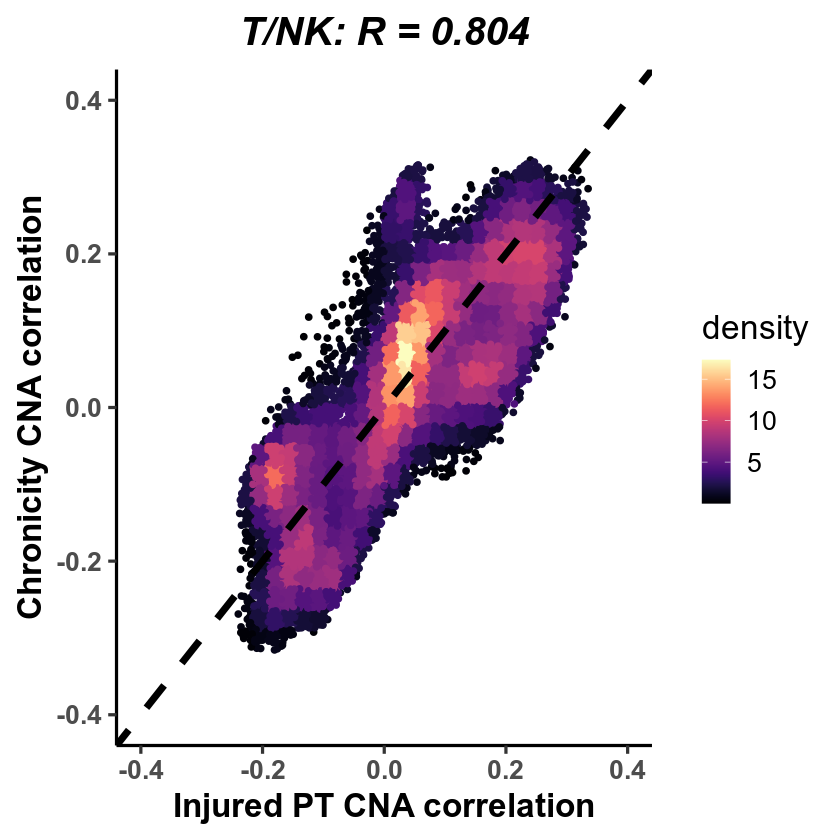

In [28]:
cor(ncorr_meta$pt_ncorr, ncorr_meta$chronicity_ncorr)
ggplot(ncorr_meta, aes(x = pt_ncorr, y = chronicity_ncorr, color = density)) +
    geom_point() +
    scale_color_viridis(option = "magma") + 
    theme_classic(base_size = 20) +
    geom_abline(linetype = 'dashed', linewidth = 2) + 
    scale_x_continuous(limits = c(-0.4, 0.4)) + 
    scale_y_continuous(limits = c(-0.4, 0.4)) + 
    labs(x = "Injured PT CNA correlation",
         y = "Chronicity CNA correlation",
         title = "T/NK: R = 0.804") + 
    theme(
          axis.text = element_text(face = "bold"),
          axis.title = element_text(face = "bold"),
          plot.title = element_text(face = "bold.italic", 
                                    hjust = 0.5))

#### MASC

In [45]:
model_df <- meta %>% 
                left_join(qcd_meta %>% select(cell, nCount_RNA, percent.mt, new_cluster_number)) %>%
                mutate(nCount_RNA = log(nCount_RNA))

res <- MASC.me(model_df, as.factor(model_df$new_cluster_number),
                contrast = "injured_pt_prop",
                random_effects = c("sample"),
                fixed_effects = c("nCount_RNA", "percent.mt"),
                verbose = TRUE,
                save_models = F) %>%
            dplyr::mutate(bonferroni = p.adjust(model.pvalue, method = "bonferroni")) %>%
            dplyr::arrange(model.pvalue)

Joining, by = "cell"
Using null model: cluster ~ nCount_RNA + percent.mt + (1|sample)

Creating logistic mixed models for cluster0

Creating logistic mixed models for cluster1

Creating logistic mixed models for cluster10

Creating logistic mixed models for cluster11

Creating logistic mixed models for cluster12

Creating logistic mixed models for cluster13

Creating logistic mixed models for cluster14

Creating logistic mixed models for cluster15

Creating logistic mixed models for cluster16

Creating logistic mixed models for cluster17

Creating logistic mixed models for cluster18

Creating logistic mixed models for cluster19

Creating logistic mixed models for cluster2

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.105942 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescal

In [46]:
saveRDS(res, '/data/srlab/ssg34/SLE_kidney_v2/data/masc/t_nk/injured_pt.rds')

In [47]:
res <- res %>% 
        rowwise() %>% 
        mutate(cluster = ifelse(unlist(str_split(cluster, 'cluster'))[2] %in% c(0, 3), 
                                paste0('NK', unlist(str_split(cluster, 'cluster'))[2]),
                                paste0('T', unlist(str_split(cluster, 'cluster'))[2])))

Warning message:
“Removed 20 rows containing missing values (`geom_label_repel()`).”


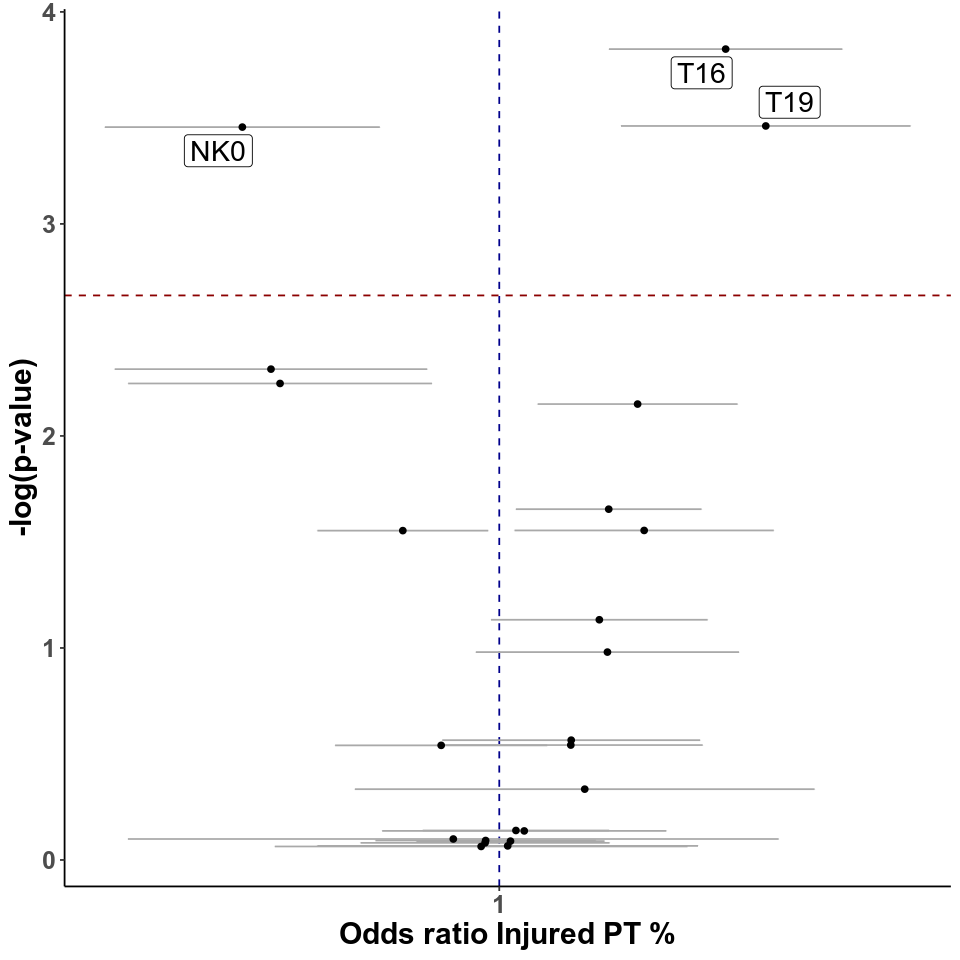

In [50]:
fig.size(8, 8)
ggplot(data = res %>% mutate(label = ifelse(-log10(model.pvalue) > -log10(0.05/23), cluster, NA)), 
       aes(x = injured_pt_prop.OR, y = -log10(model.pvalue))) +
    theme_classic() + ylab("-log(p-value)") + xlab("Odds ratio Injured PT %") +
    geom_vline(xintercept = 1, linetype = "dashed", color = "darkblue") +
    geom_errorbar(aes(xmin=injured_pt_prop.OR.95pct.ci.lower	, xmax=injured_pt_prop.OR.95pct.ci.upper), col = "darkgrey") +
    geom_point() + 
    geom_hline(yintercept = -log10(.05/ 23), linetype = "dashed", color = "darkred") +
    scale_x_log10(breaks = c(0.8, 0.9, 1, 1.1, 1.2)) + 
    ggrepel::geom_label_repel(aes(label = label), size = 6) +
    theme(axis.title = element_text(size = 18, face = "bold"),
          axis.text = element_text(size = 15, face = "bold"))